In [ ]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt

In [ ]:
import random
from sklearn.model_selection import train_test_split

In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
!pip install -U -q segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
import cv2 as cv

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def resize(image,mask):
  image=tf.keras.layers.MaxPooling2D((2,2))(image)
  mask=tf.keras.layers.MaxPooling2D((2,2))(mask)
  return image,mask

In [ ]:
def prepare_dataset(width,height,path):

  for (root ,dirs,files) in os.walk(path):

    X=[]
    y=[]

    for file in files:


      image_name=file.split(".")[0]
      if image_name.split("_")[-1]!="mask":

        mask_name=image_name+"_mask.jpg"
        image_path=os.path.join(path,file)
        mask_path=os.path.join(path,mask_name)

        if os.path.exists(mask_path):
          mask_image=cv.imread(mask_path)
          mask_image = np.amax(mask_image, axis=-1)
          # print(mask_image.shape)
          # mask_image = cv.cvtColor(mask_image, cv.COLOR_BGR2GRAY)
          mask_image//=255
          image=cv.imread(image_path)
          image=image/255



          mask_image=cv.resize(mask_image, (width, height))
          image=cv.resize(image, (width, height))


          # image=np.expand_dims(image,axis=-1)

          X.append(image)
          y.append(mask_image)

  X=np.array(X).astype(np.float64)
  y=np.expand_dims(y,axis=-1)
  y=np.array(y).astype(np.float64)
  print(y.shape)
  X,y=resize(X,y)
  return X,y

In [ ]:
X,y=prepare_dataset(512,1024,"/content/drive/MyDrive/Suspicious")

In [ ]:
X1,y1=prepare_dataset(512,1024,"/content/drive/MyDrive/Normal")

In [ ]:
X = np.concatenate((X, X1), axis=0)
y = np.concatenate((y, y1), axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def create_sample_weight(y):
    sample_weight = np.ones_like(y)
    sample_weight[y == 1] = 1.2
    return sample_weight

# create sample weights using tf.numpy_function
sample_weight = tf.numpy_function(create_sample_weight, [y_], tf.float64)

In [ ]:
n_classes=2
activation='sigmoid'

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)
X = preprocess_input1(X)

model1 = sm.Linknet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation,input_shape=(512,256,3))

model1.compile(optimizer="adam", loss=total_loss, metrics=metrics)


print(model1.summary())

In [ ]:
history = model1.fit(X_train,y_train, epochs=200,batch_size=8,sample_weight=sample_weight,validation_data=(X_test,y_test))

Epoch 1/200
29/29 [==============================] - 39s 422ms/step - loss: 0.9997 - iou_score: 1.9261e-04 - f1-score: 3.8514e-04 - val_loss: 0.9998 - val_iou_score: 5.8195e-08 - val_f1-score: 5.8195e-08
Epoch 2/200
29/29 [==============================] - 7s 226ms/step - loss: 0.9996 - iou_score: 2.4482e-04 - f1-score: 4.8949e-04 - val_loss: 1.0016 - val_iou_score: 5.7659e-08 - val_f1-score: 5.7659e-08
Epoch 3/200
29/29 [==============================] - 7s 232ms/step - loss: 0.9995 - iou_score: 2.9289e-04 - f1-score: 5.8558e-04 - val_loss: 1.0000 - val_iou_score: 3.1558e-05 - val_f1-score: 6.3088e-05
Epoch 4/200
29/29 [==============================] - 7s 229ms/step - loss: 0.9994 - iou_score: 3.6950e-04 - f1-score: 7.3864e-04 - val_loss: 1.0017 - val_iou_score: 4.9844e-08 - val_f1-score: 4.9844e-08
Epoch 5/200
29/29 [==============================] - 7s 234ms/step - loss: 0.9994 - iou_score: 4.0448e-04 - f1-score: 8.0843e-04 - val_loss: 1.0004 - val_iou_score: 1.3592e-08 - val_f1-sc

KeyboardInterrupt: ignored

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/breast_cancer.h5', compile=False)
model2.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
history2 = model2.fit(X_,y_, epochs=40,batch_size=8,sample_weight=sample_weight,)

Epoch 1/40
36/36 [==============================] - 8s 211ms/step - loss: 0.9855 - iou_score: 0.0083 - f1-score: 0.0153
Epoch 2/40
36/36 [==============================] - 8s 212ms/step - loss: 0.9852 - iou_score: 0.0084 - f1-score: 0.0155
Epoch 3/40
36/36 [==============================] - 8s 212ms/step - loss: 0.9826 - iou_score: 0.0099 - f1-score: 0.0181
Epoch 4/40
36/36 [==============================] - 8s 214ms/step - loss: 0.9865 - iou_score: 0.0076 - f1-score: 0.0143
Epoch 5/40
21/36 [================>.............] - ETA: 3s - loss: 0.9907 - iou_score: 0.0055 - f1-score: 0.0103

KeyboardInterrupt: ignored

In [ ]:
model2.save("/content/drive/MyDrive/breast_cancer_2.h5")

In [ ]:
Prediction=model2.predict(X_)

9/9 [==============================] - 9s 542ms/step


In [ ]:
Prediction[Prediction>=0.5]=1
Prediction[Prediction<0.5]=0

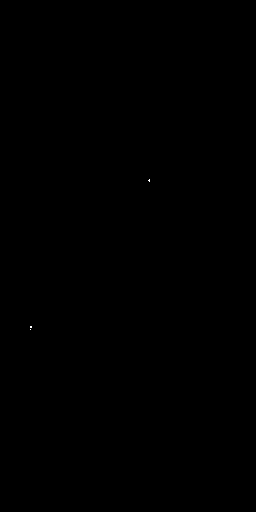

^^^^


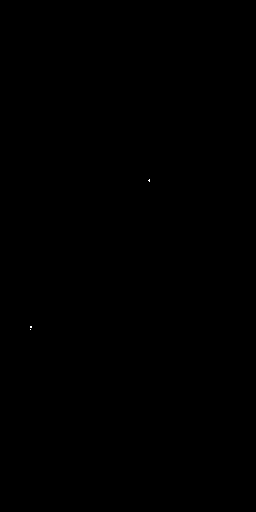

*********************


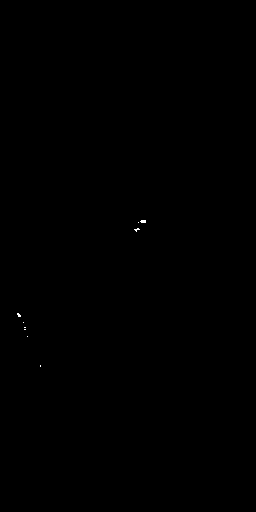

^^^^


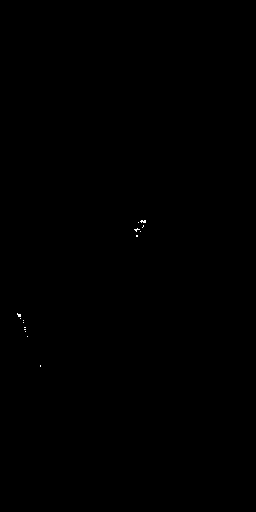

*********************


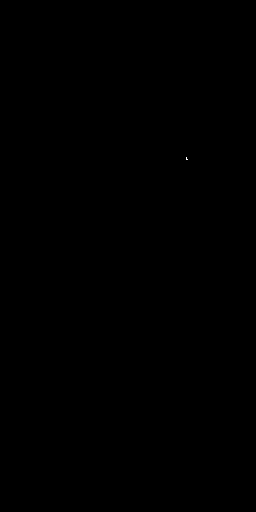

^^^^


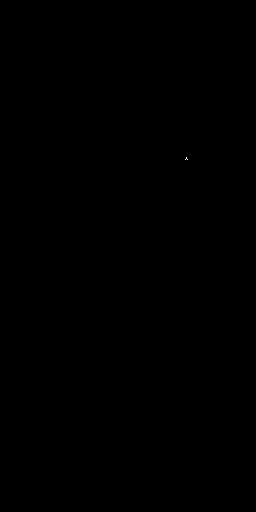

*********************


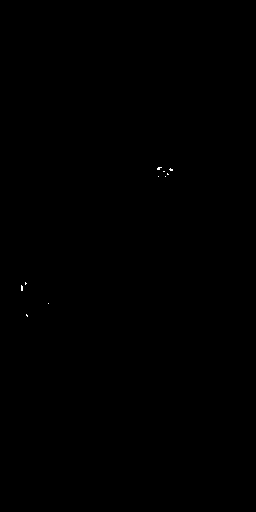

^^^^


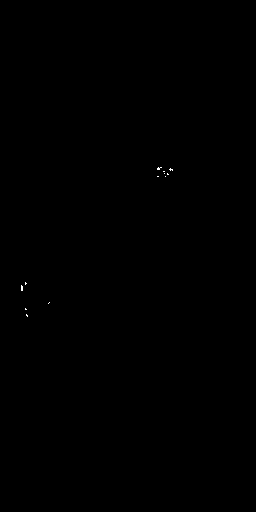

*********************


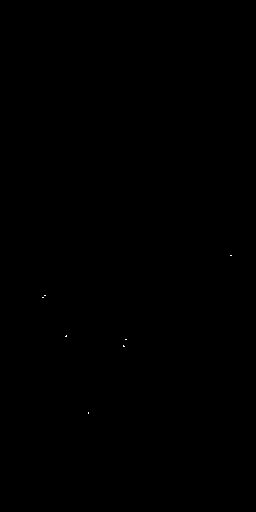

^^^^


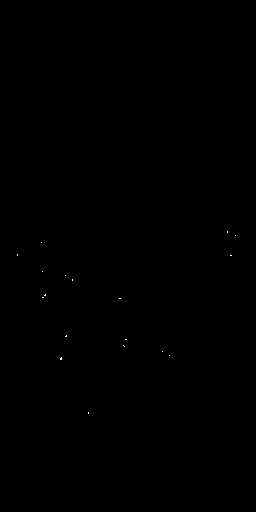

*********************


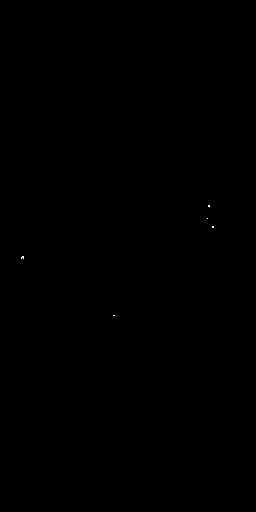

^^^^


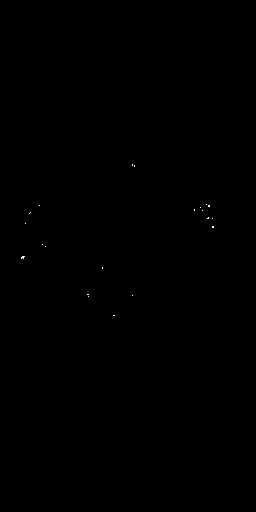

*********************


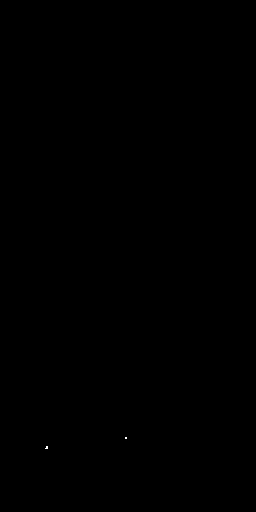

^^^^


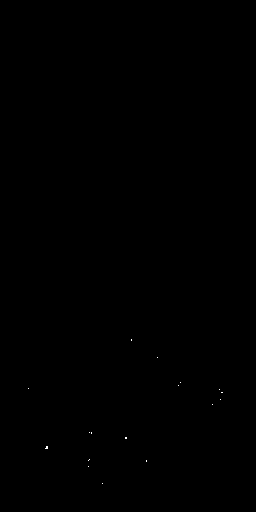

*********************


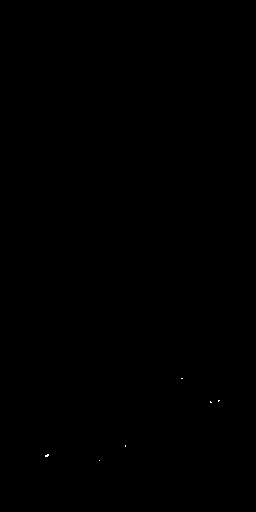

^^^^


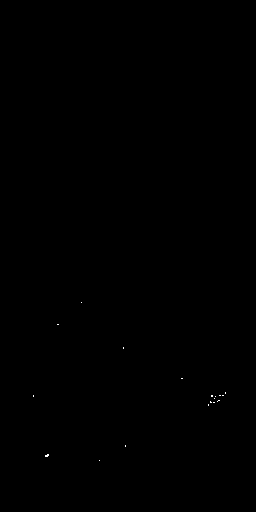

*********************


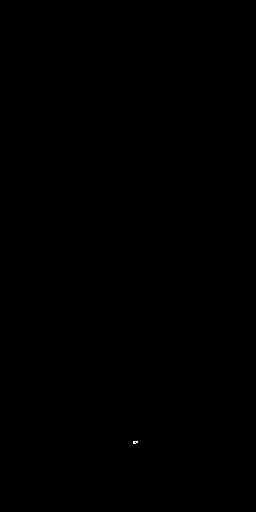

^^^^


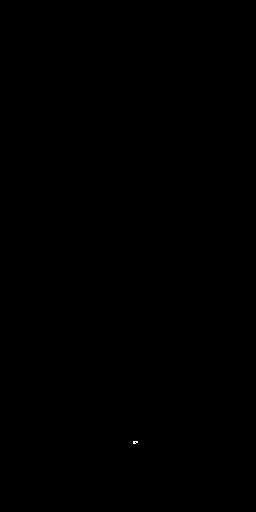

*********************


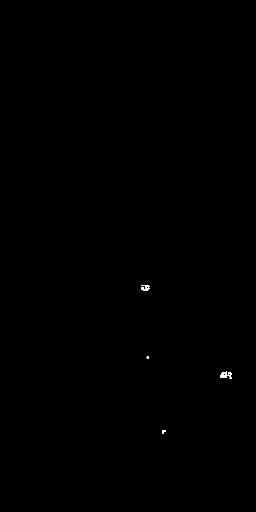

^^^^


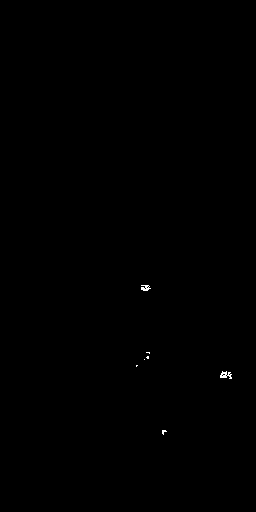

*********************


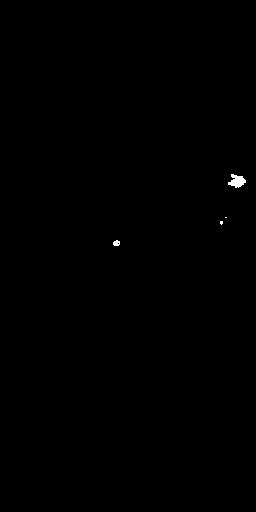

^^^^


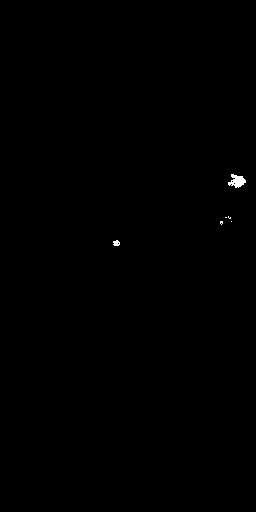

*********************


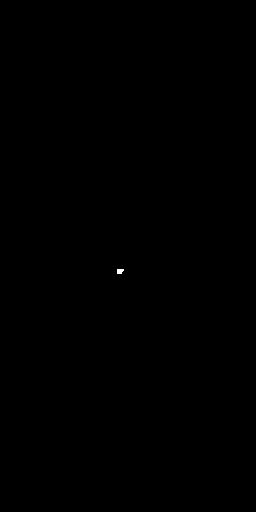

^^^^


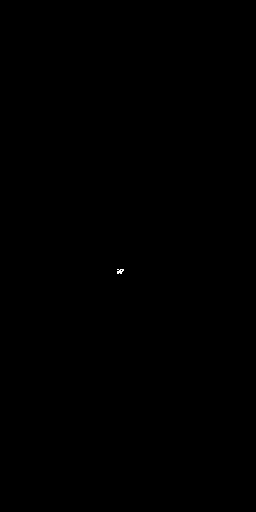

*********************


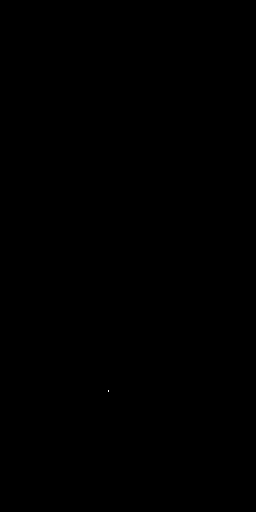

^^^^


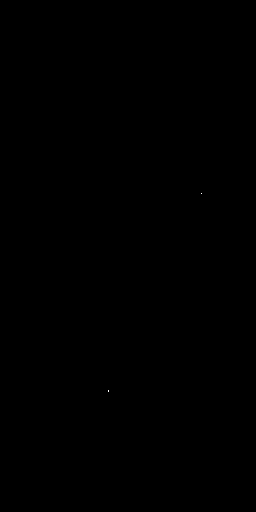

*********************


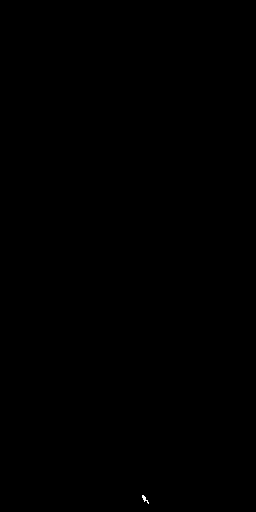

^^^^


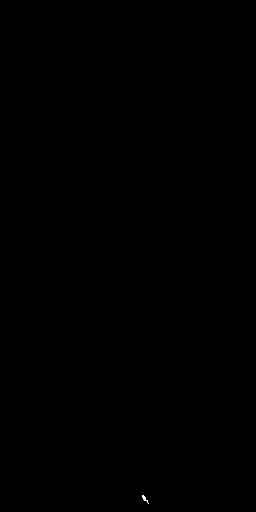

*********************


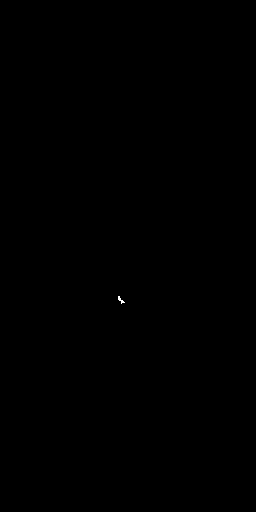

^^^^


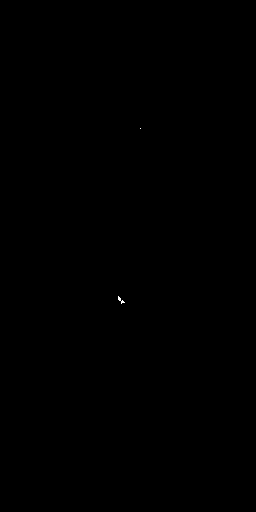

*********************


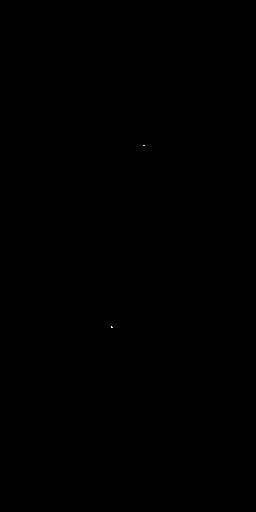

^^^^


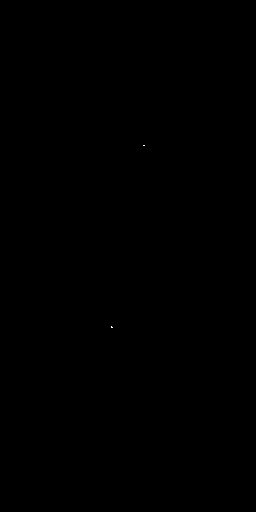

*********************


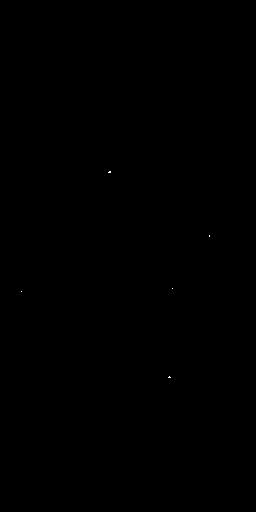

^^^^


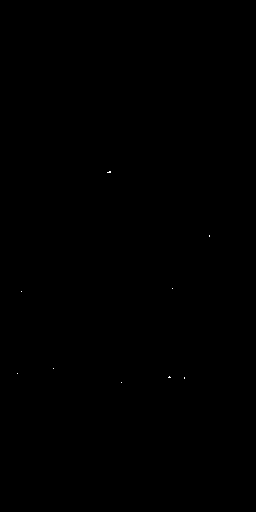

*********************


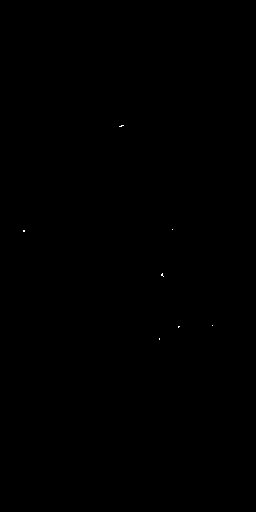

^^^^


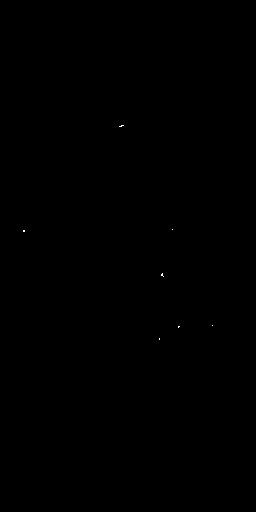

*********************


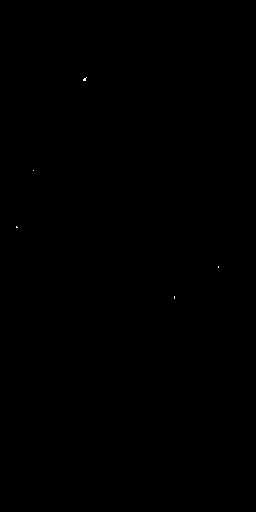

^^^^


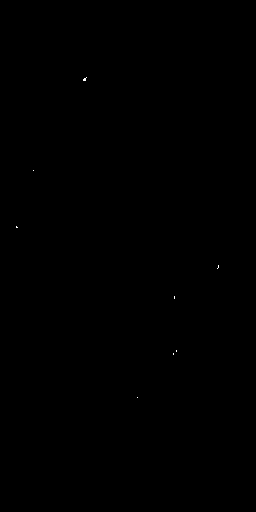

*********************


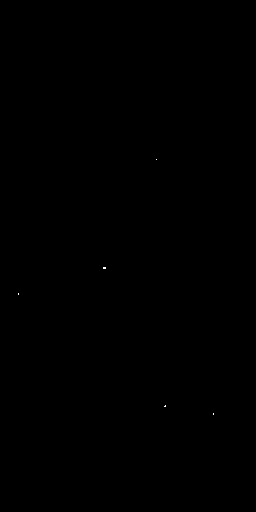

^^^^


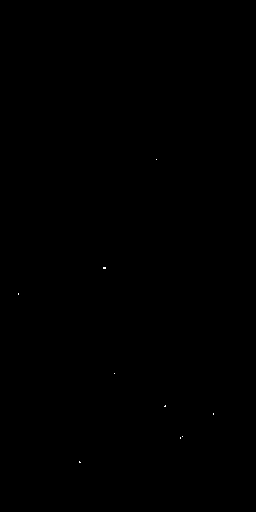

*********************


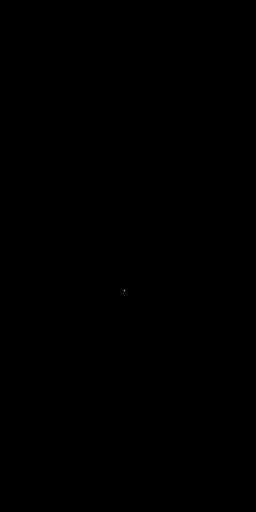

^^^^


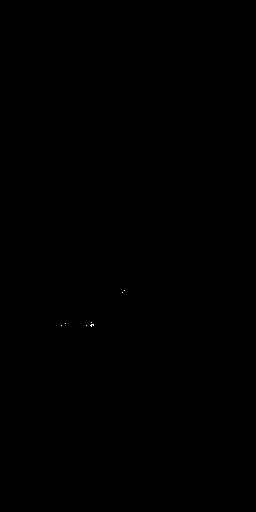

*********************


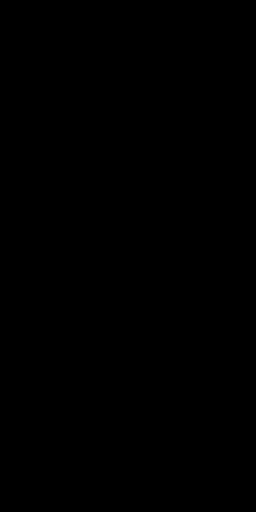

^^^^


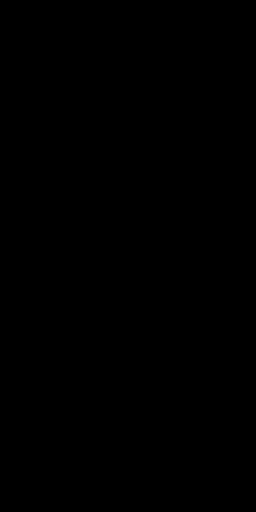

*********************


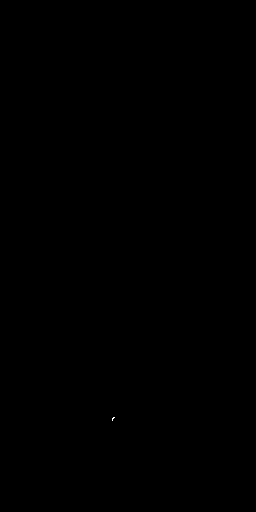

^^^^


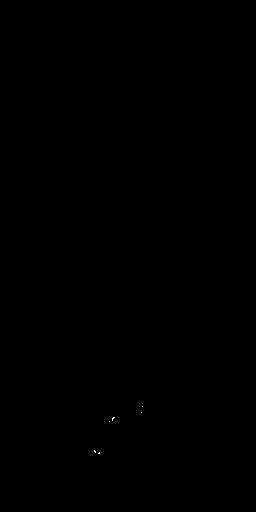

*********************


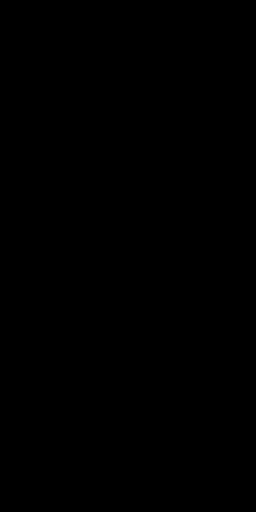

^^^^


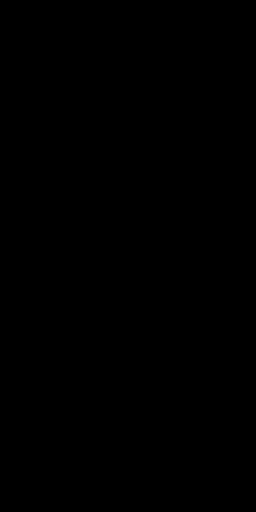

*********************


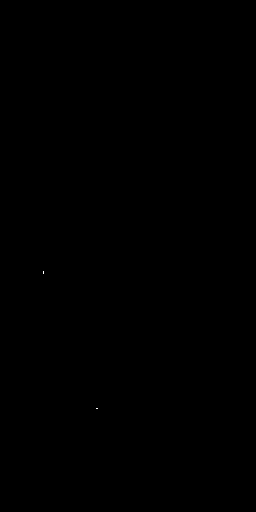

^^^^


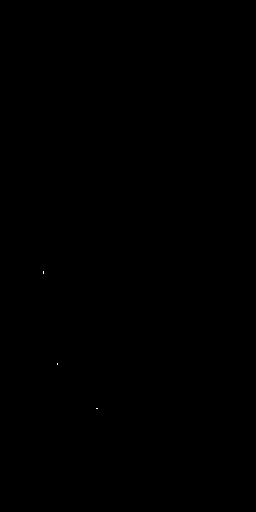

*********************


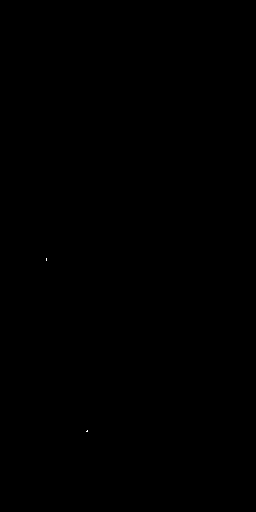

^^^^


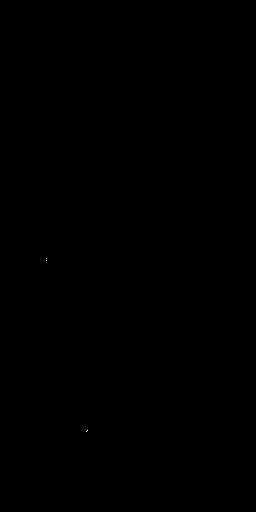

*********************


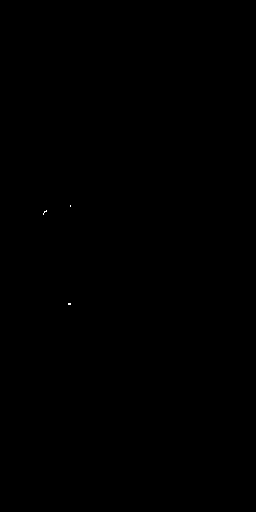

^^^^


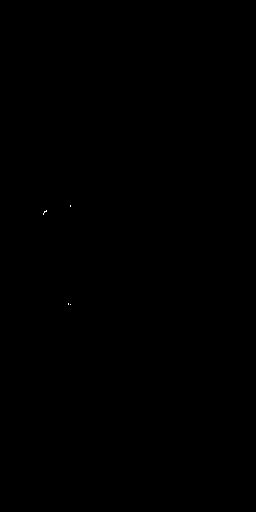

*********************


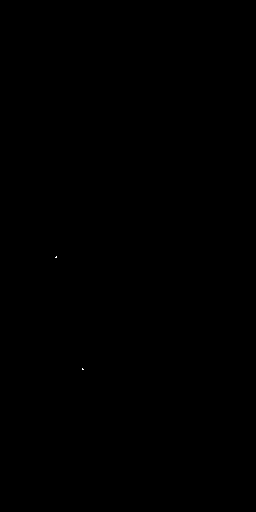

^^^^


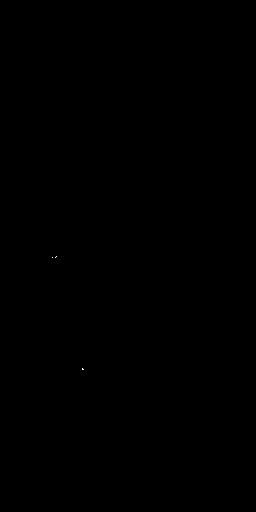

*********************


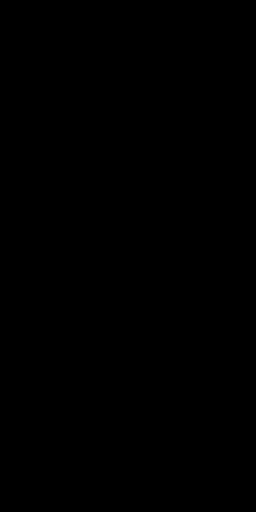

^^^^


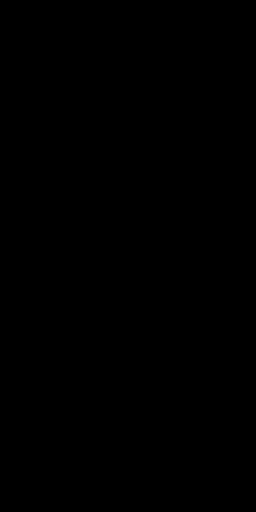

*********************


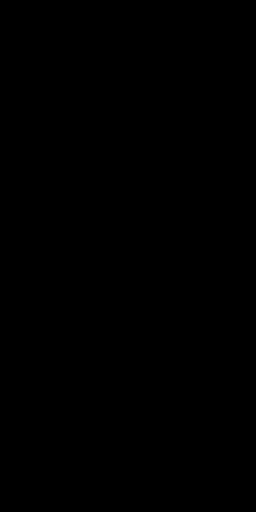

^^^^


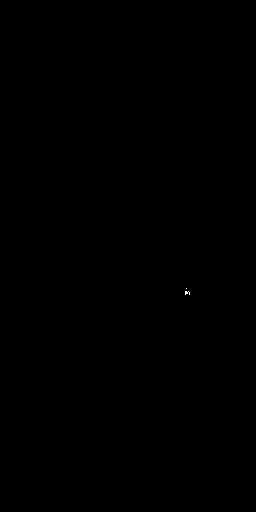

*********************


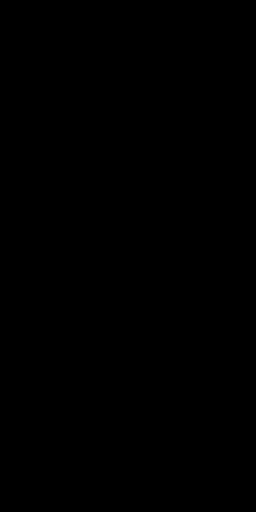

^^^^


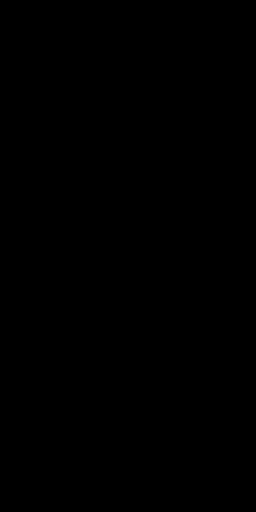

*********************


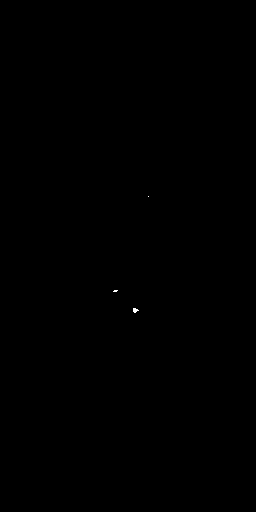

^^^^


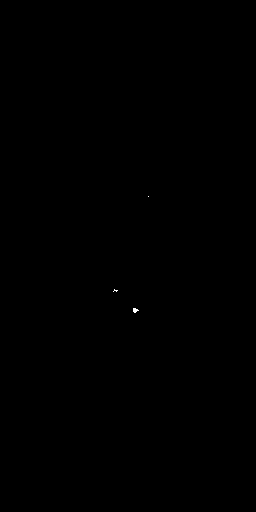

*********************


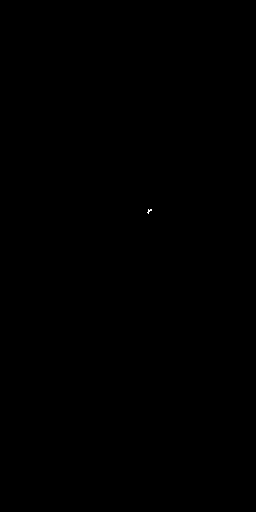

^^^^


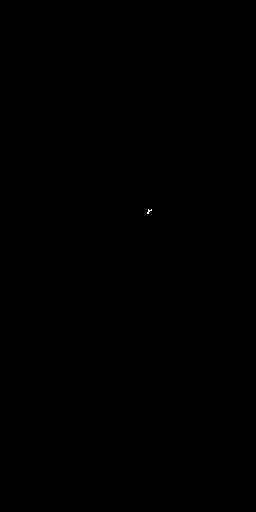

*********************


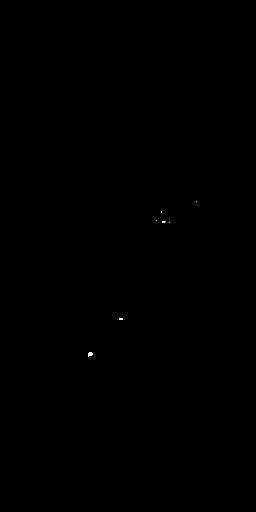

^^^^


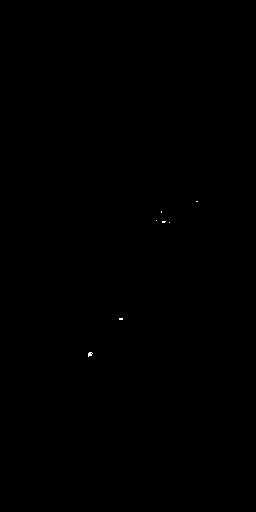

*********************


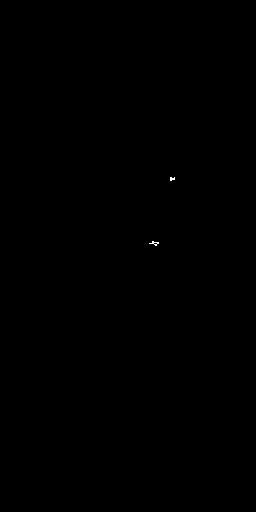

^^^^


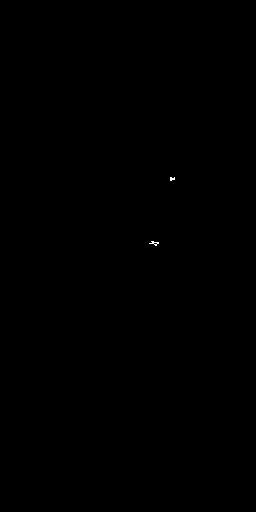

*********************


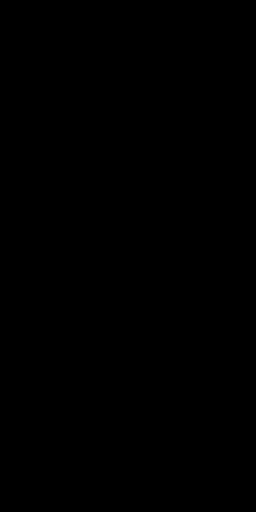

^^^^


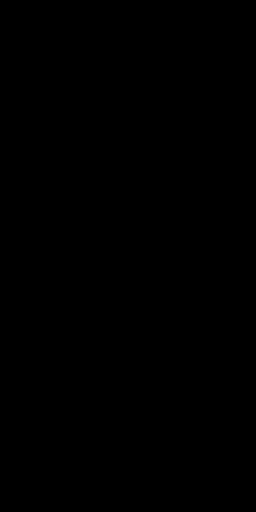

*********************


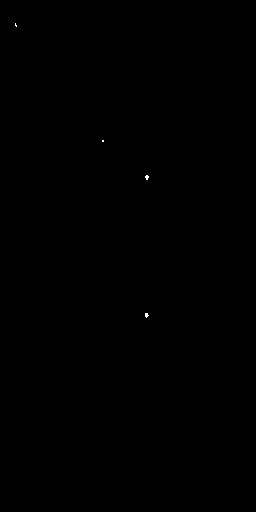

^^^^


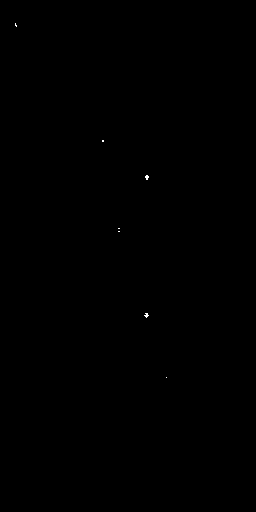

*********************


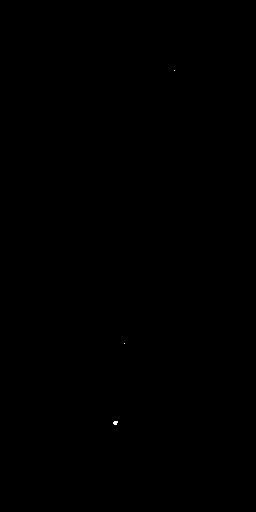

^^^^


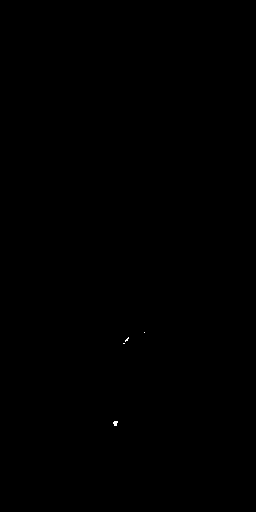

*********************


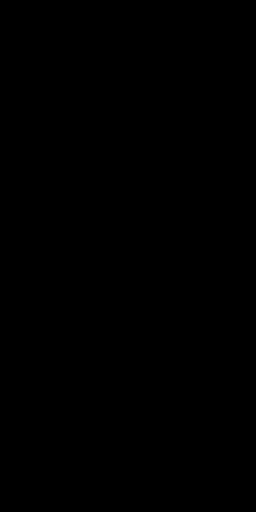

^^^^


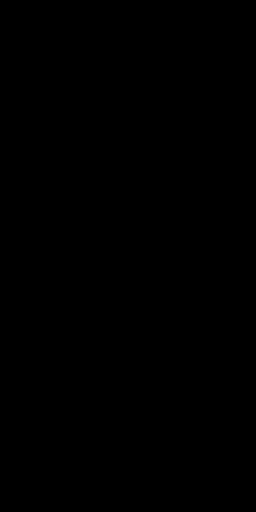

*********************


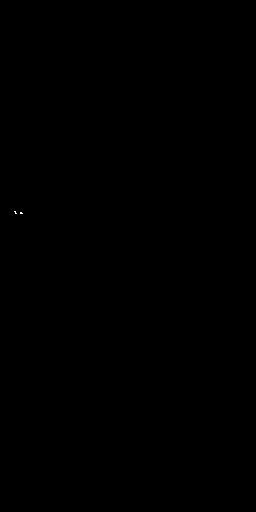

^^^^


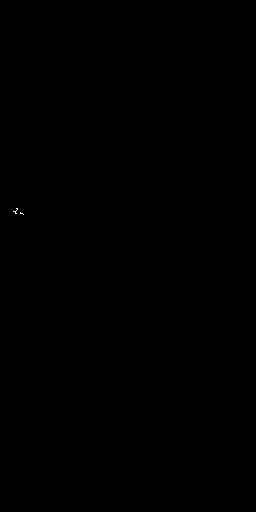

*********************


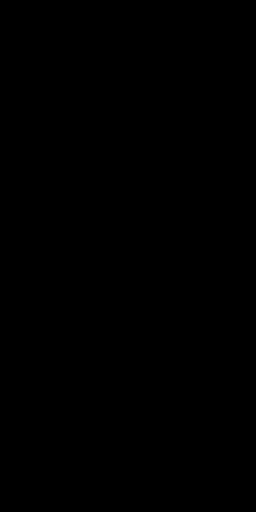

^^^^


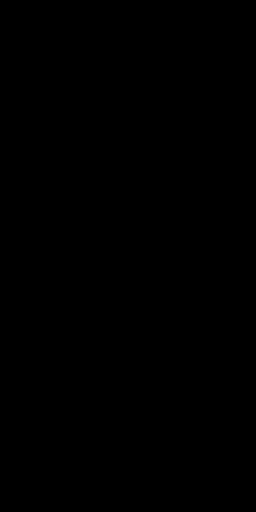

*********************


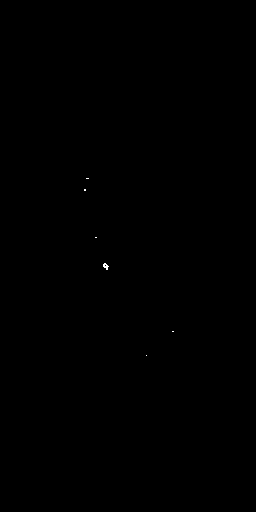

^^^^


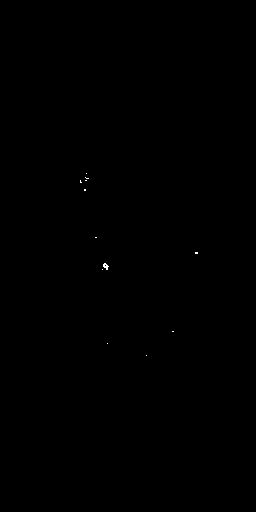

*********************


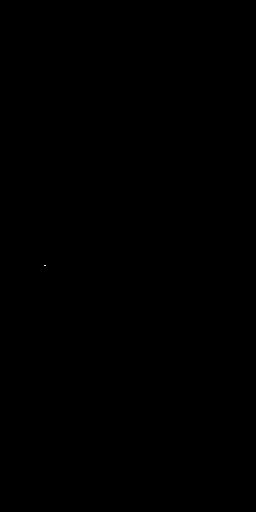

^^^^


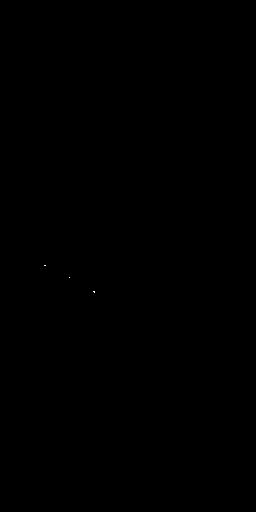

*********************


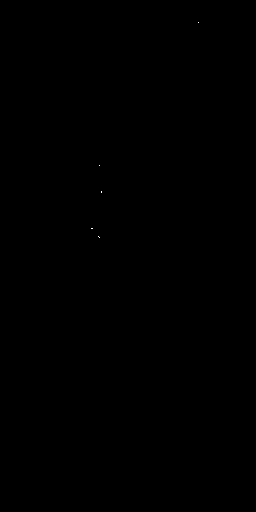

^^^^


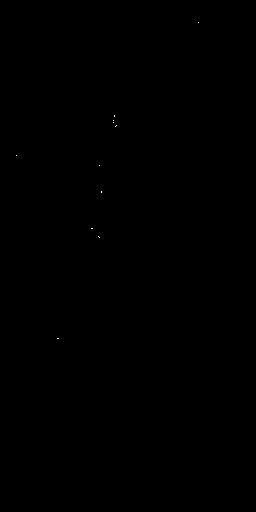

*********************


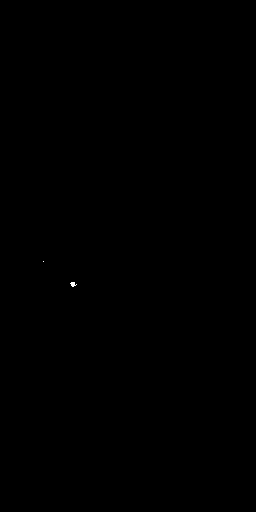

^^^^


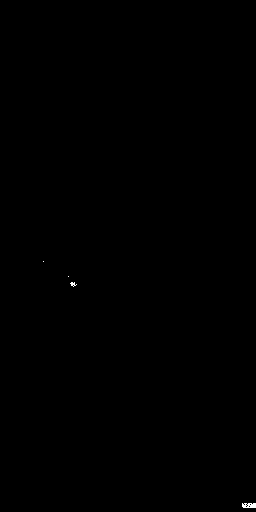

*********************


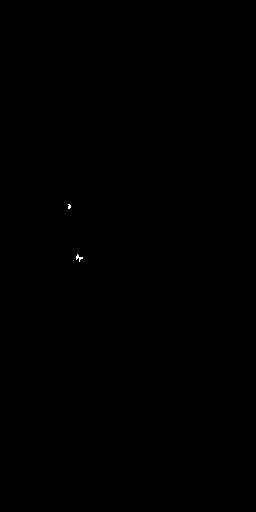

^^^^


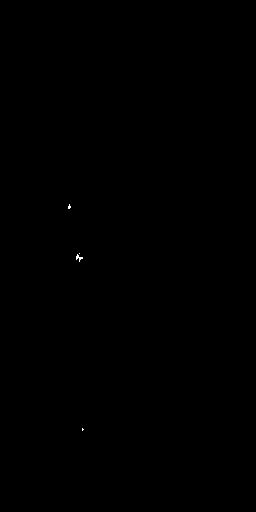

*********************


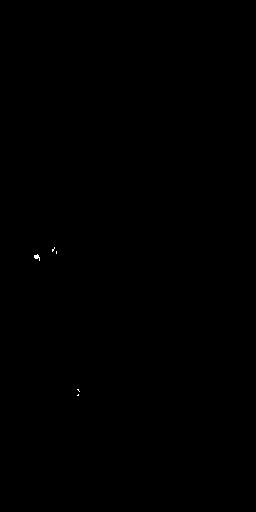

^^^^


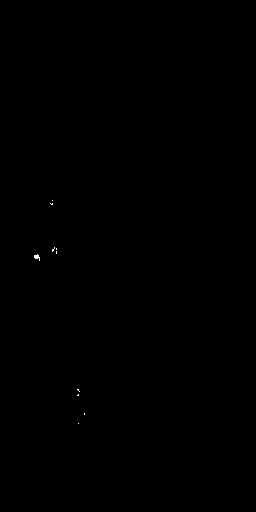

*********************


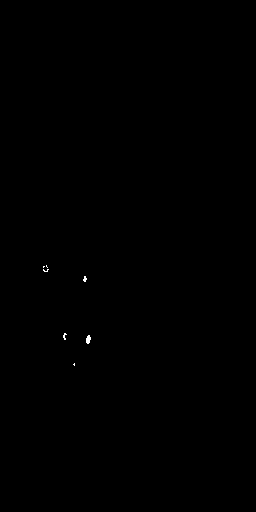

^^^^


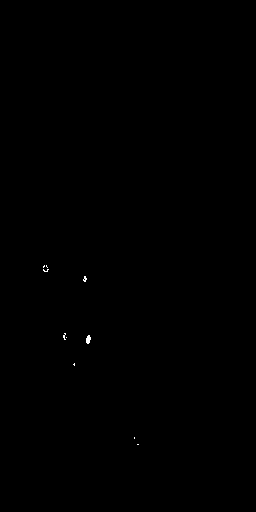

*********************


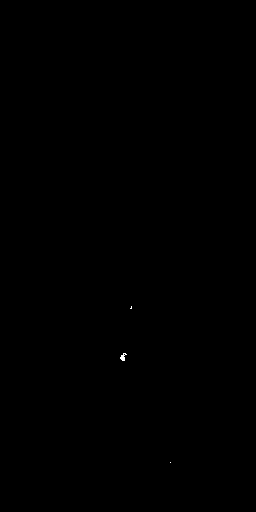

^^^^


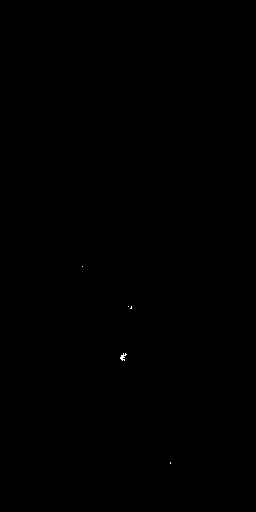

*********************


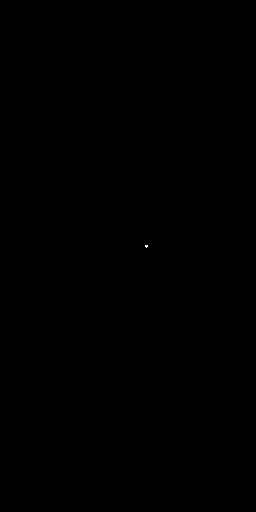

^^^^


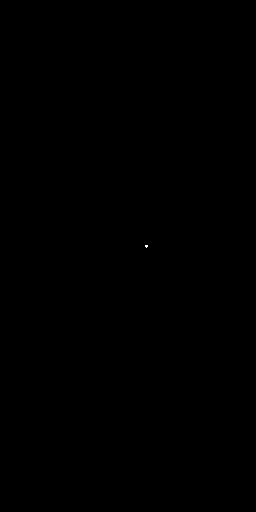

*********************


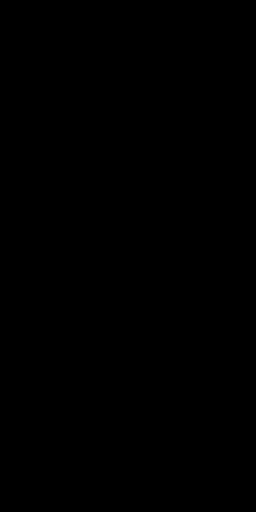

^^^^


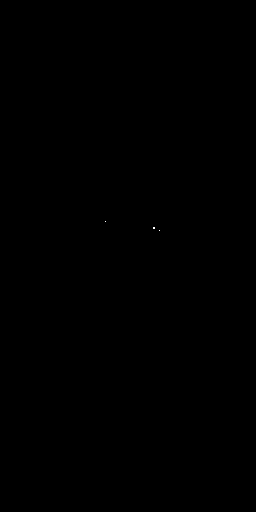

*********************


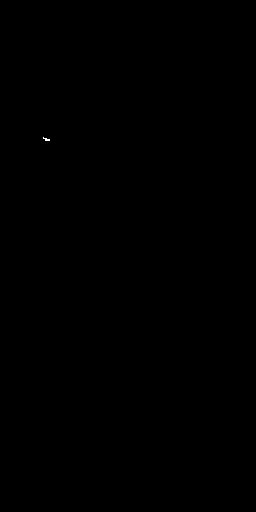

^^^^


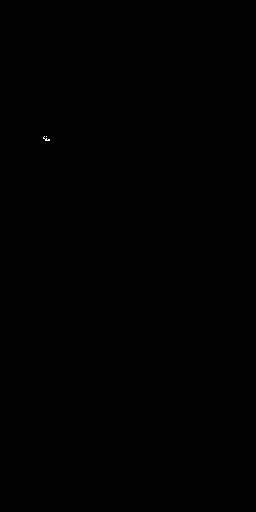

*********************


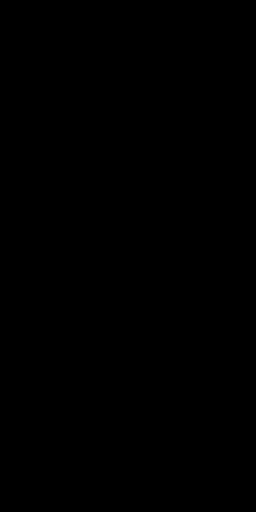

^^^^


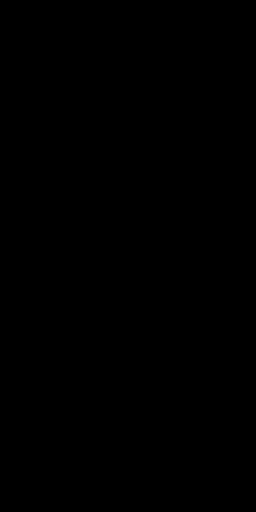

*********************


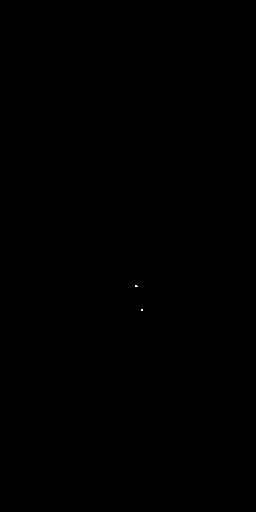

^^^^


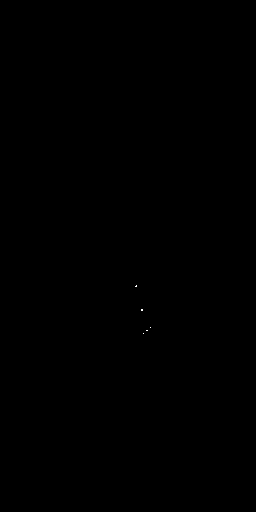

*********************


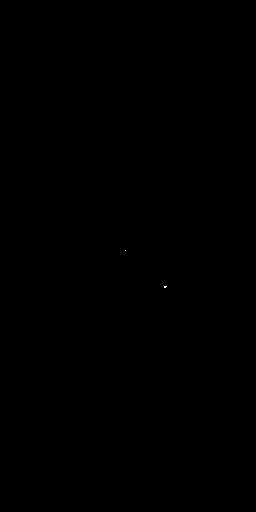

^^^^


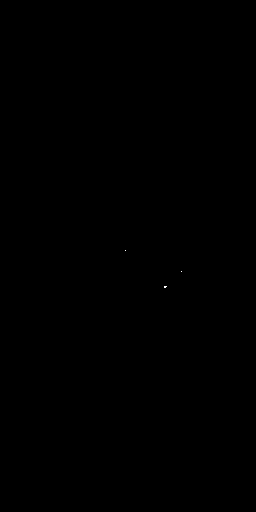

*********************


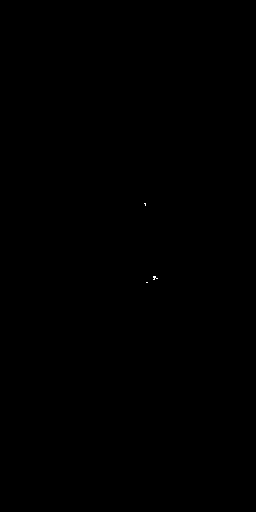

^^^^


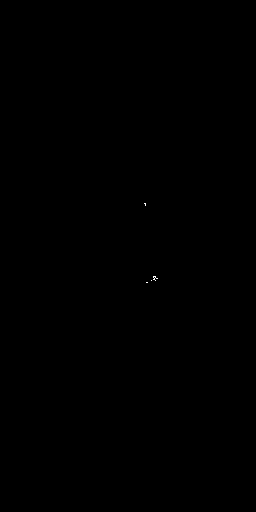

*********************


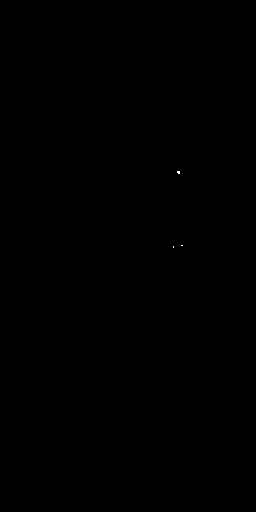

^^^^


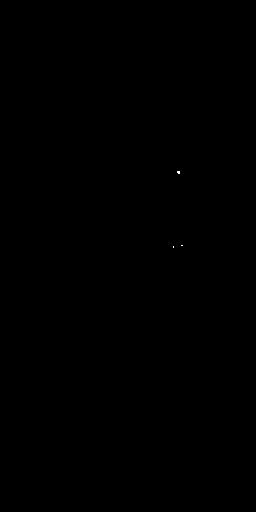

*********************


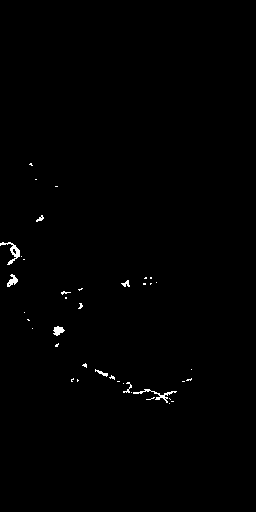

^^^^


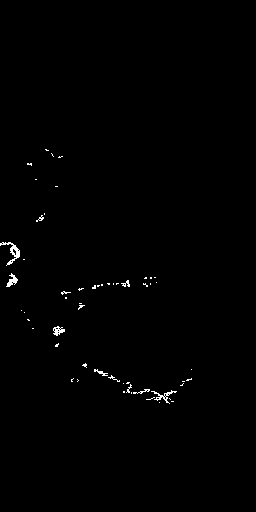

*********************


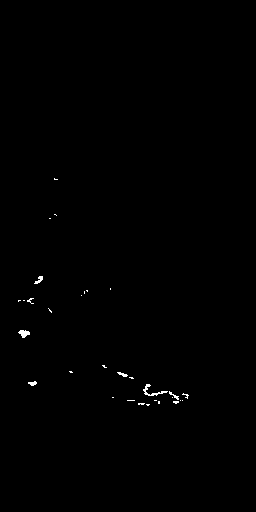

^^^^


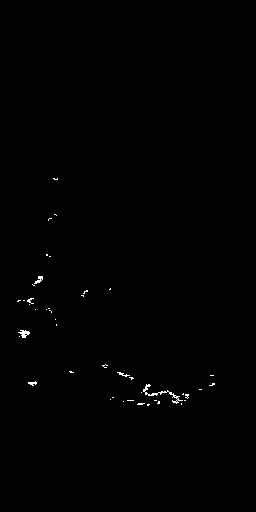

*********************


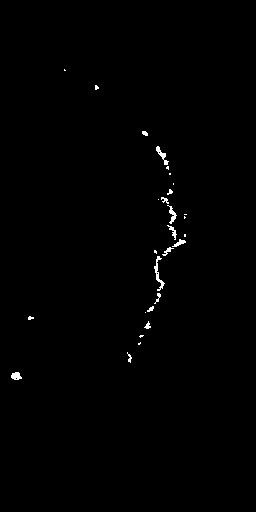

^^^^


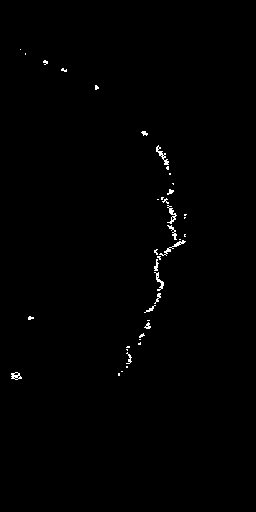

*********************


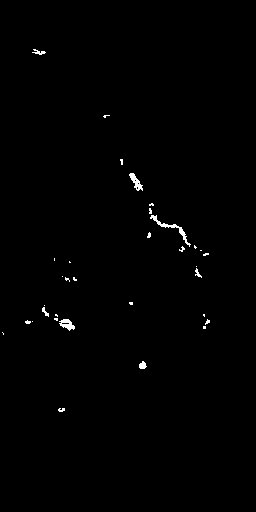

^^^^


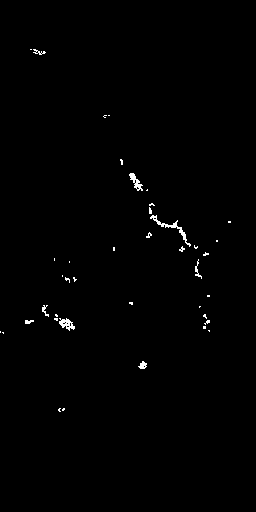

*********************


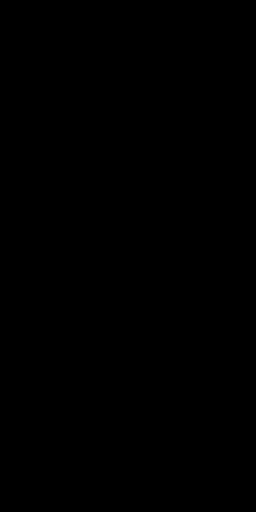

^^^^


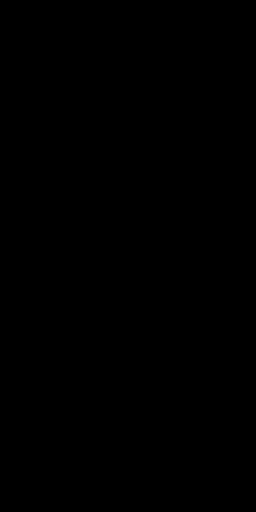

*********************


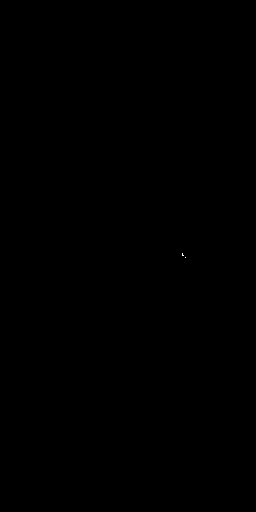

^^^^


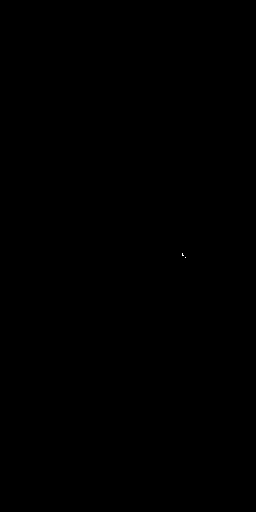

*********************


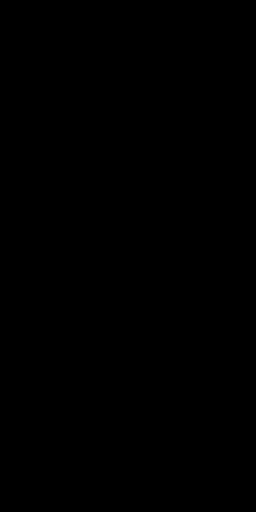

^^^^


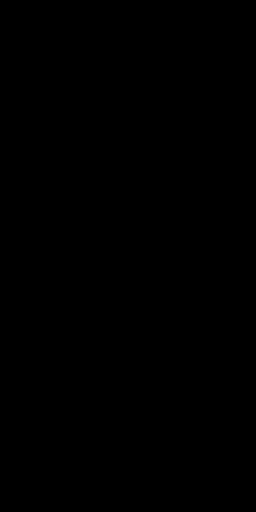

*********************


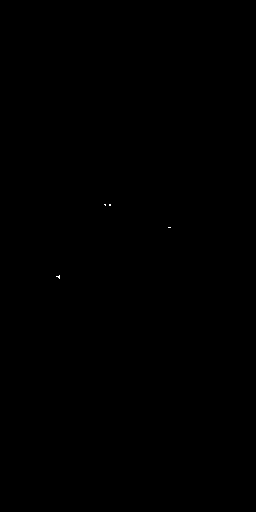

^^^^


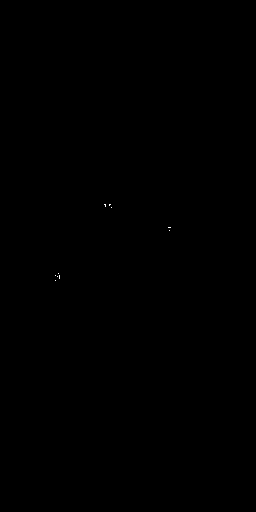

*********************


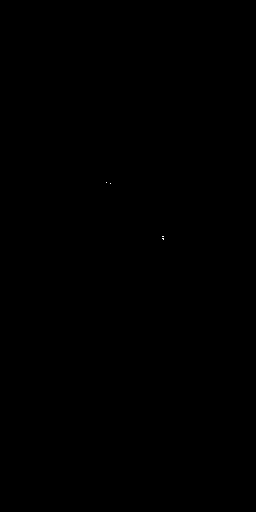

^^^^


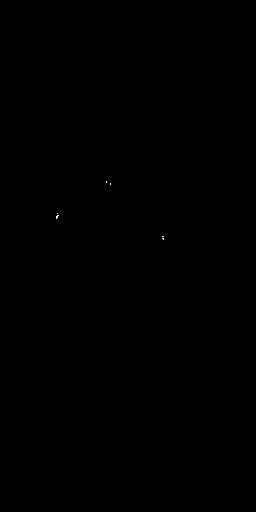

*********************


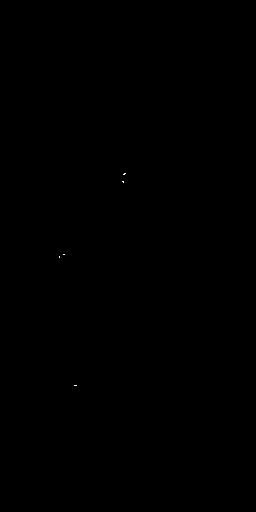

^^^^


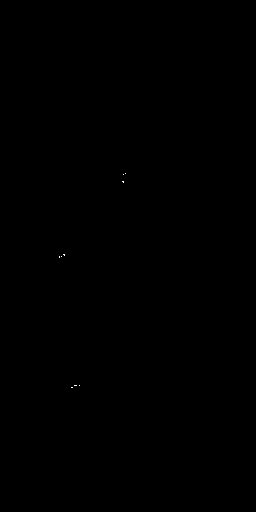

*********************


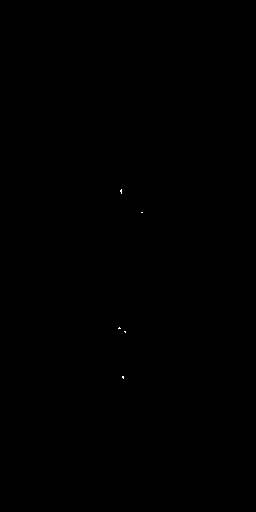

^^^^


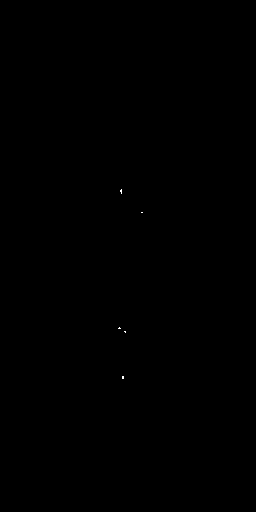

*********************


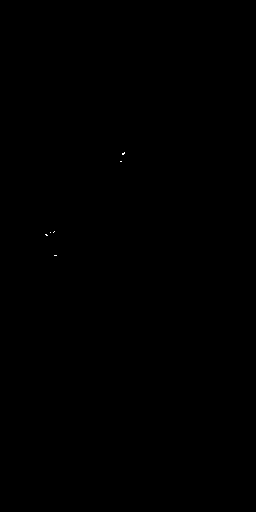

^^^^


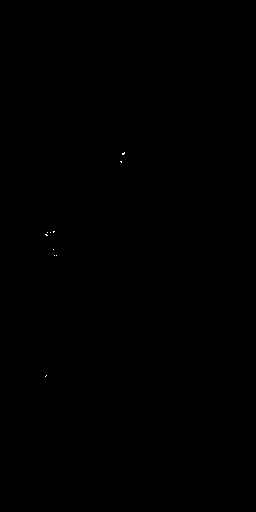

*********************


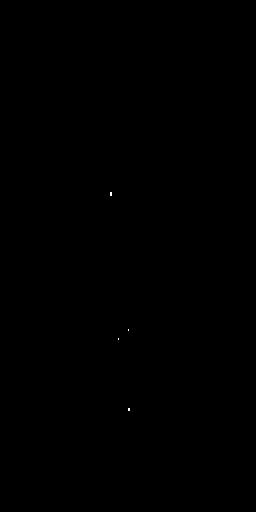

^^^^


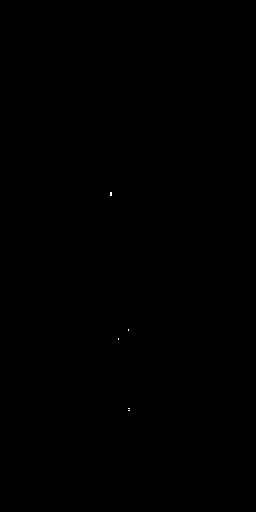

*********************


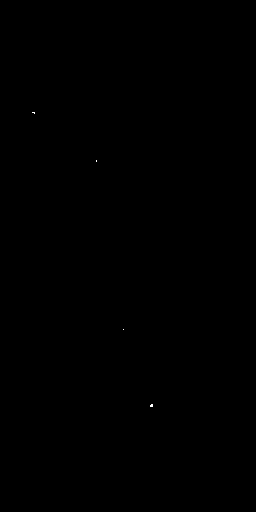

^^^^


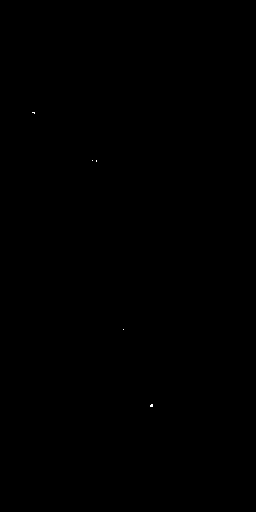

*********************


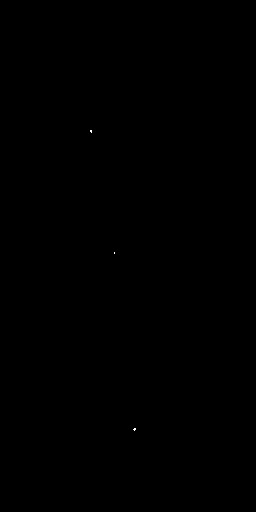

^^^^


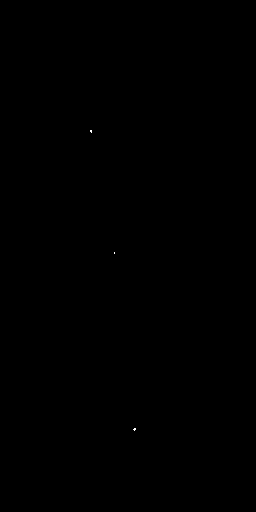

*********************


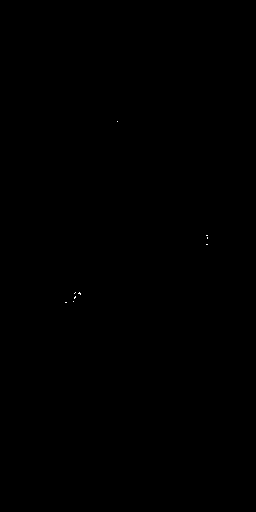

^^^^


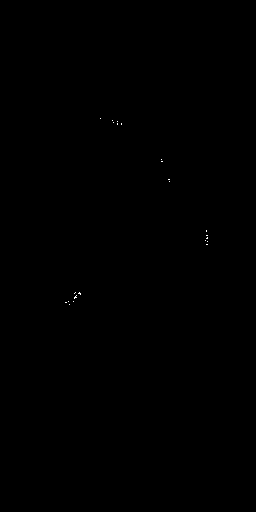

*********************


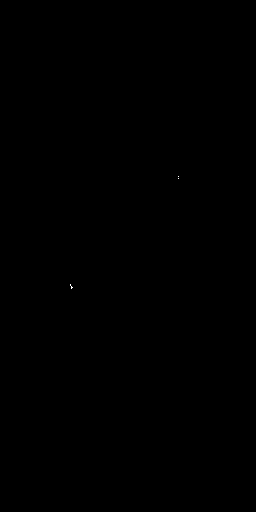

^^^^


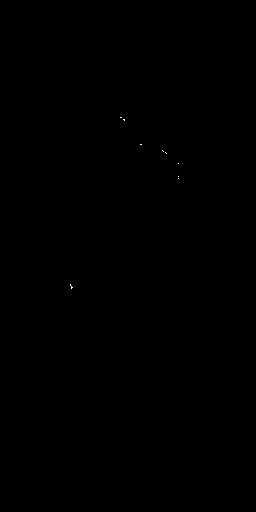

*********************


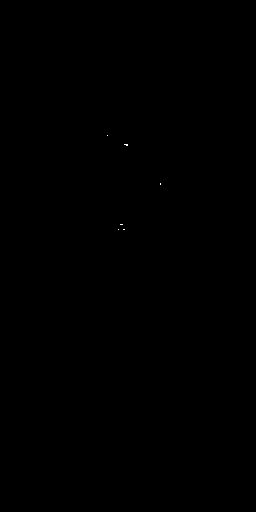

^^^^


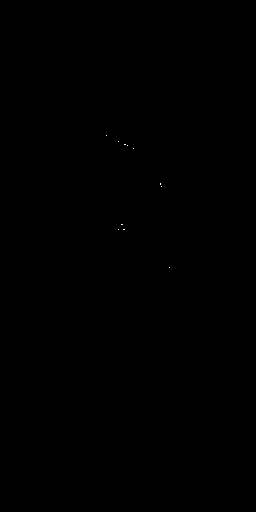

*********************


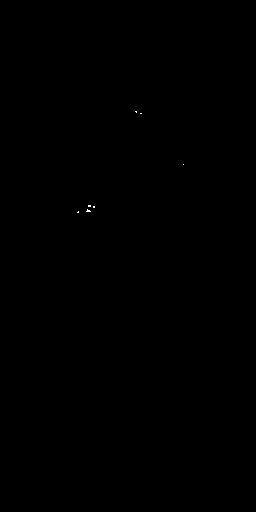

^^^^


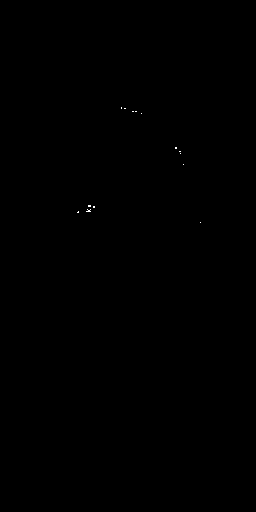

*********************


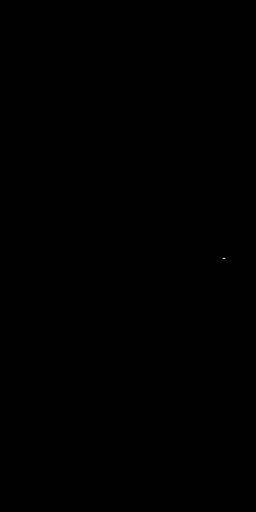

^^^^


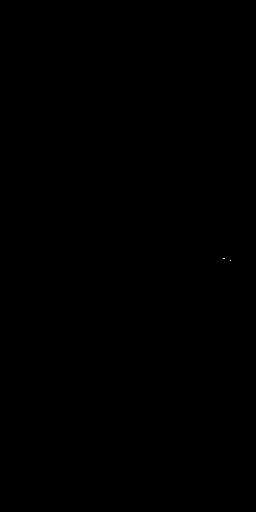

*********************


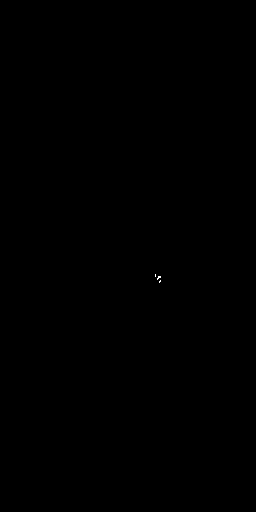

^^^^


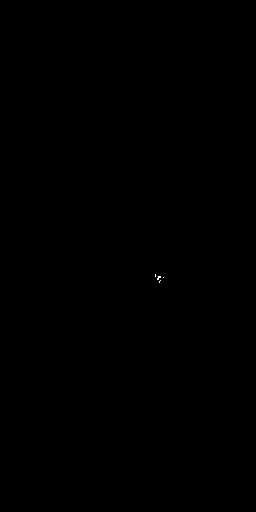

*********************


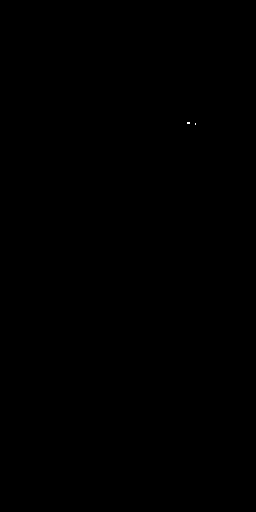

^^^^


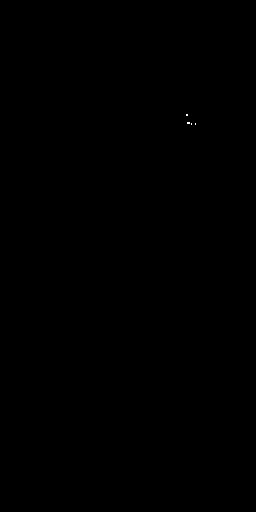

*********************


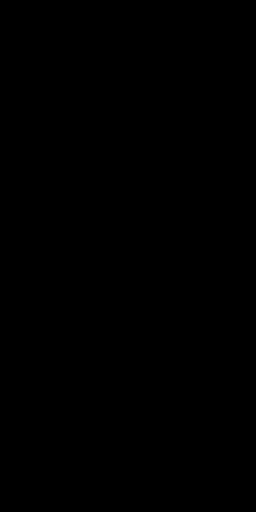

^^^^


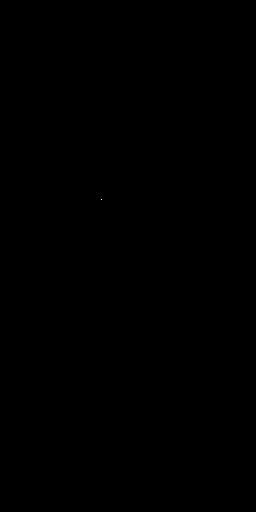

*********************


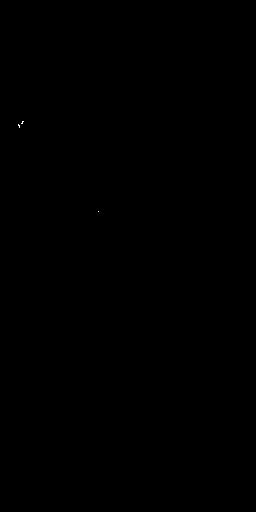

^^^^


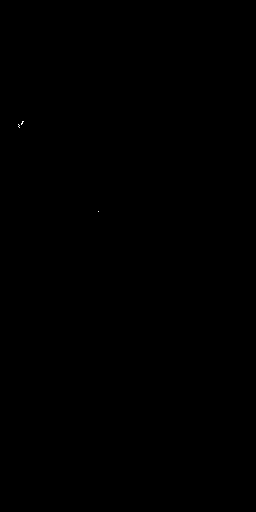

*********************


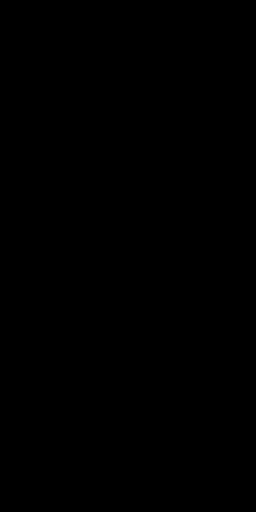

^^^^


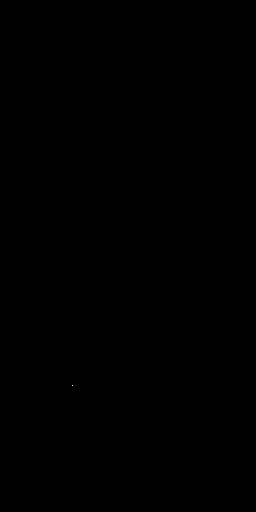

*********************


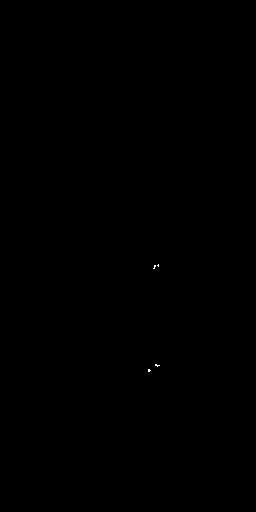

^^^^


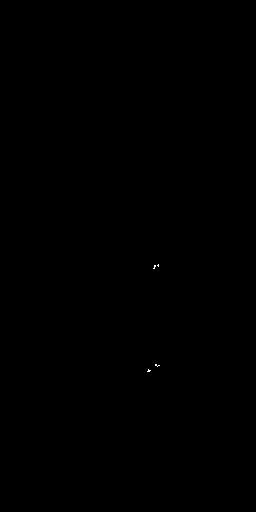

*********************


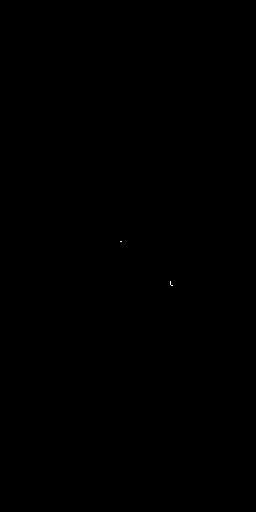

^^^^


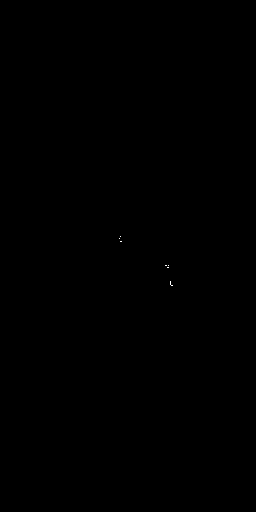

*********************


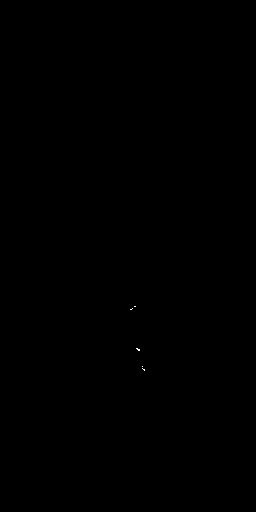

^^^^


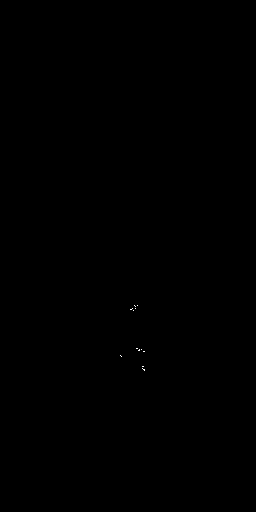

*********************


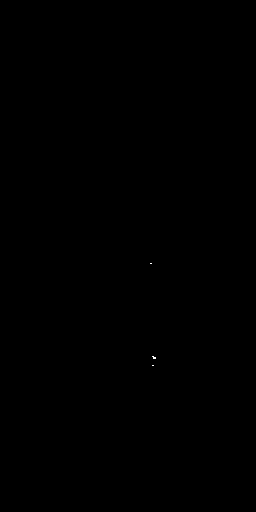

^^^^


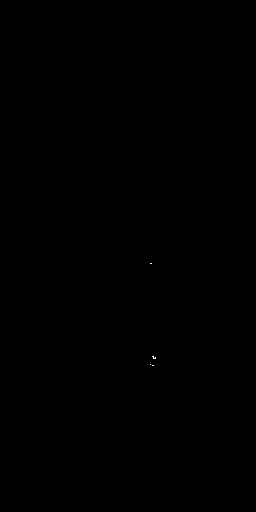

*********************


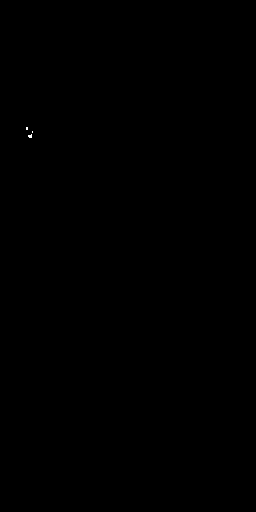

^^^^


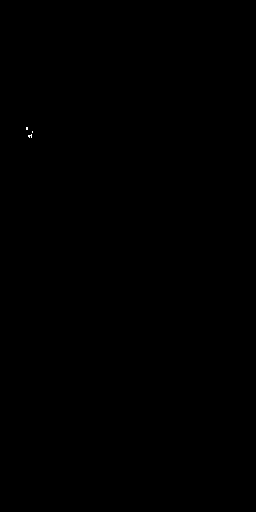

*********************


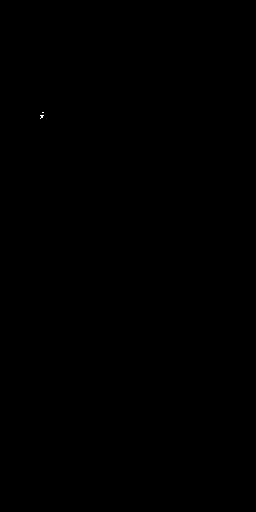

^^^^


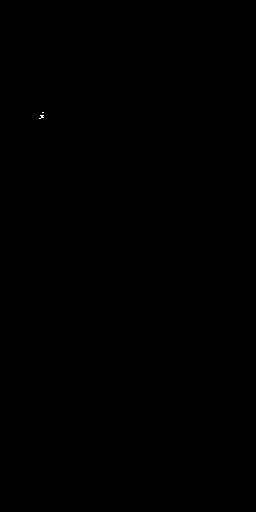

*********************


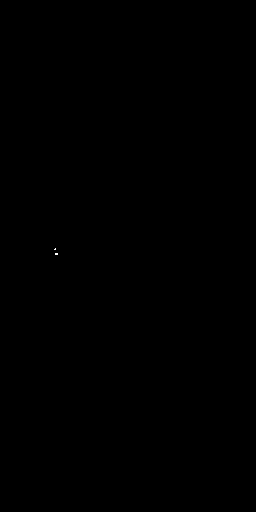

^^^^


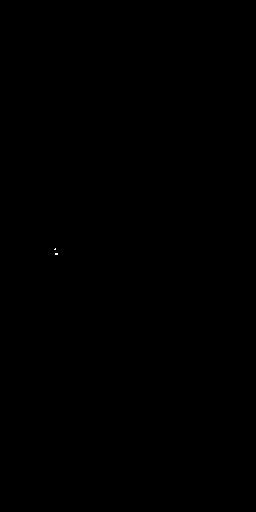

*********************


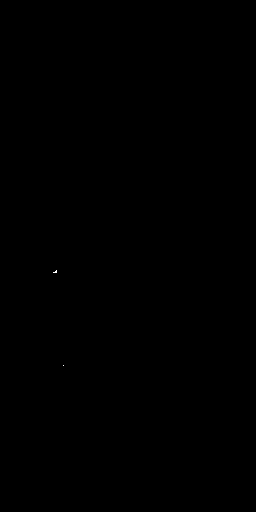

^^^^


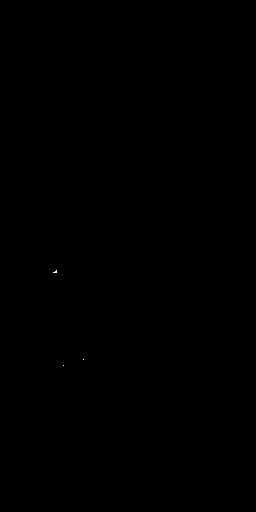

*********************


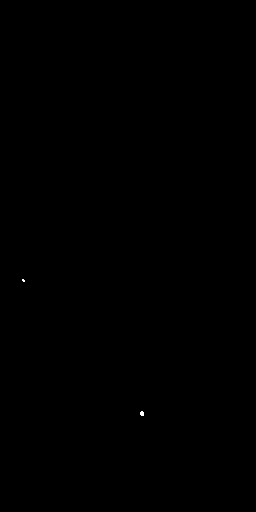

^^^^


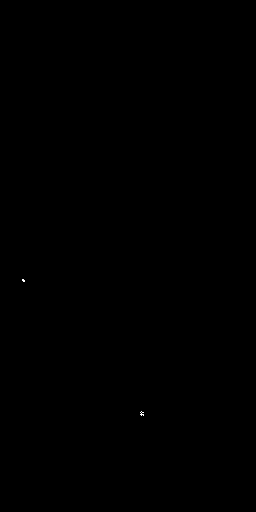

*********************


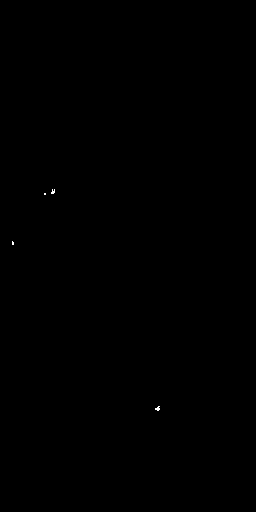

^^^^


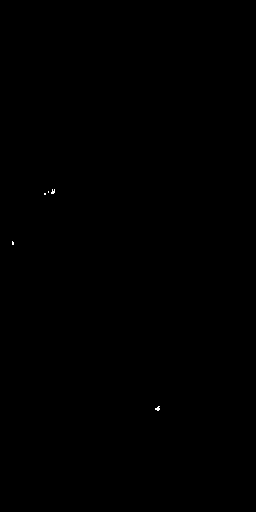

*********************


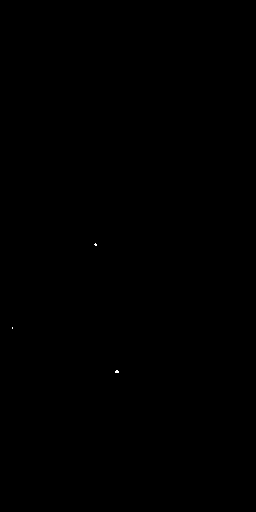

^^^^


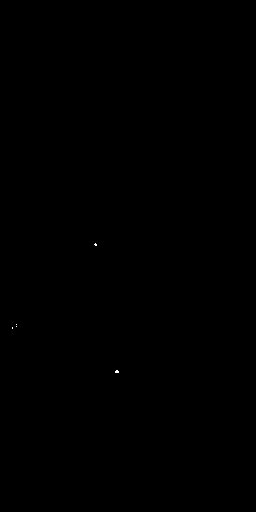

*********************


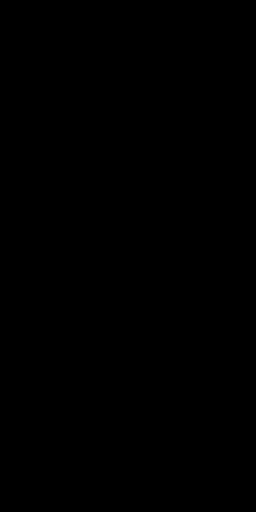

^^^^


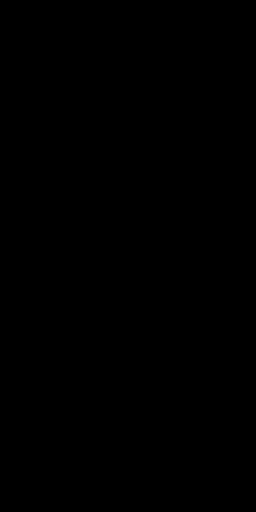

*********************


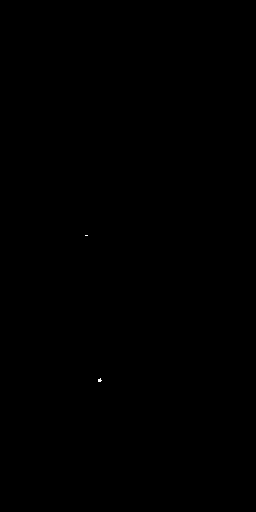

^^^^


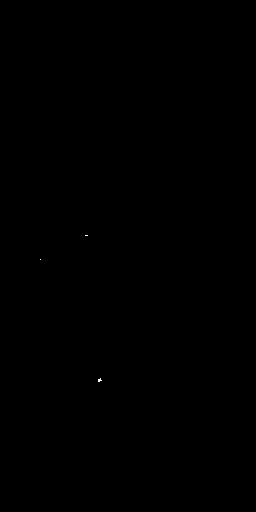

*********************


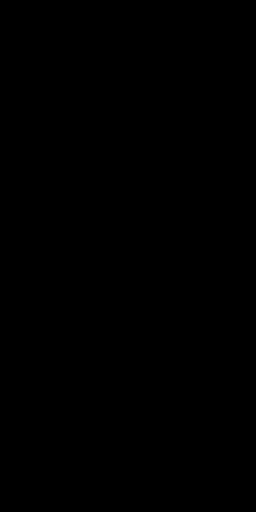

^^^^


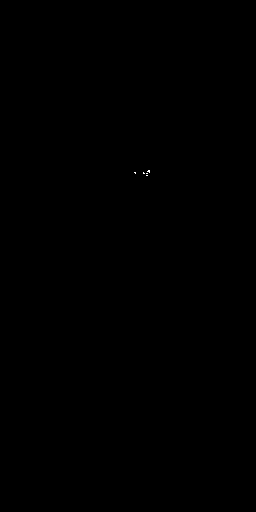

*********************


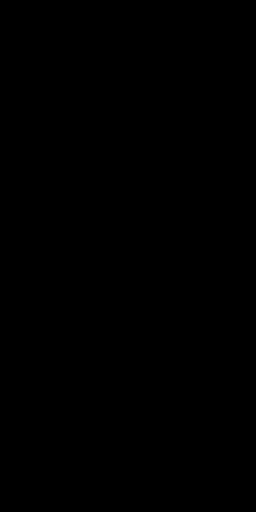

^^^^


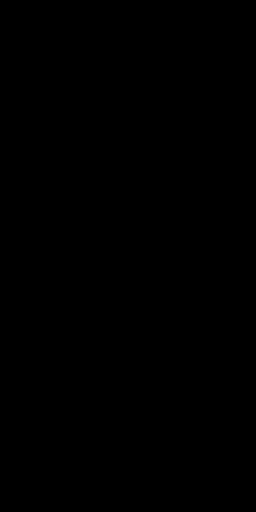

*********************


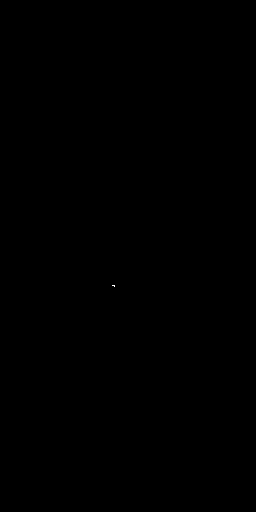

^^^^


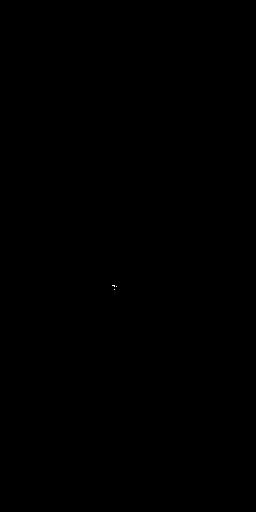

*********************


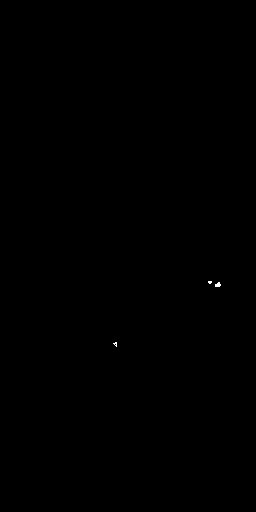

^^^^


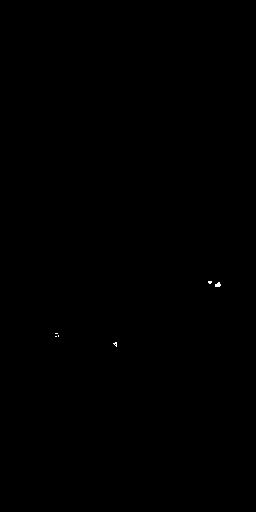

*********************


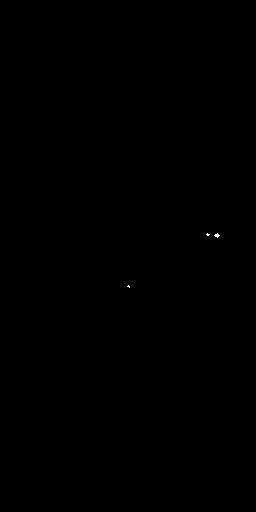

^^^^


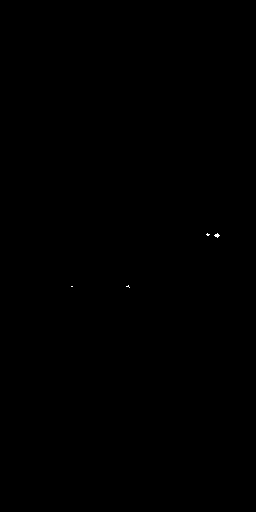

*********************


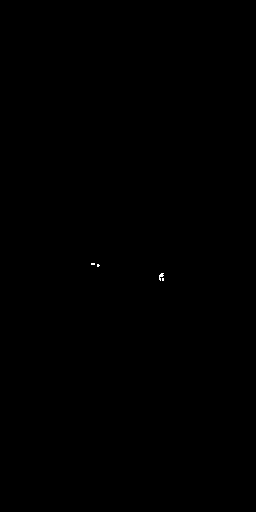

^^^^


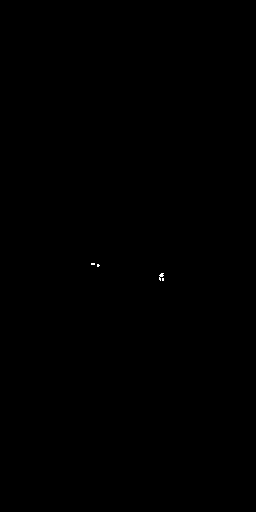

*********************


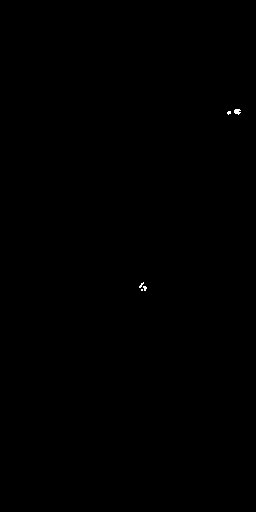

^^^^


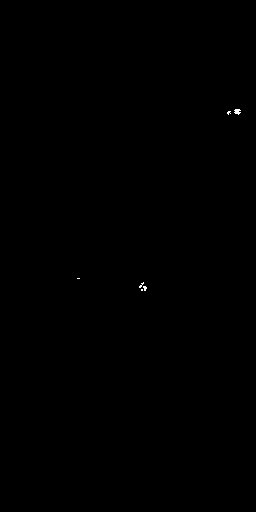

*********************


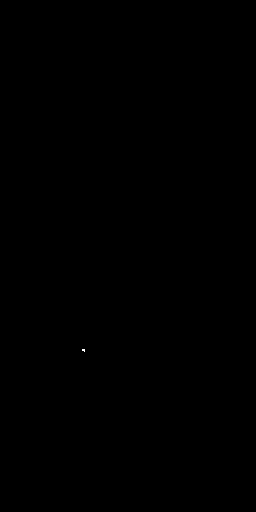

^^^^


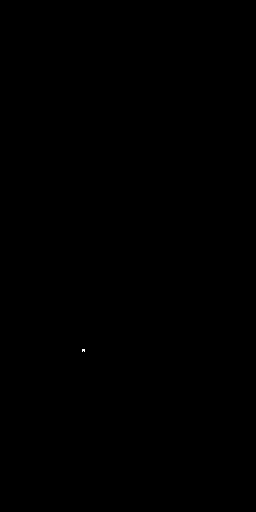

*********************


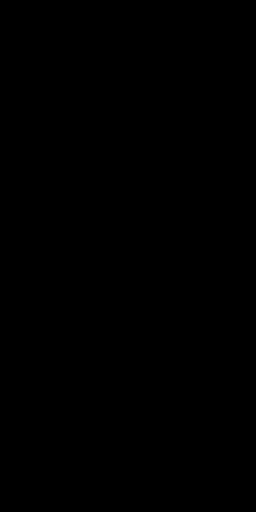

^^^^


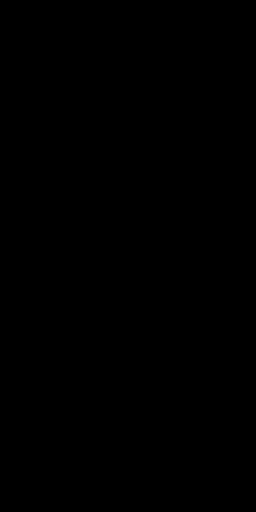

*********************


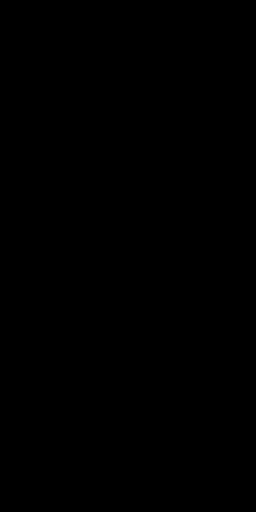

^^^^


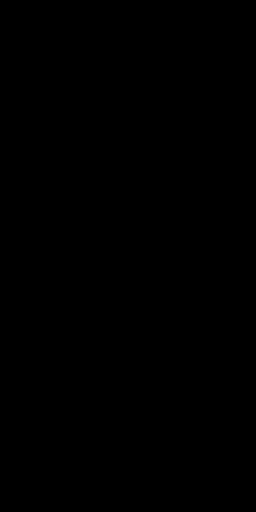

*********************


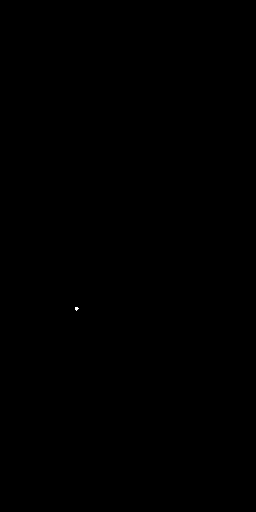

^^^^


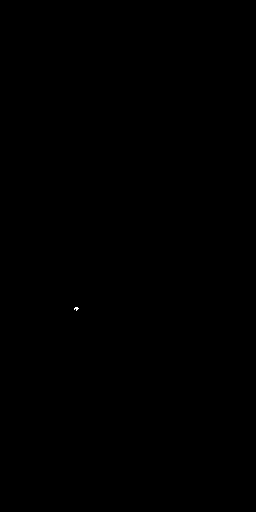

*********************


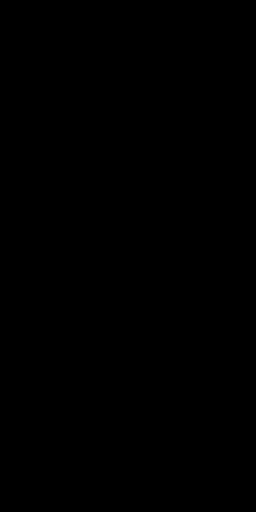

^^^^


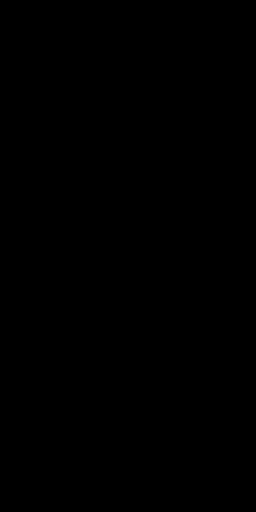

*********************


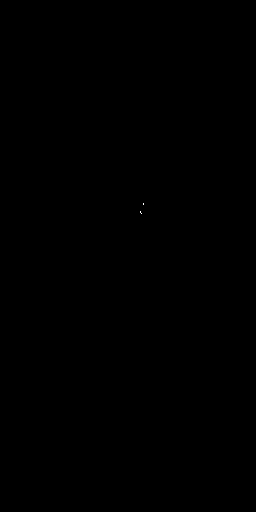

^^^^


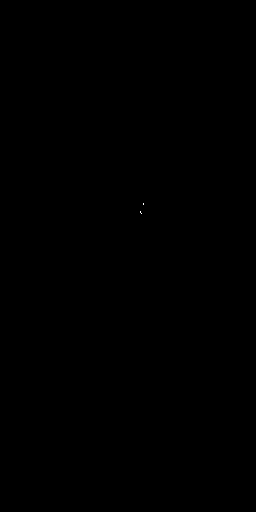

*********************


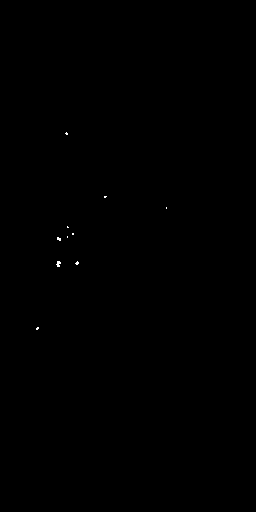

^^^^


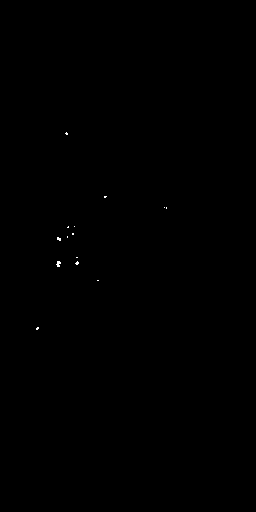

*********************


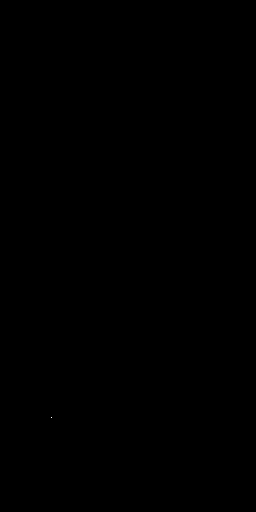

^^^^


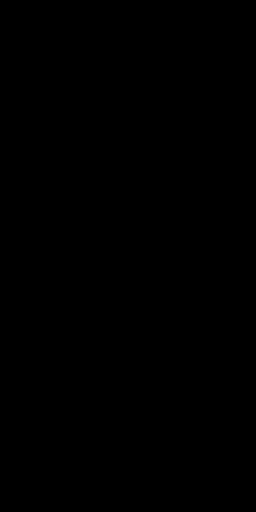

*********************


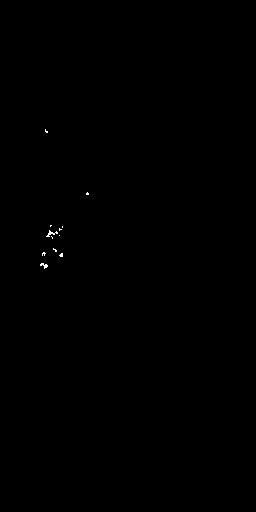

^^^^


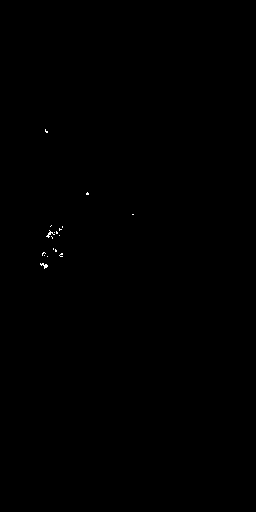

*********************


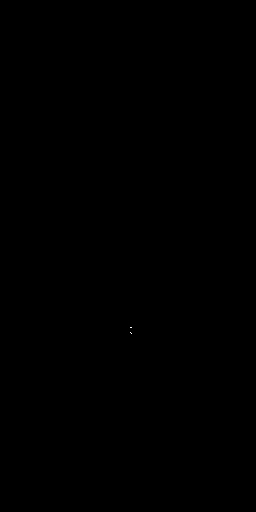

^^^^


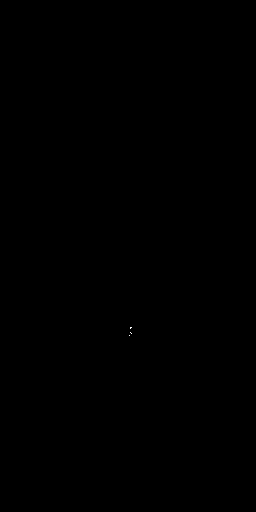

*********************


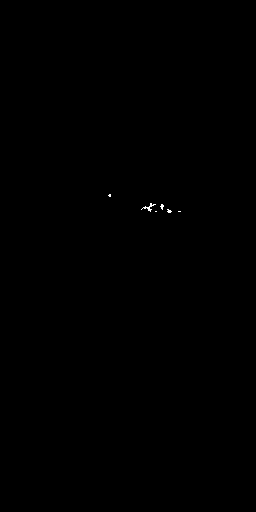

^^^^


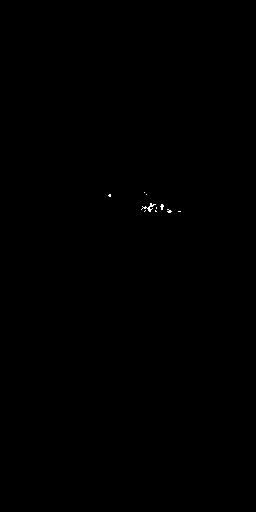

*********************


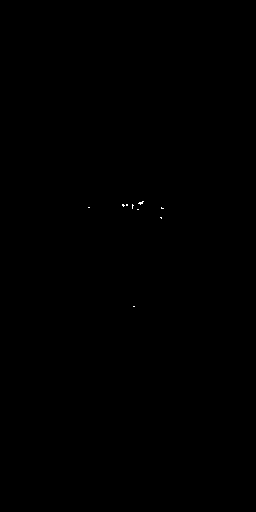

^^^^


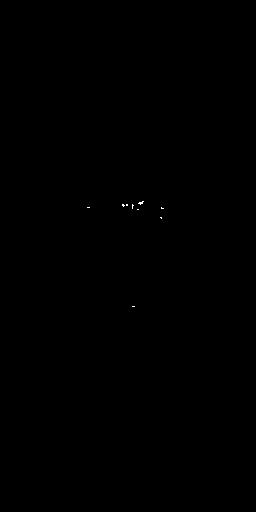

*********************


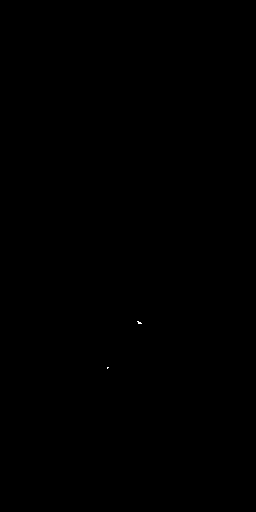

^^^^


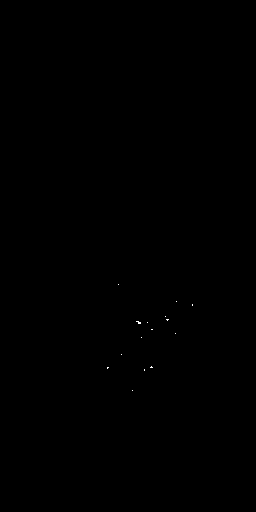

*********************


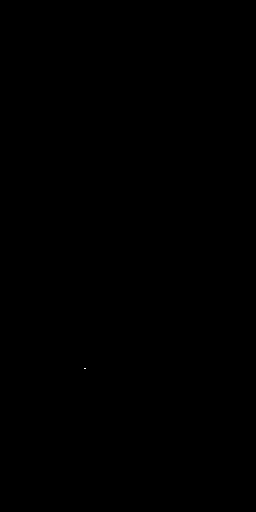

^^^^


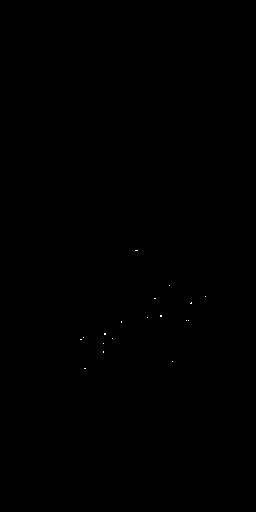

*********************


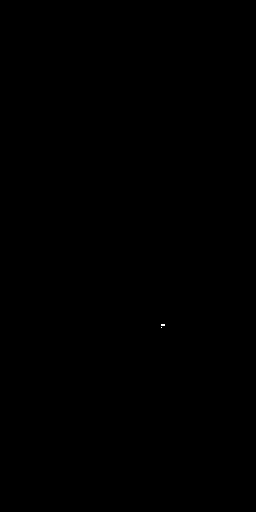

^^^^


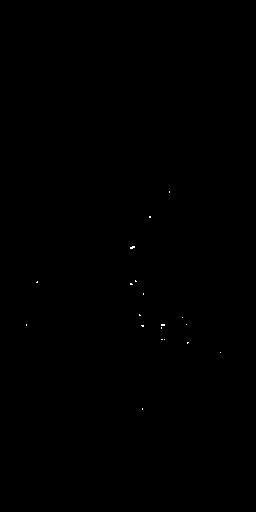

*********************


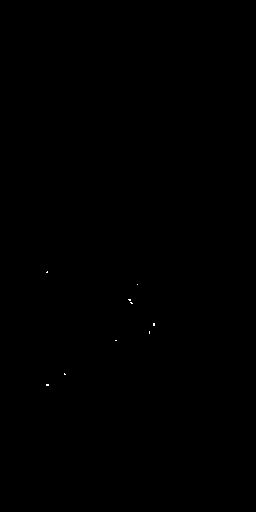

^^^^


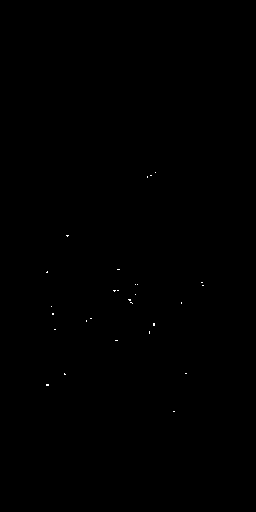

*********************


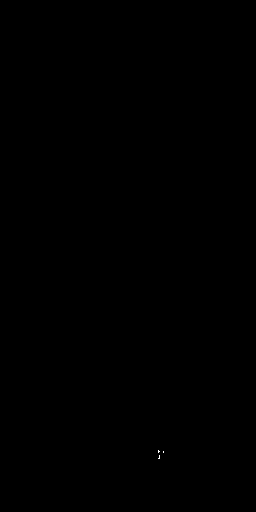

^^^^


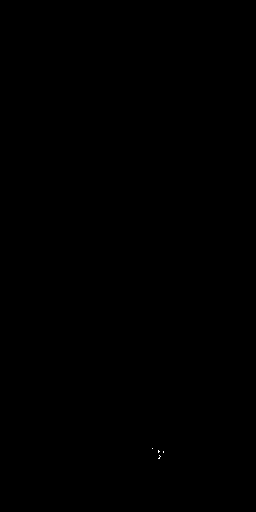

*********************


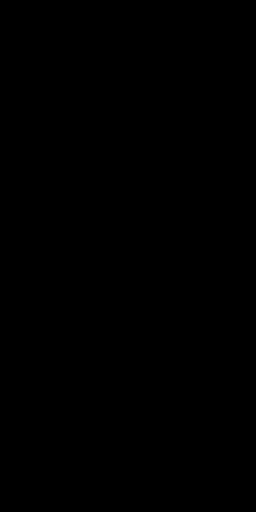

^^^^


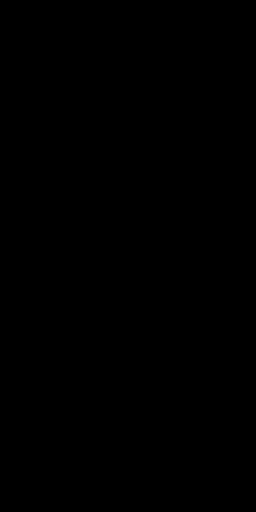

*********************


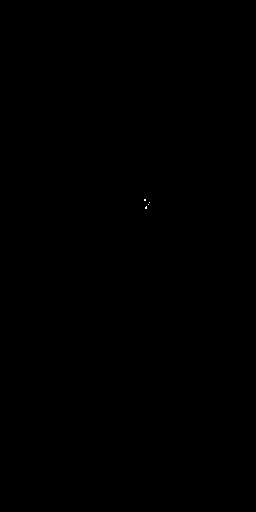

^^^^


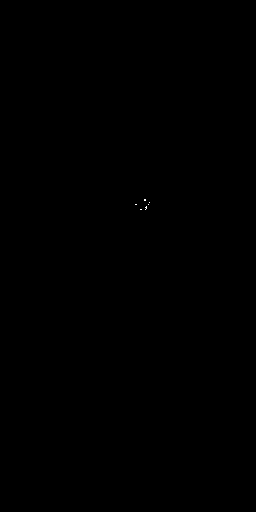

*********************


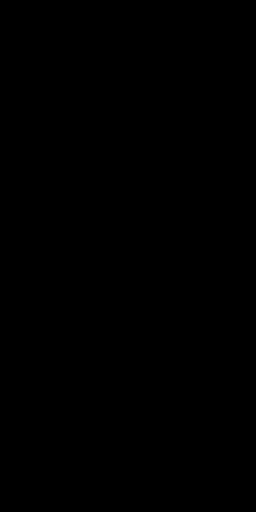

^^^^


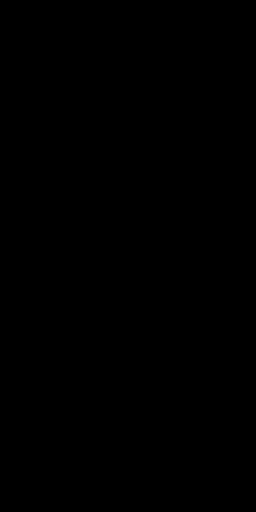

*********************


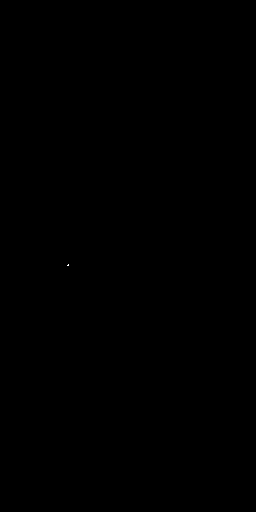

^^^^


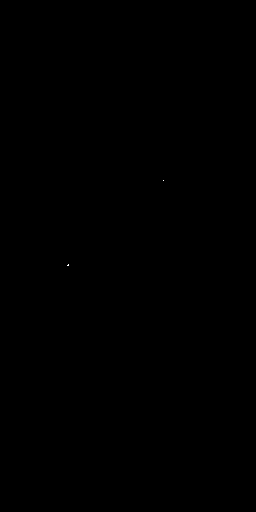

*********************


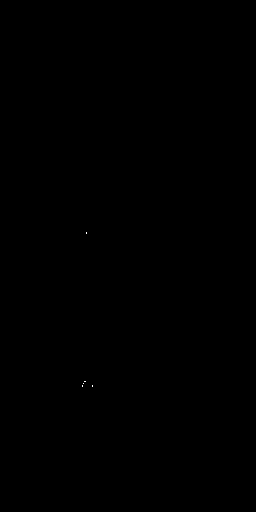

^^^^


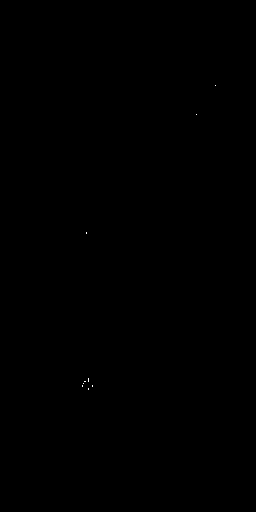

*********************


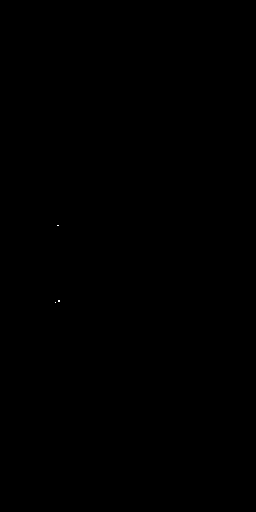

^^^^


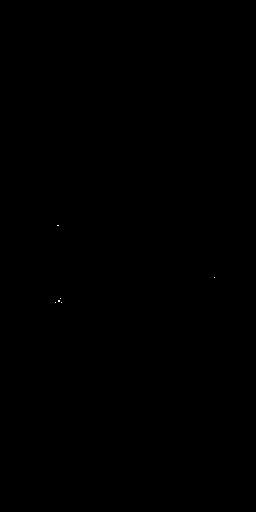

*********************


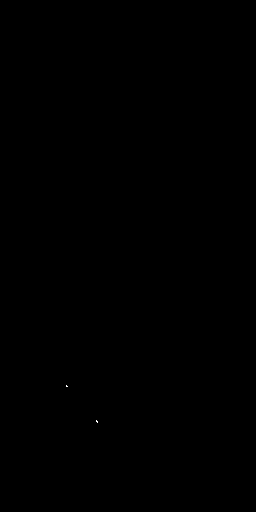

^^^^


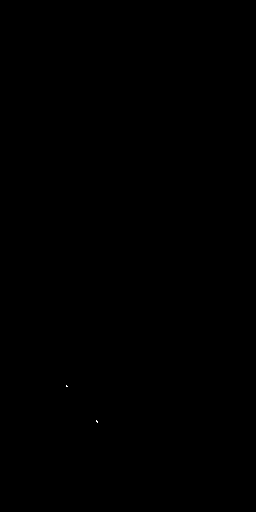

*********************


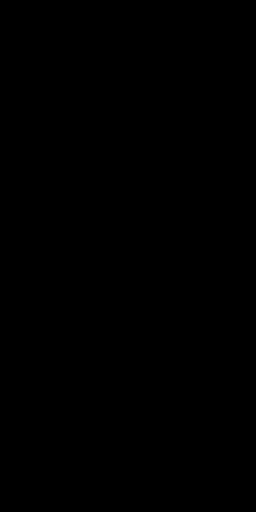

^^^^


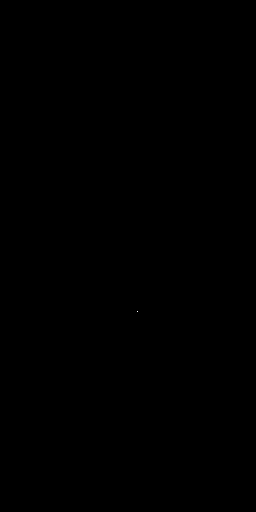

*********************


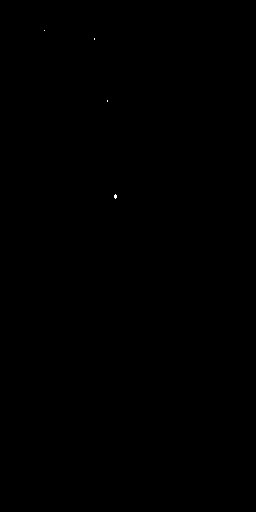

^^^^


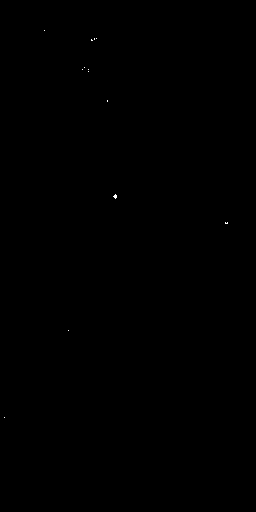

*********************


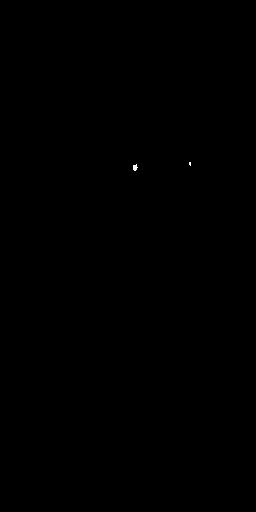

^^^^


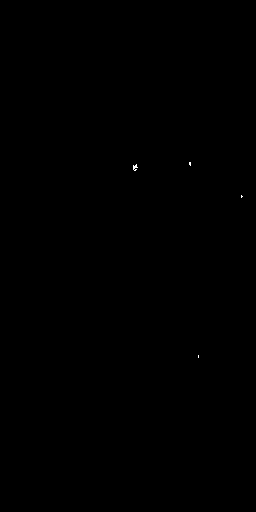

*********************


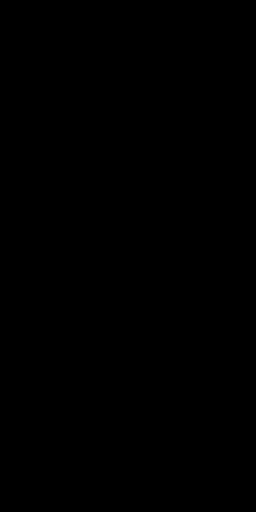

^^^^


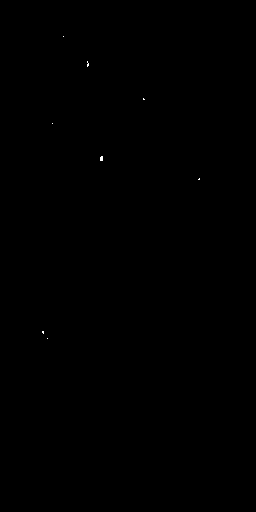

*********************


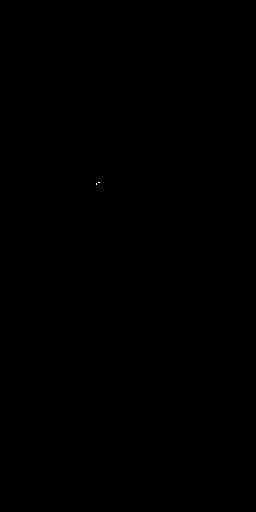

^^^^


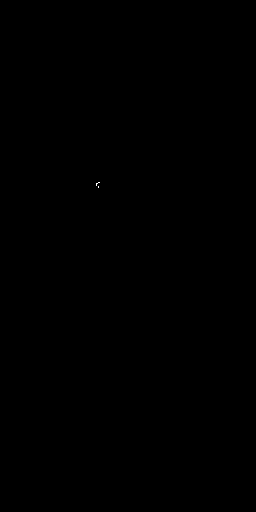

*********************


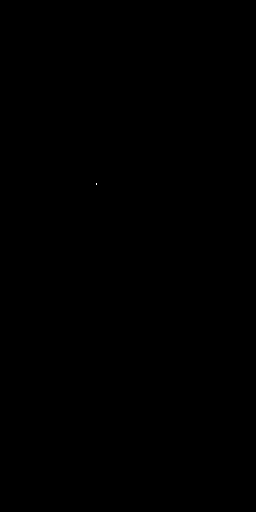

^^^^


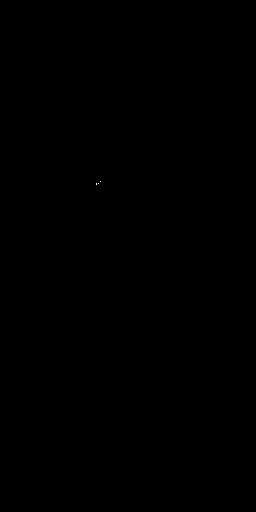

*********************


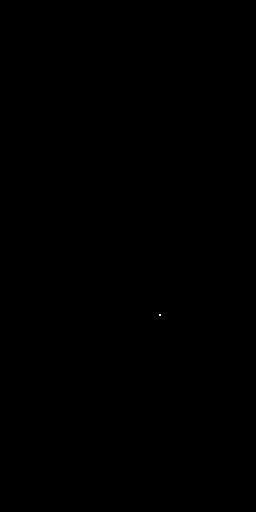

^^^^


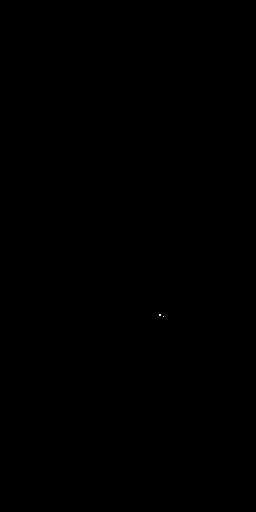

*********************


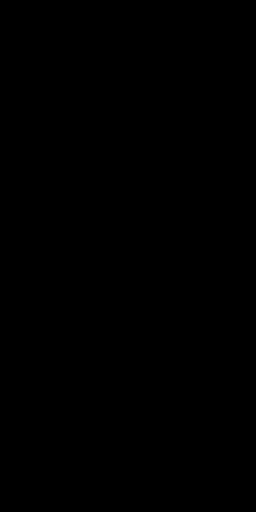

^^^^


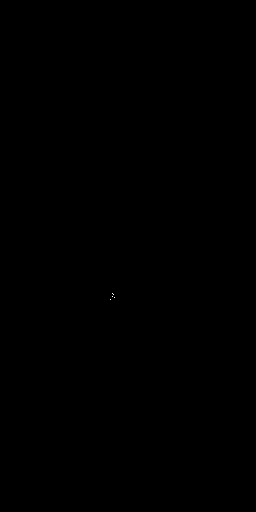

*********************


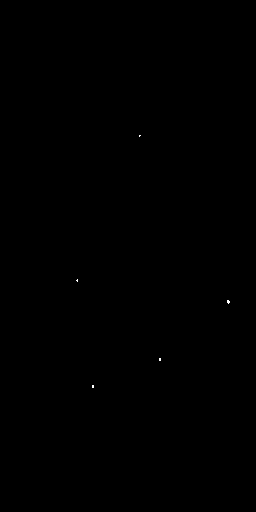

^^^^


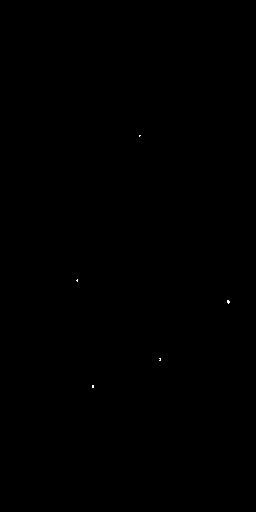

*********************


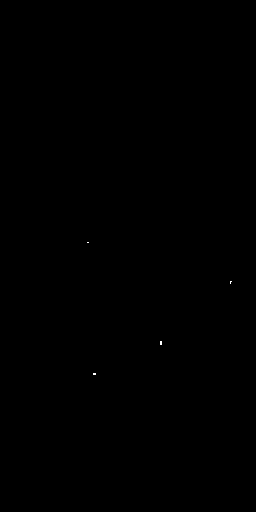

^^^^


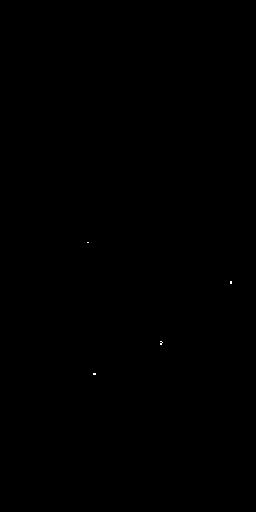

*********************


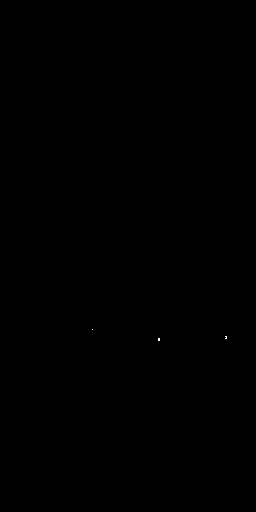

^^^^


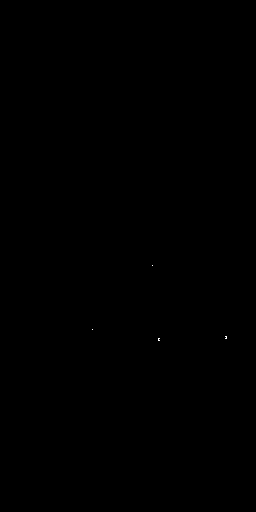

*********************


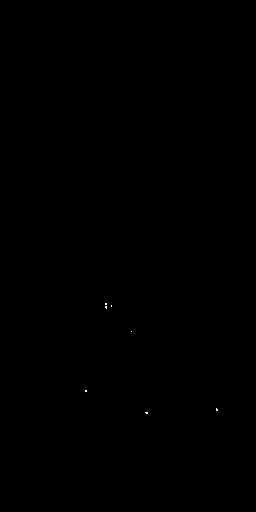

^^^^


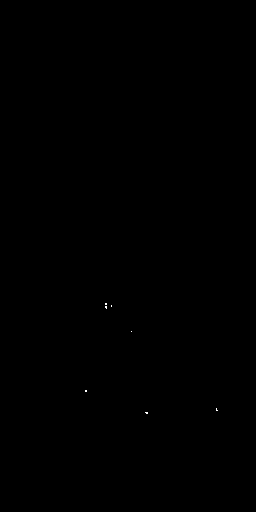

*********************


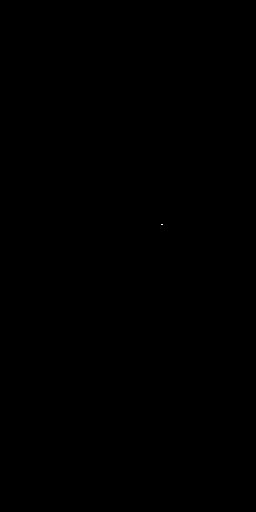

^^^^


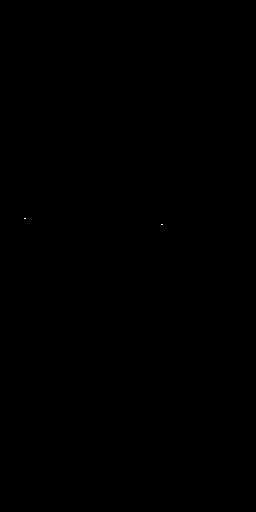

*********************


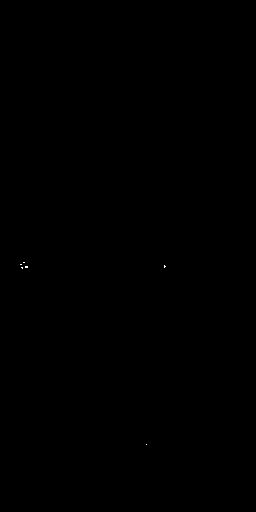

^^^^


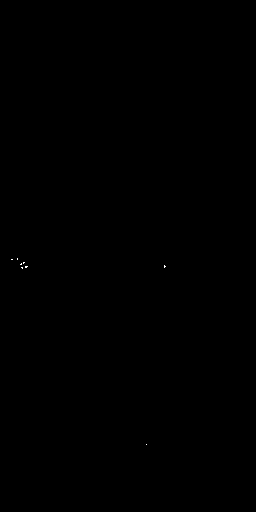

*********************


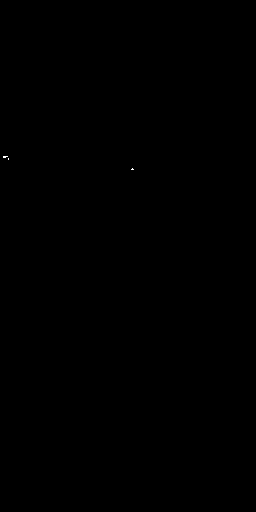

^^^^


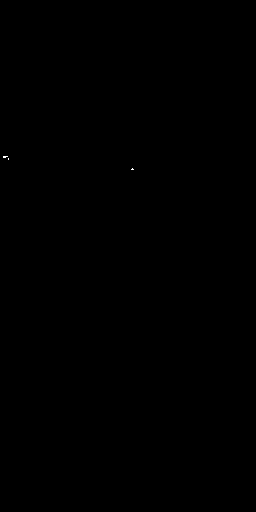

*********************


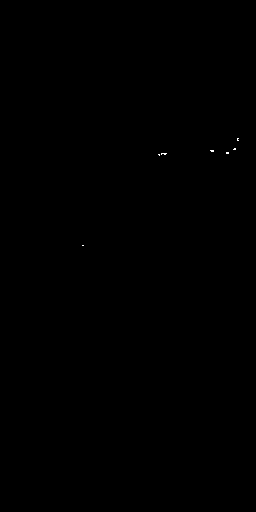

^^^^


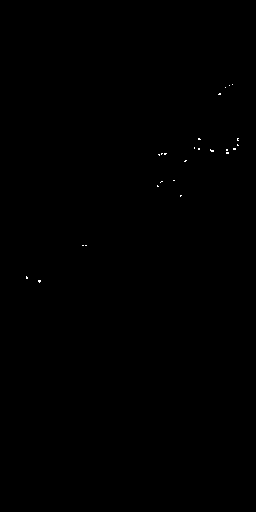

*********************


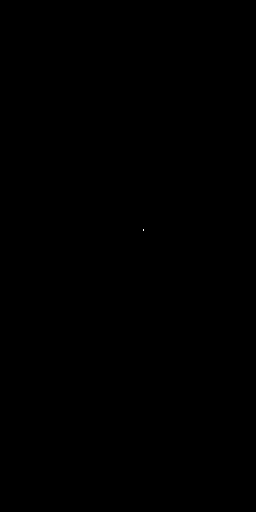

^^^^


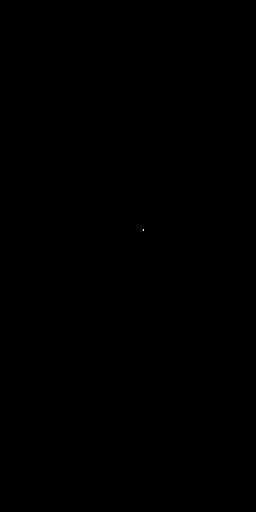

*********************


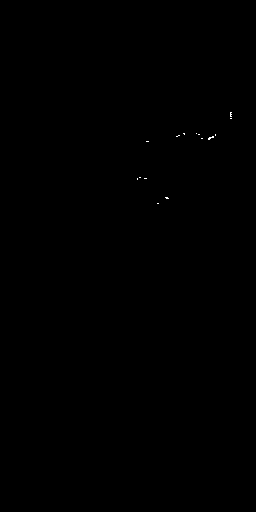

^^^^


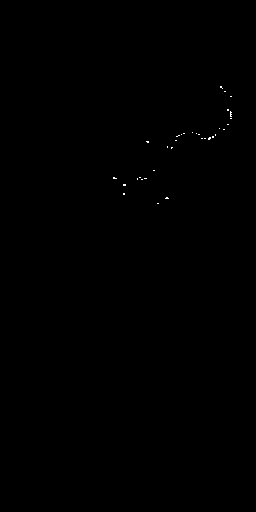

*********************


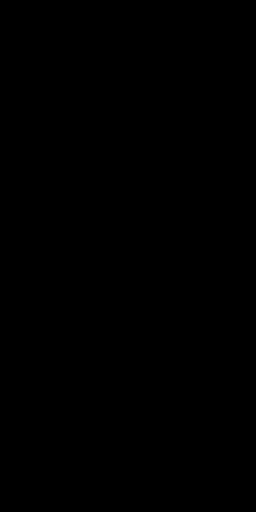

^^^^


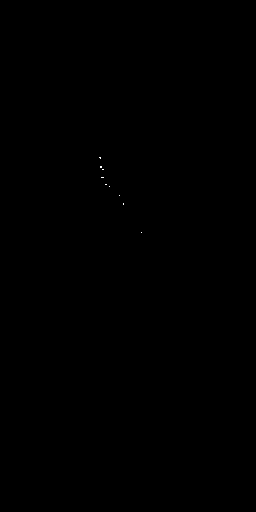

*********************


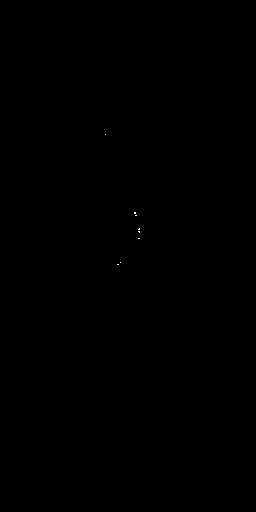

^^^^


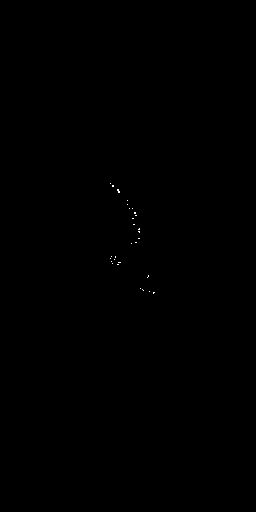

*********************


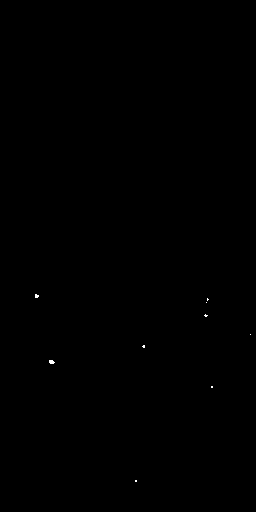

^^^^


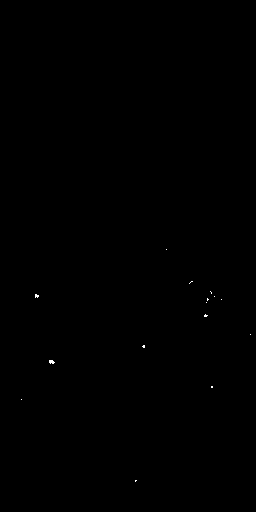

*********************


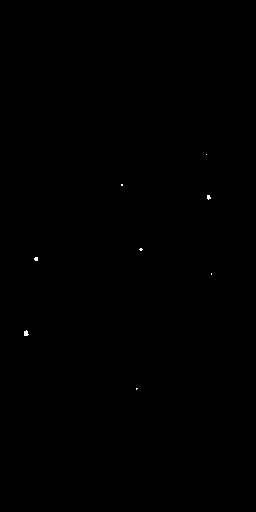

^^^^


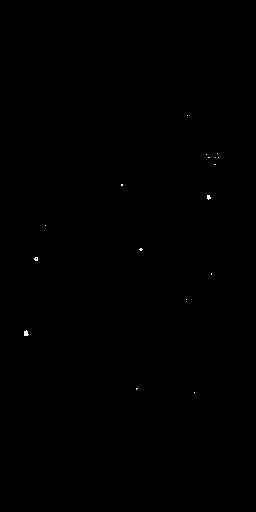

*********************


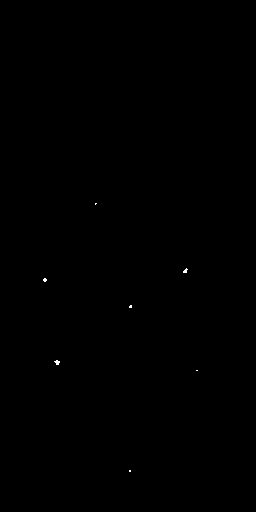

^^^^


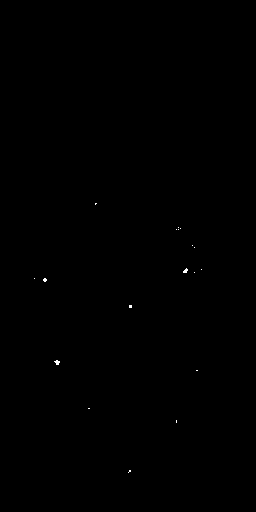

*********************


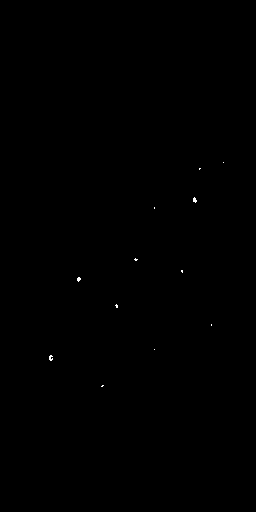

^^^^


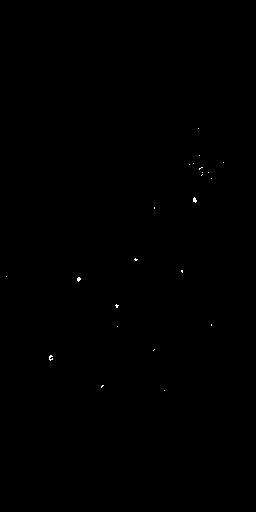

*********************


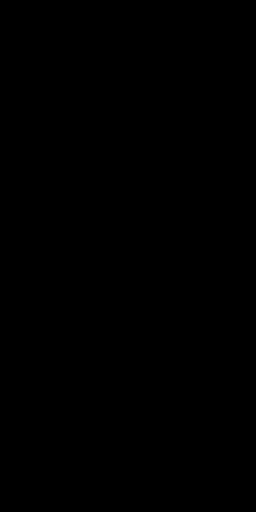

^^^^


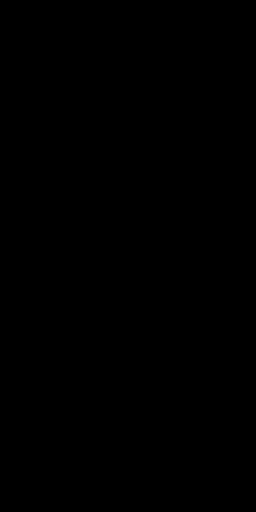

*********************


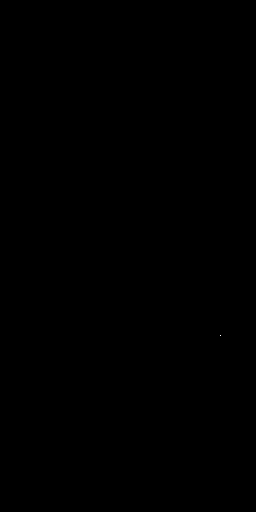

^^^^


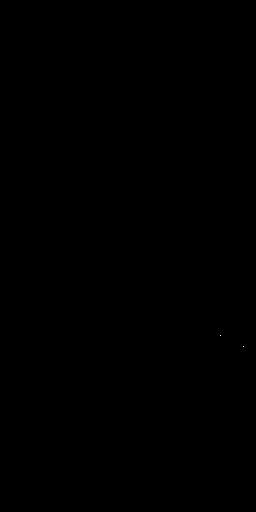

*********************


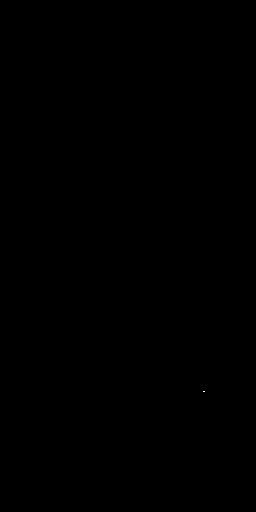

^^^^


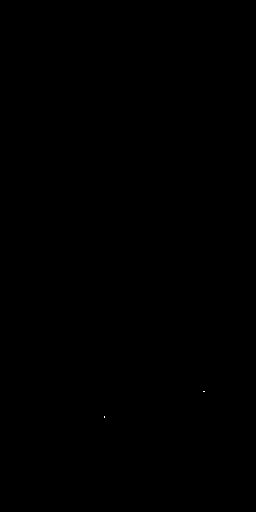

*********************


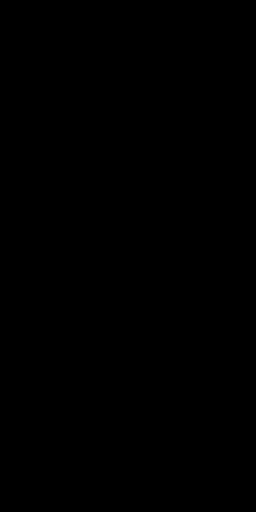

^^^^


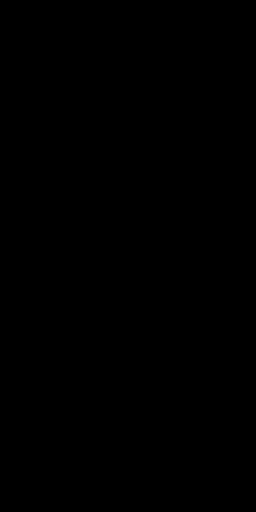

*********************


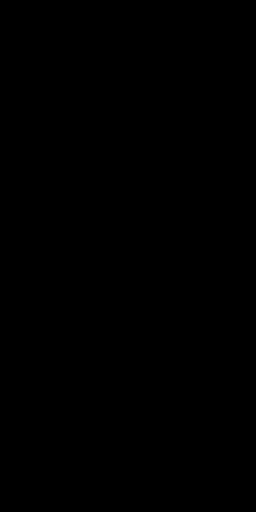

^^^^


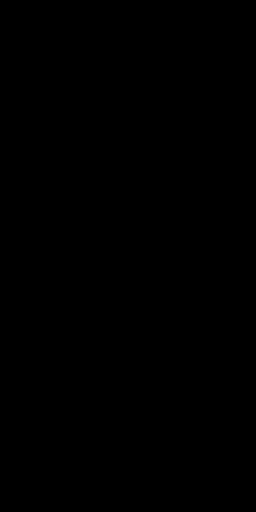

*********************


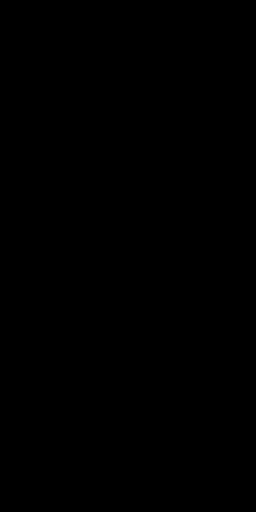

^^^^


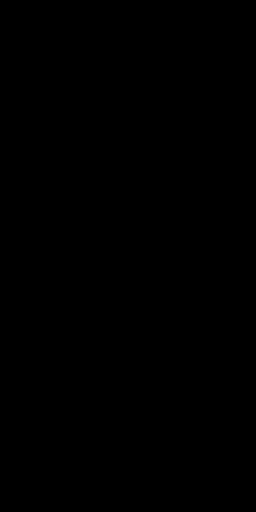

*********************


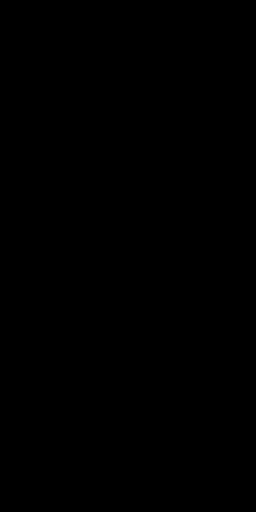

^^^^


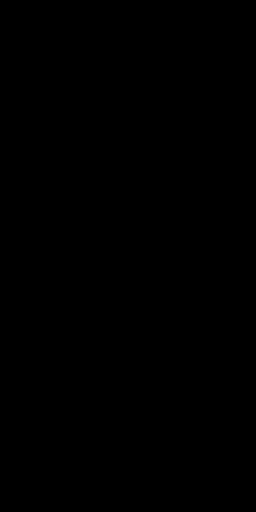

*********************


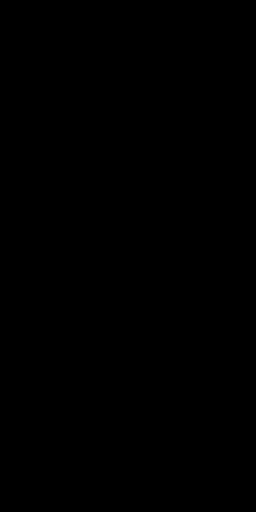

^^^^


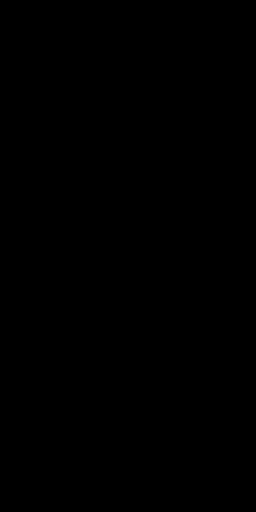

*********************


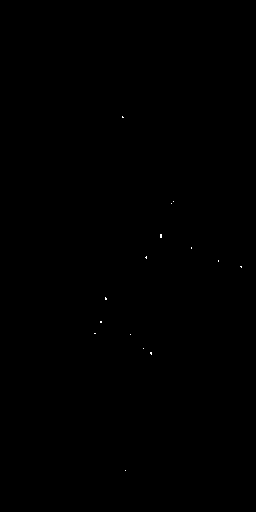

^^^^


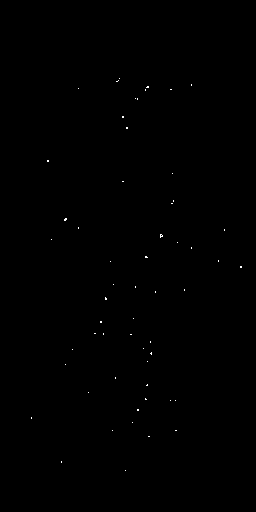

*********************


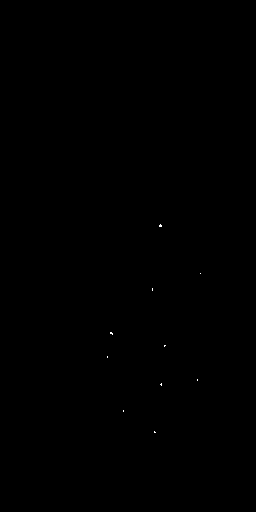

^^^^


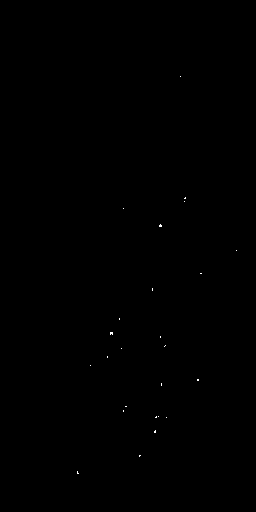

*********************


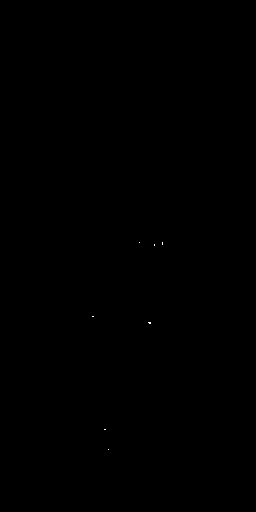

^^^^


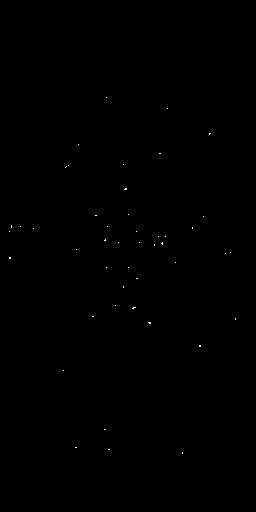

*********************


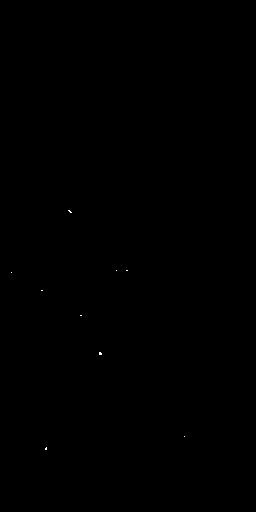

^^^^


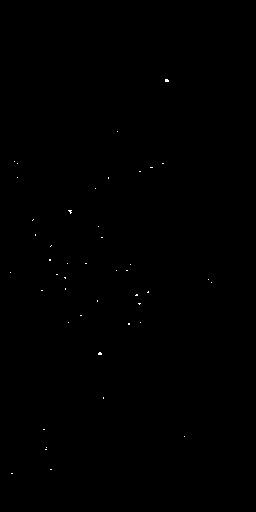

*********************


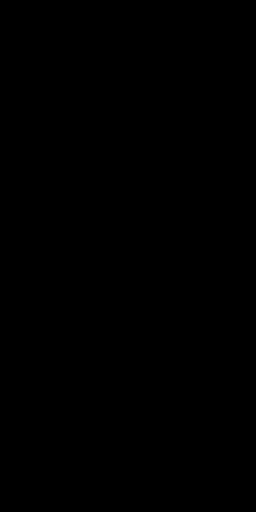

^^^^


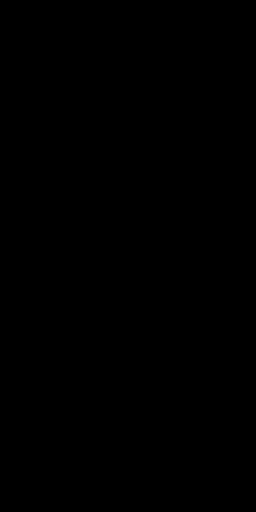

*********************


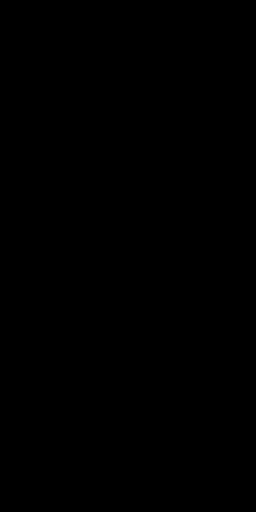

^^^^


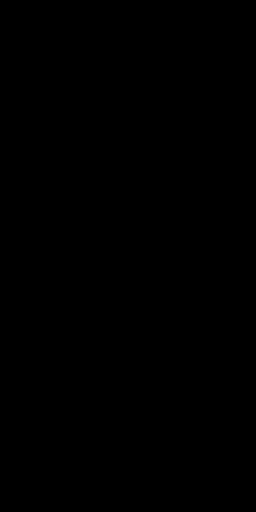

*********************


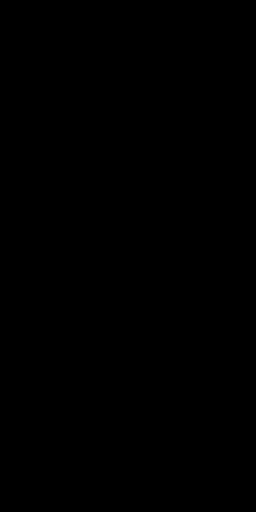

^^^^


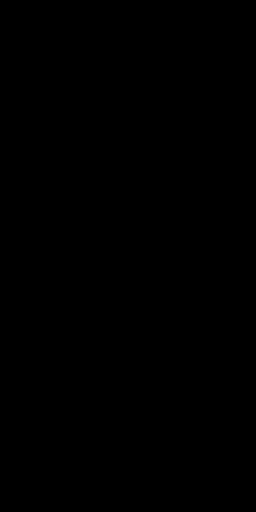

*********************


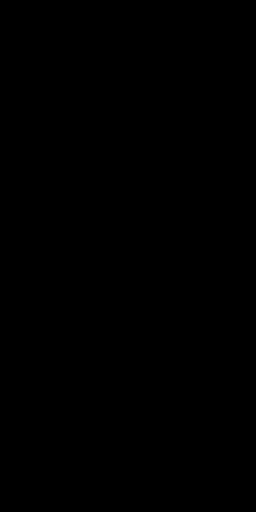

^^^^


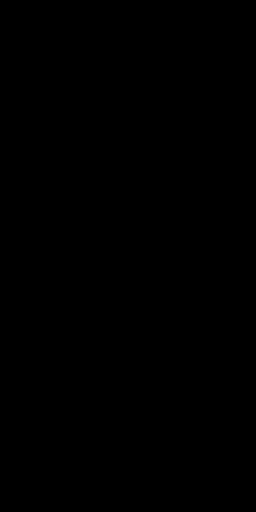

*********************


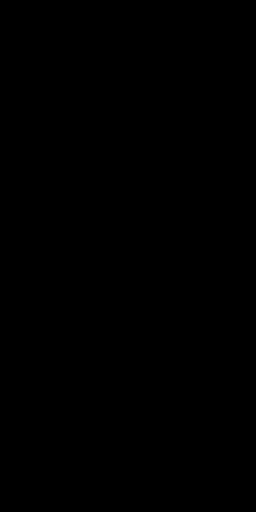

^^^^


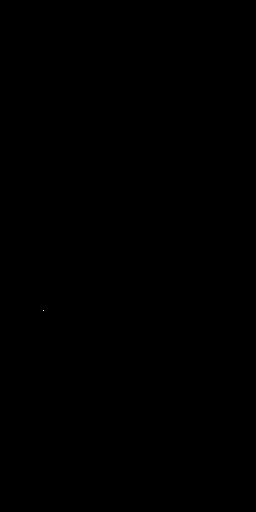

*********************


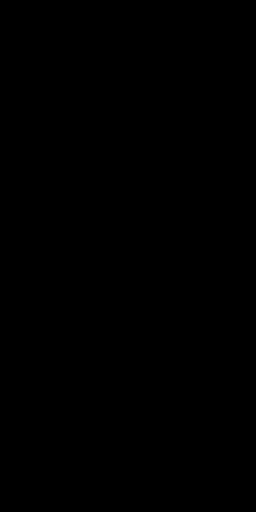

^^^^


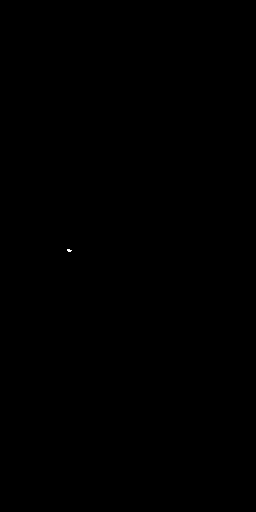

*********************


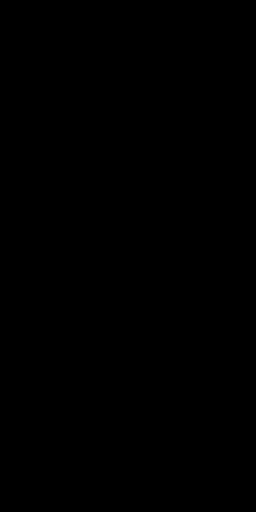

^^^^


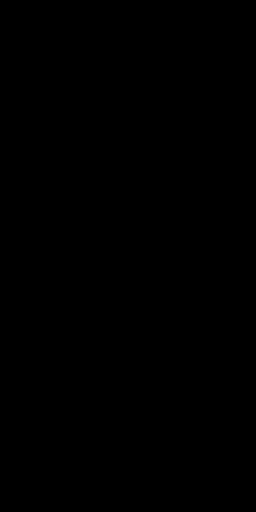

*********************


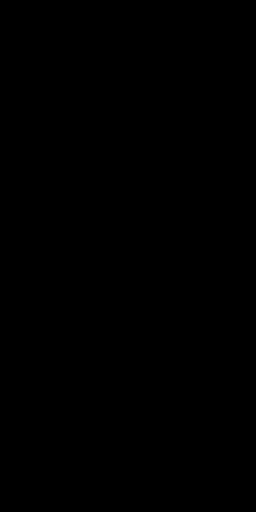

^^^^


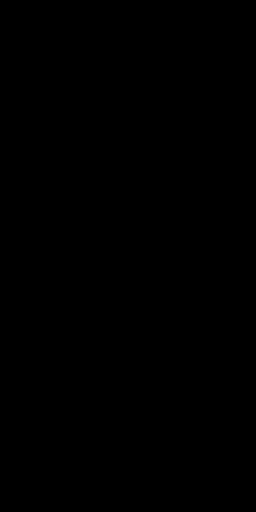

*********************


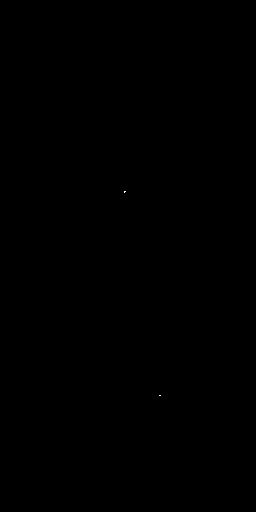

^^^^


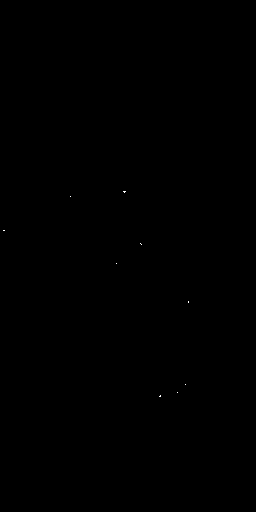

*********************


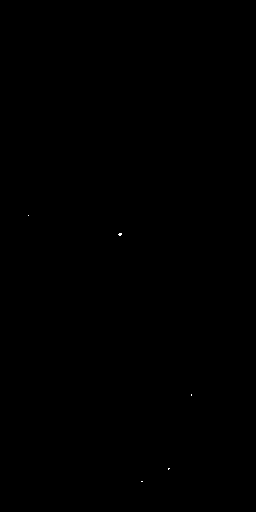

^^^^


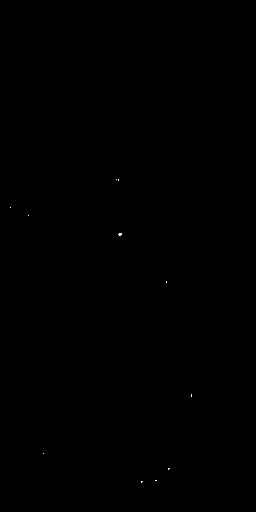

*********************


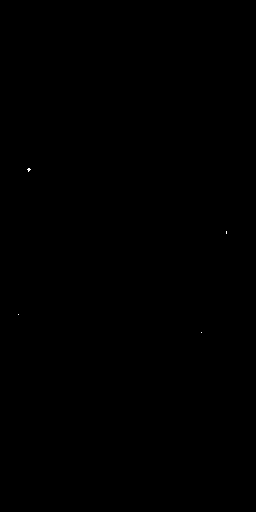

^^^^


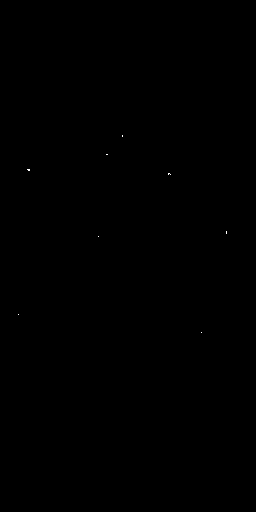

*********************


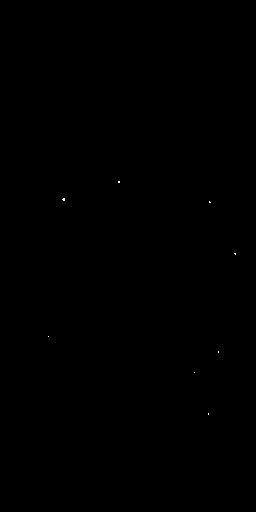

^^^^


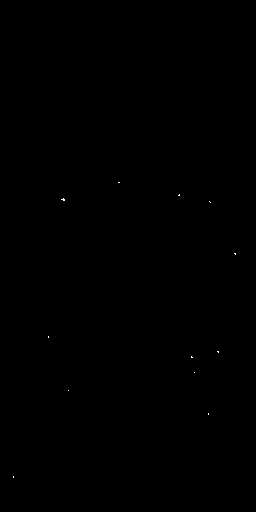

*********************


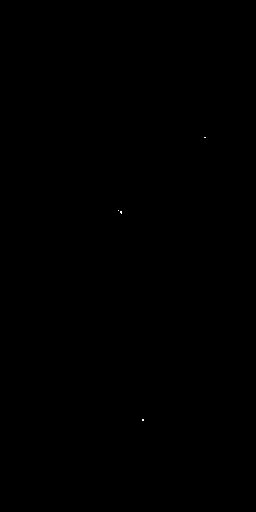

^^^^


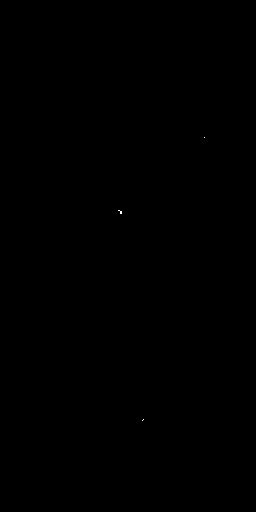

*********************


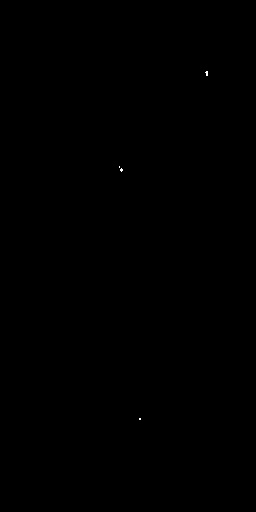

^^^^


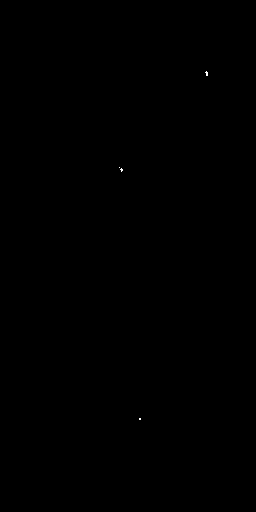

*********************


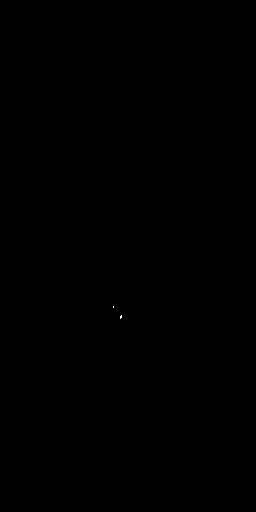

^^^^


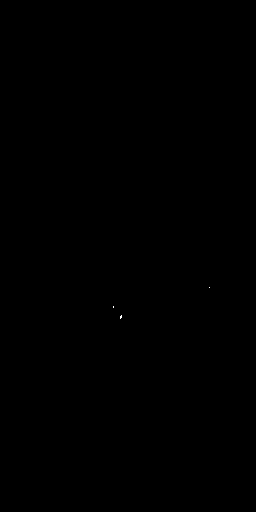

*********************


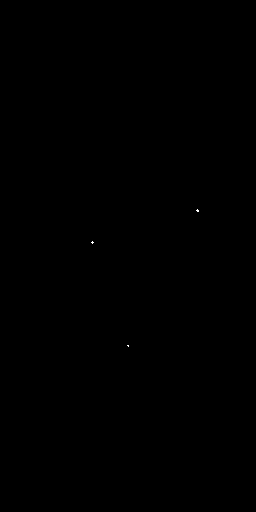

^^^^


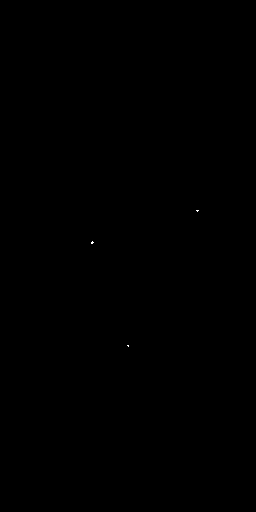

*********************


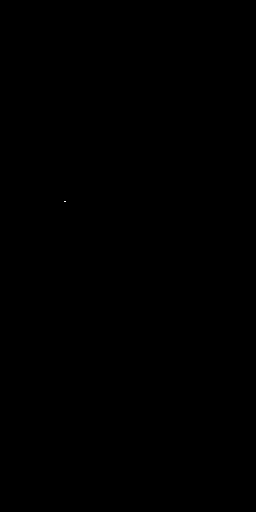

^^^^


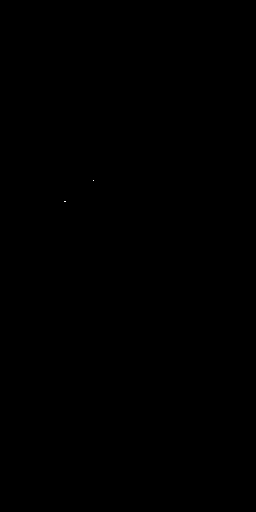

*********************


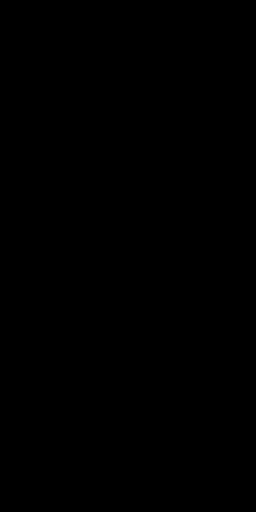

^^^^


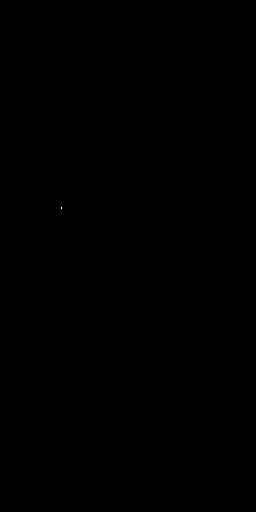

*********************


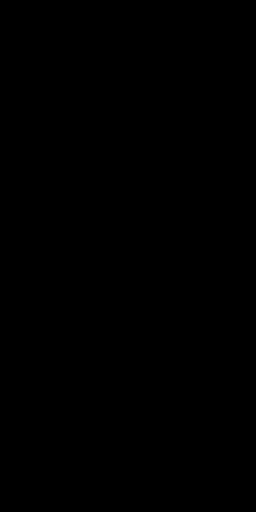

^^^^


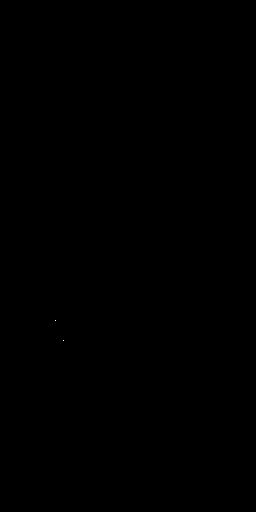

*********************


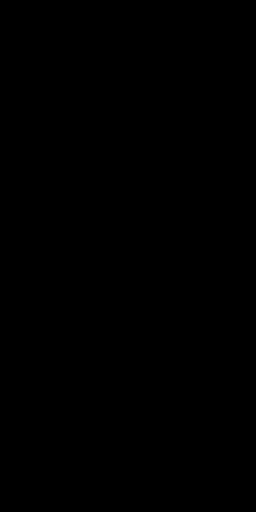

^^^^


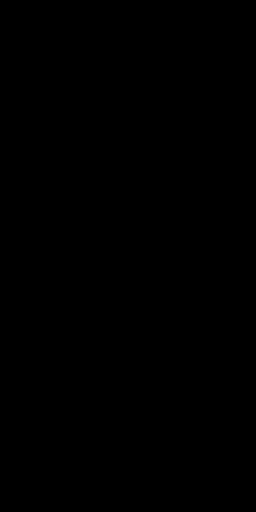

*********************


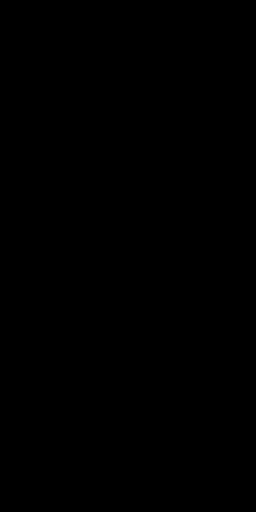

^^^^


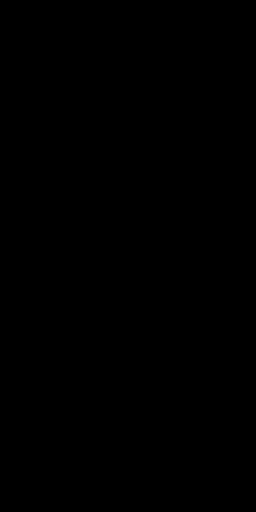

*********************


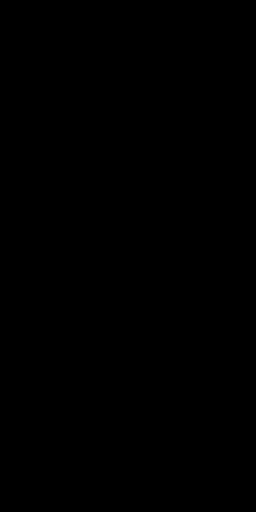

^^^^


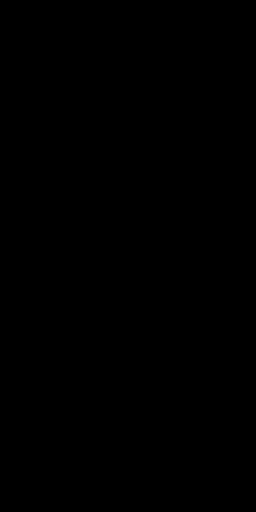

*********************


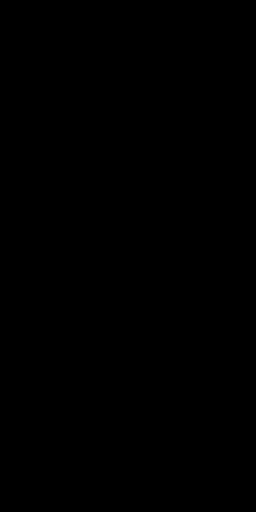

^^^^


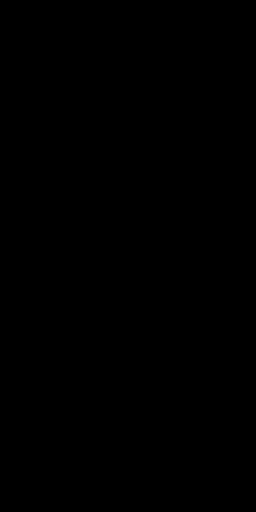

*********************


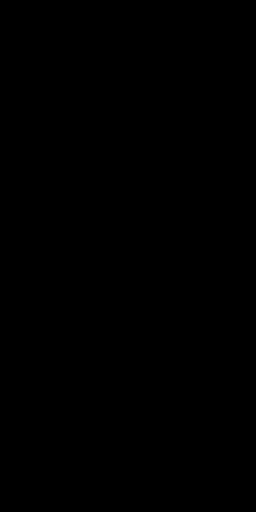

^^^^


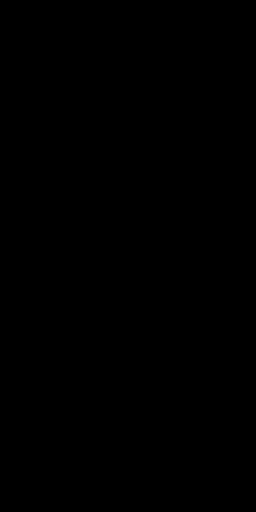

*********************


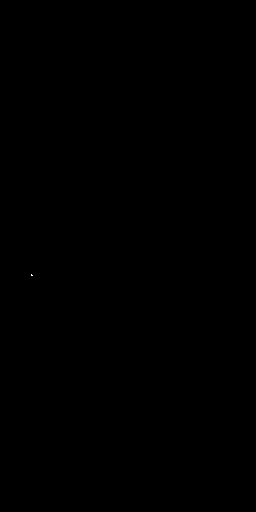

^^^^


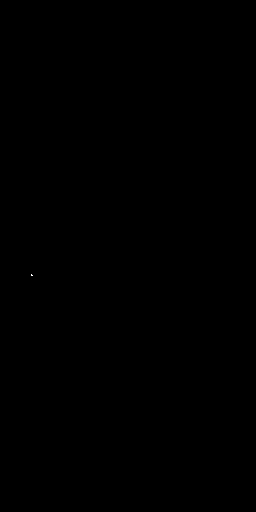

*********************


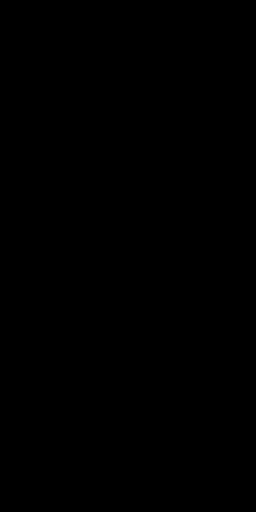

^^^^


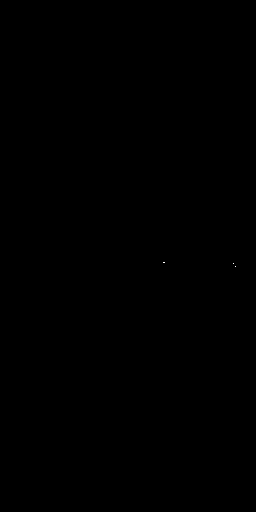

*********************


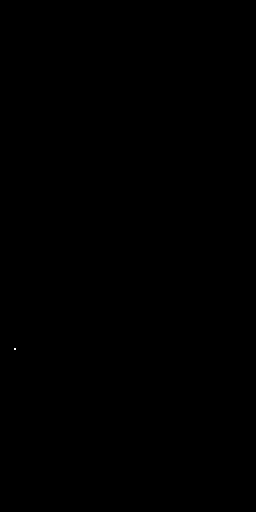

^^^^


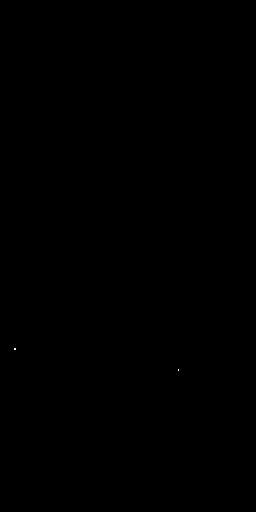

*********************


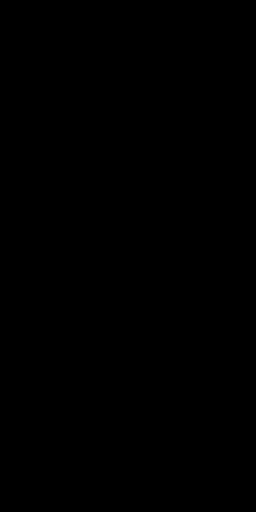

^^^^


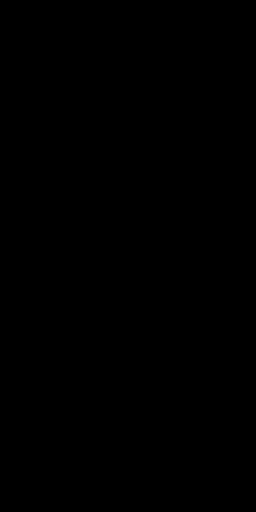

*********************


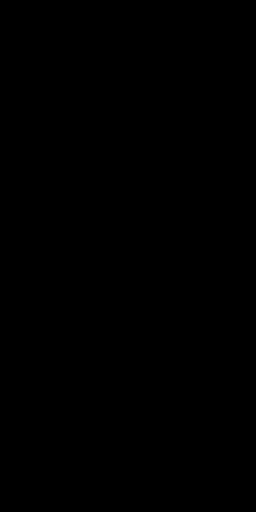

^^^^


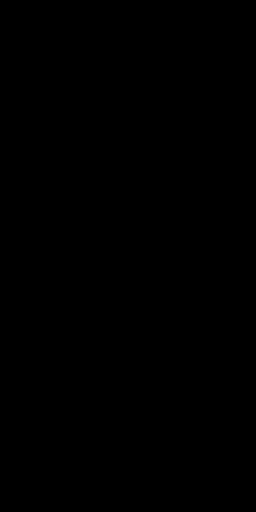

*********************


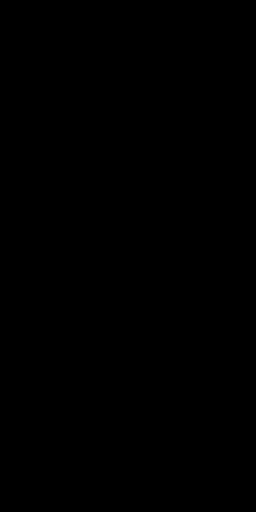

^^^^


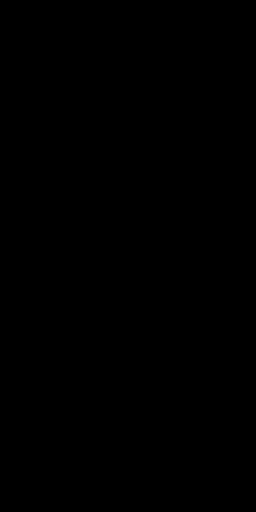

*********************


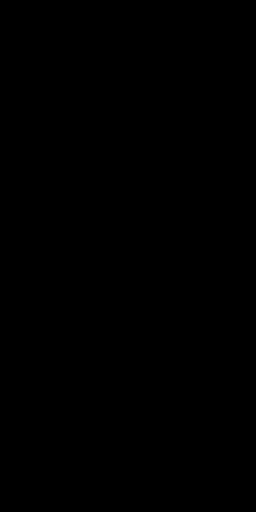

^^^^


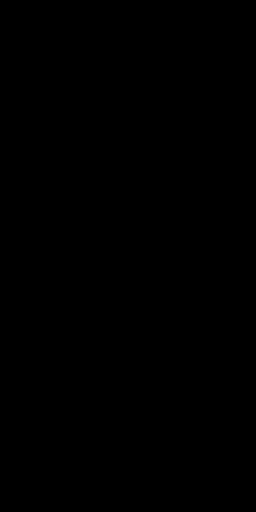

*********************


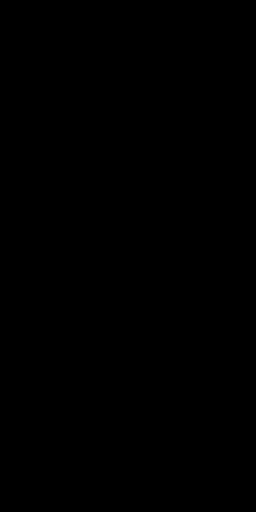

^^^^


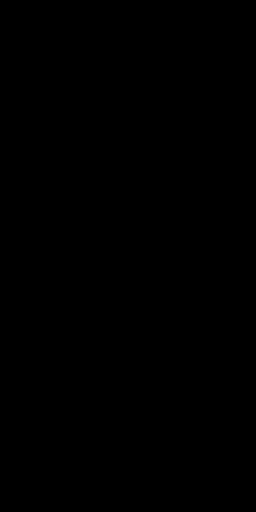

*********************


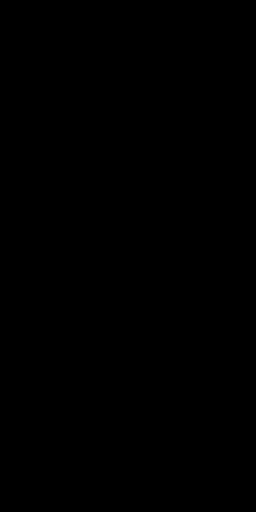

^^^^


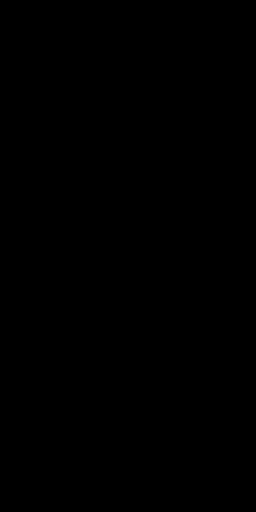

*********************


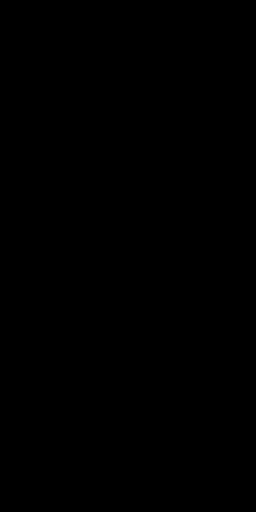

^^^^


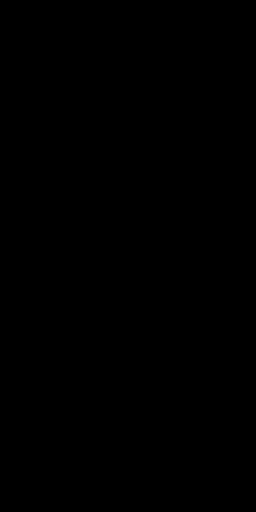

*********************


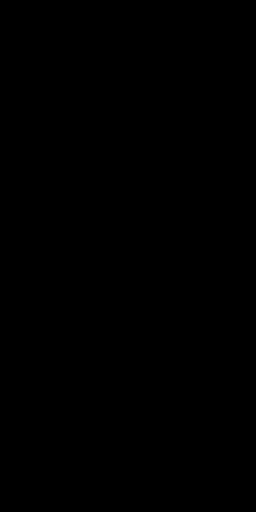

^^^^


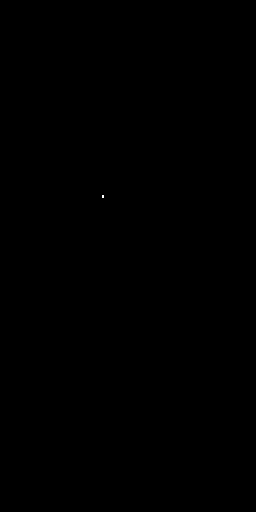

*********************


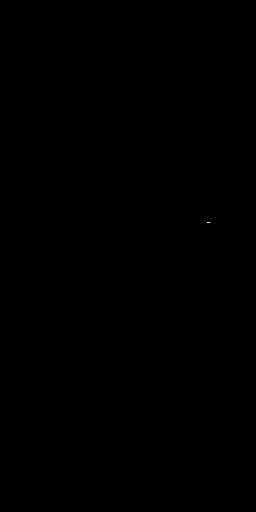

^^^^


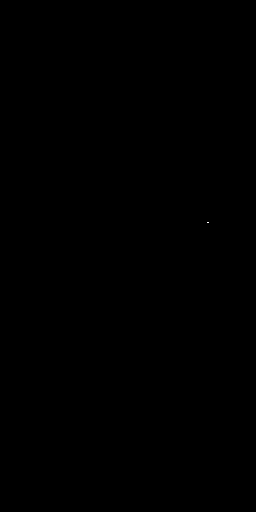

*********************


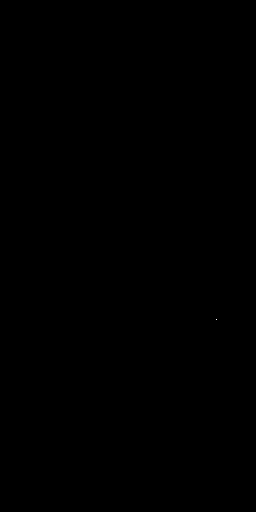

^^^^


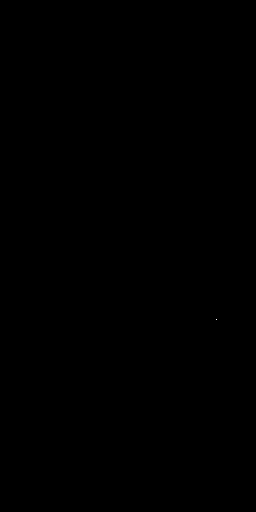

*********************


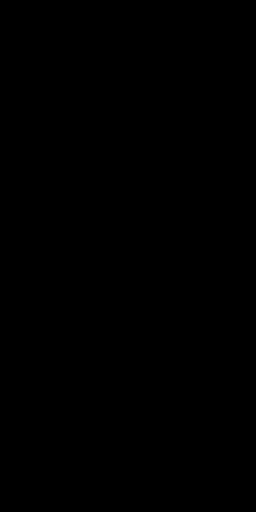

^^^^


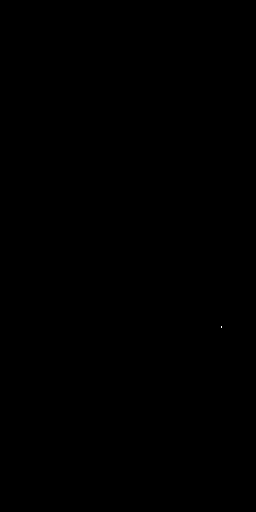

*********************


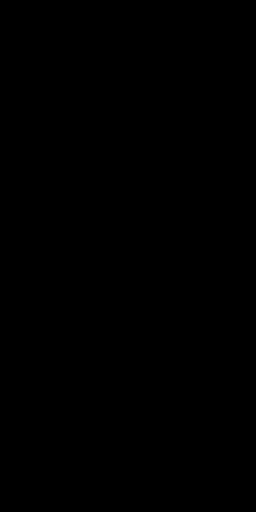

^^^^


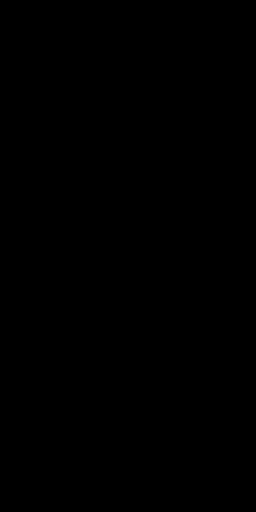

*********************


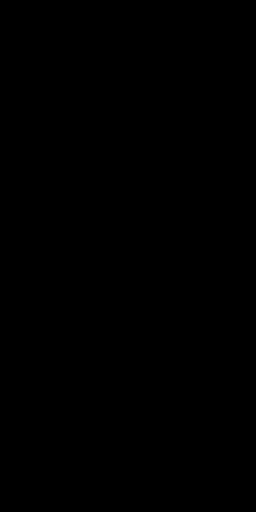

^^^^


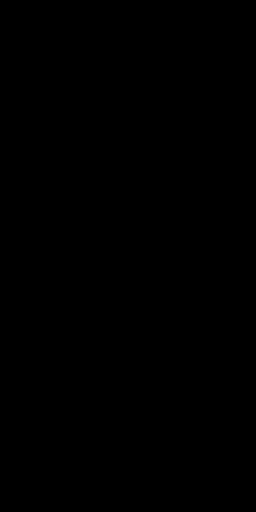

*********************


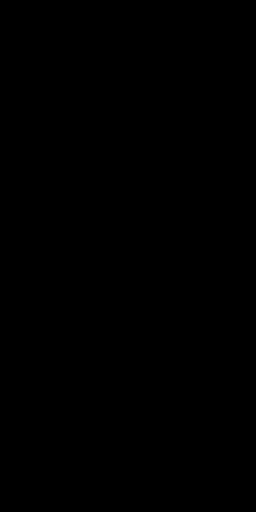

^^^^


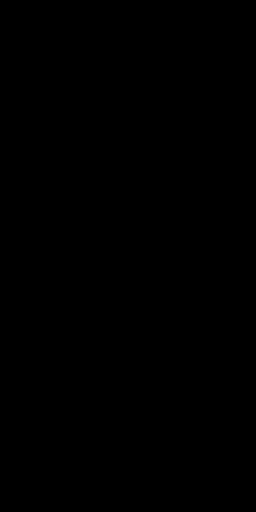

*********************


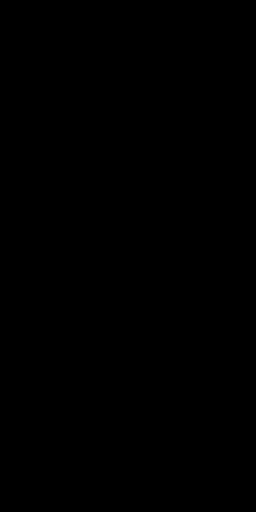

^^^^


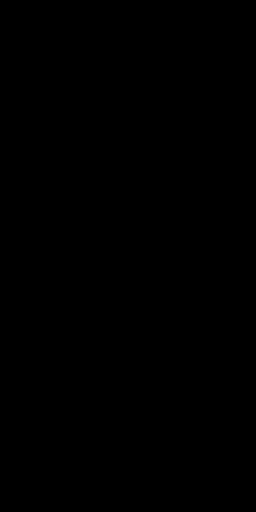

*********************


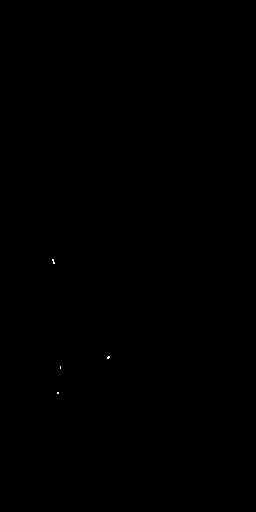

^^^^


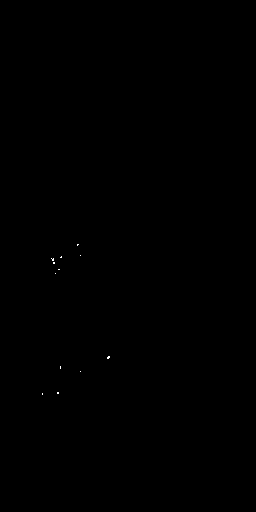

*********************


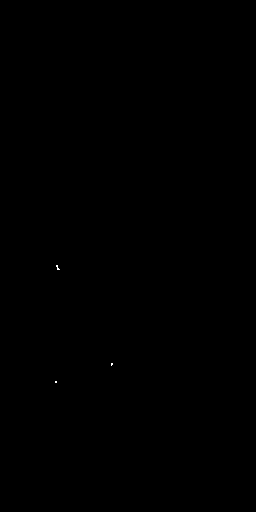

^^^^


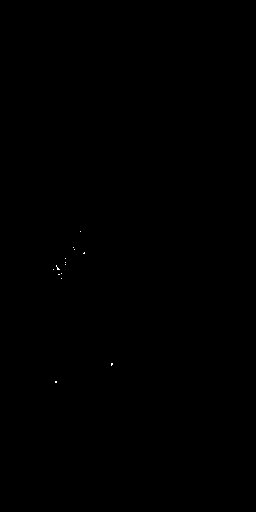

*********************


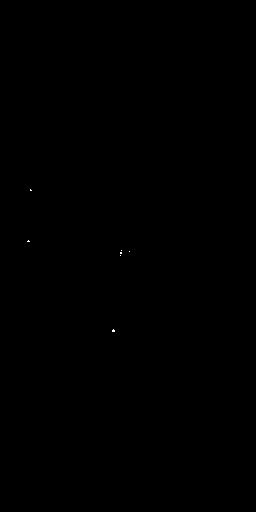

^^^^


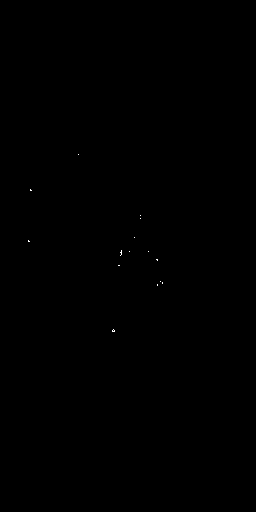

*********************


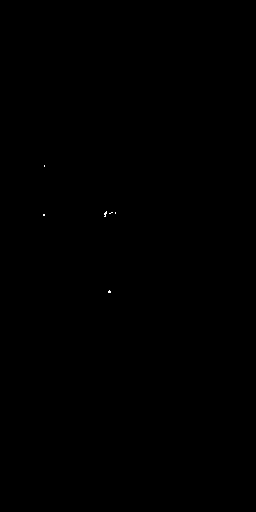

^^^^


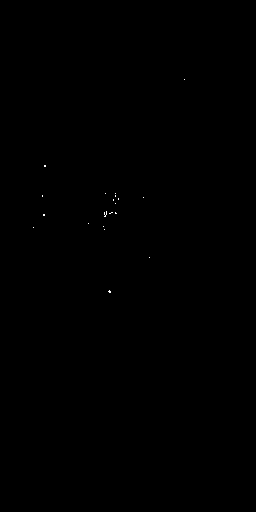

*********************


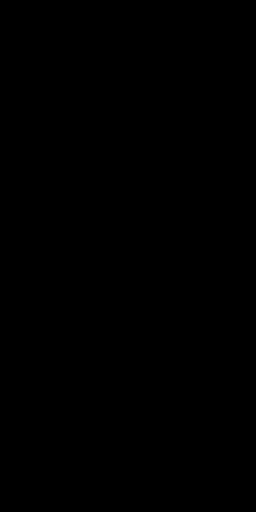

^^^^


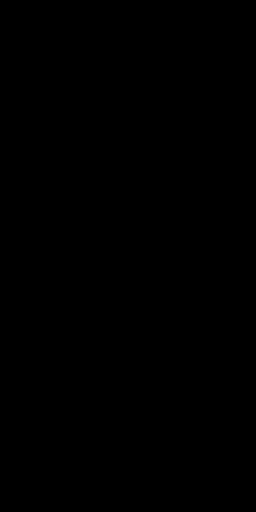

*********************


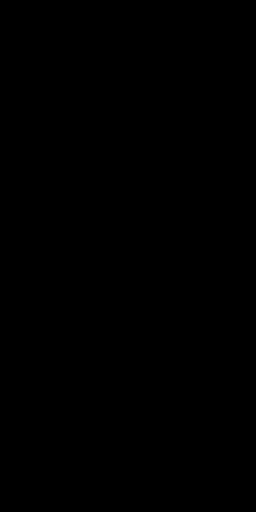

^^^^


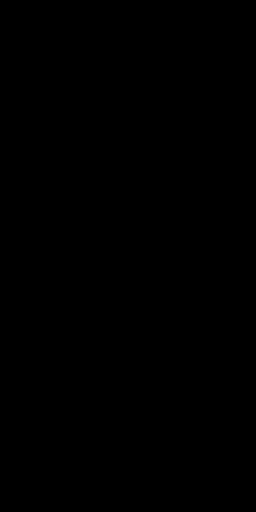

*********************


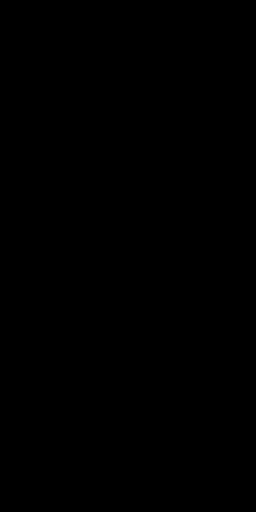

^^^^


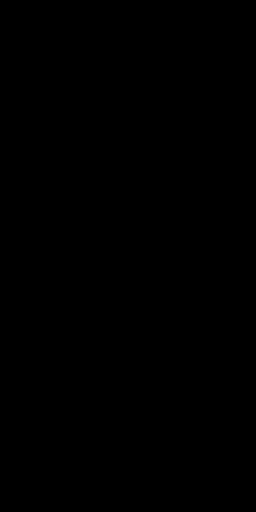

*********************


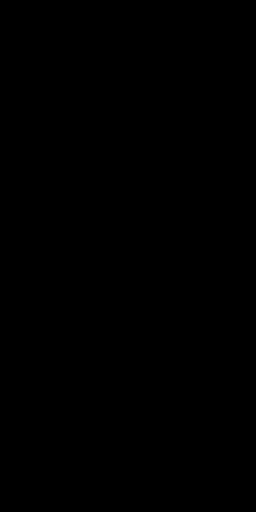

^^^^


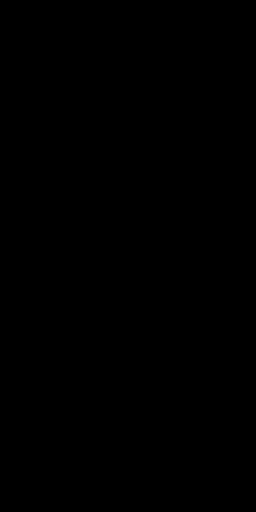

*********************


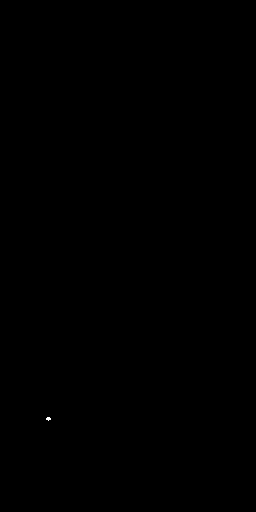

^^^^


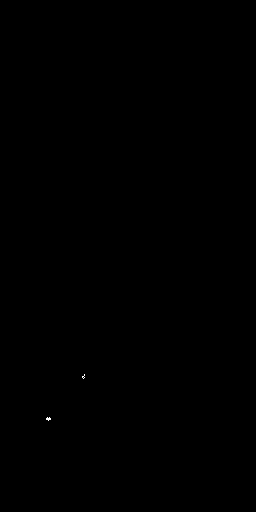

*********************


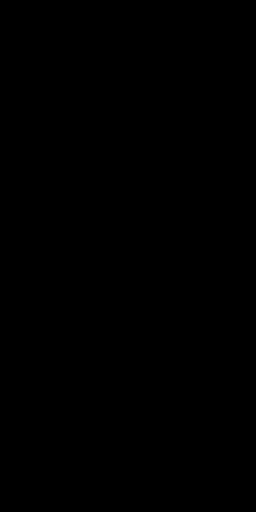

^^^^


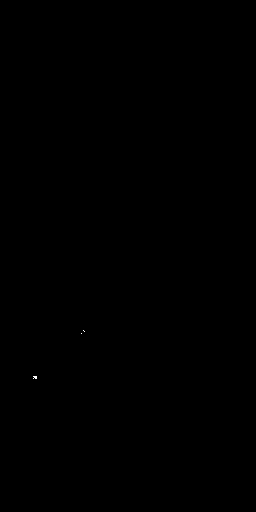

*********************


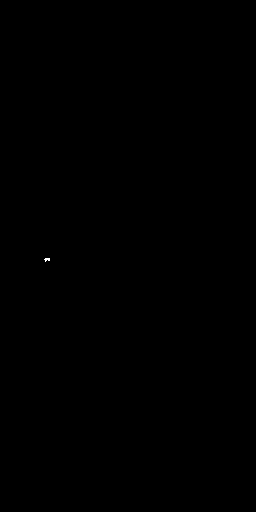

^^^^


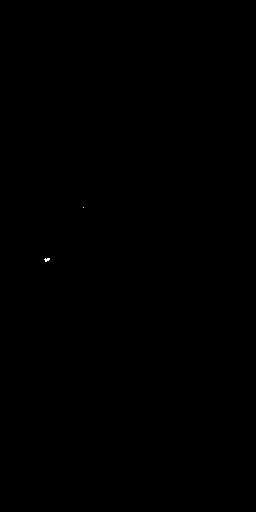

*********************


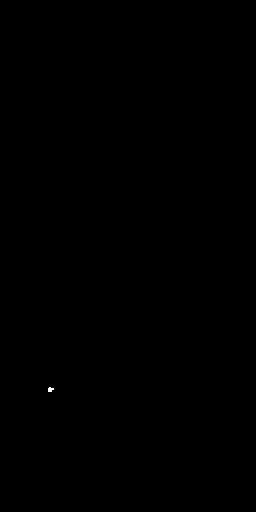

^^^^


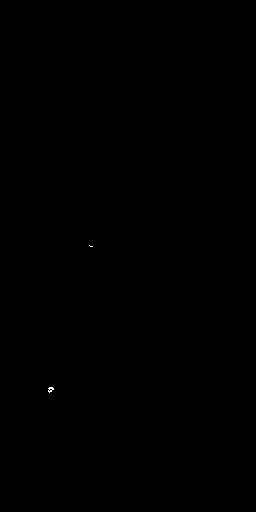

*********************


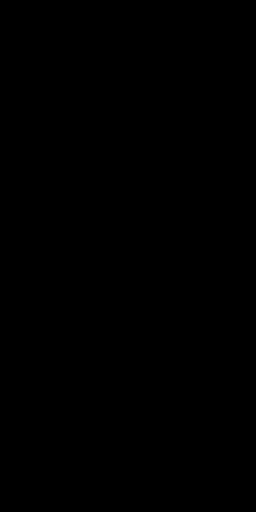

^^^^


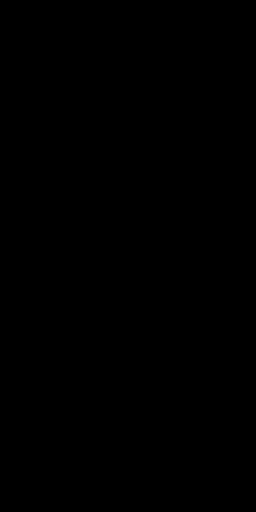

*********************


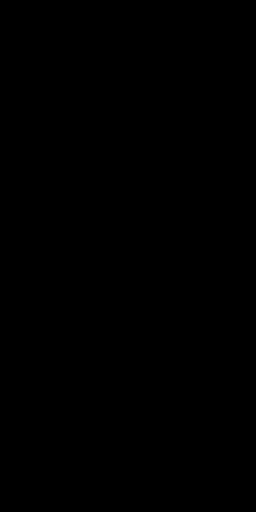

^^^^


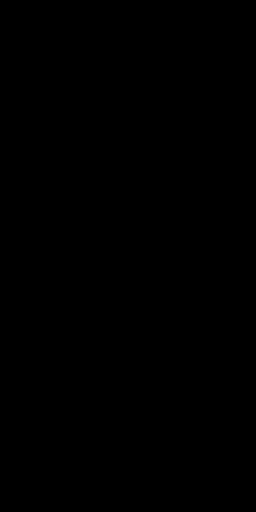

*********************


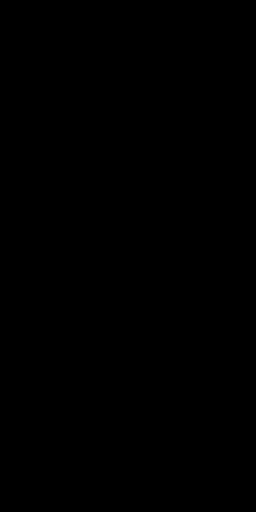

^^^^


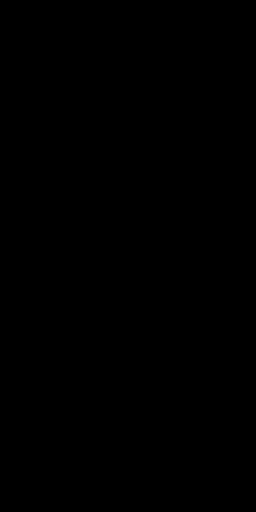

*********************


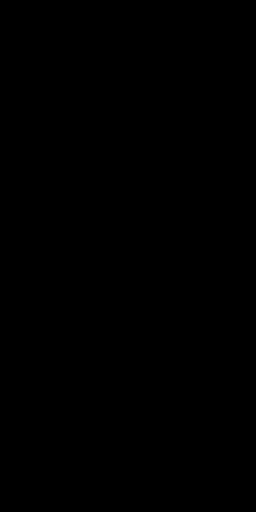

^^^^


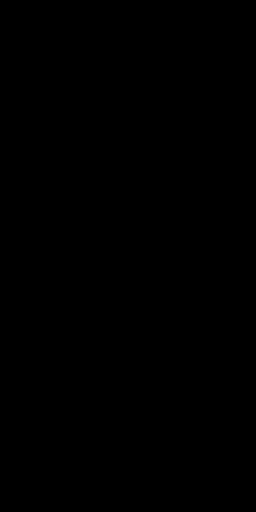

*********************


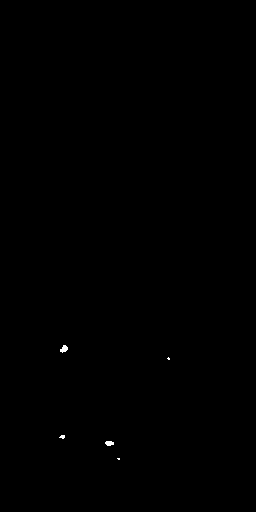

^^^^


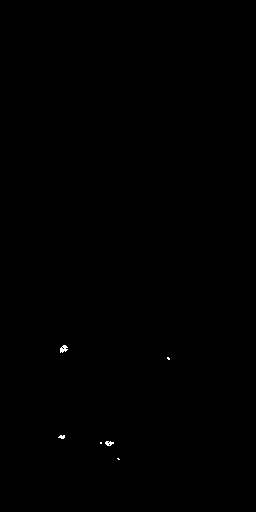

*********************


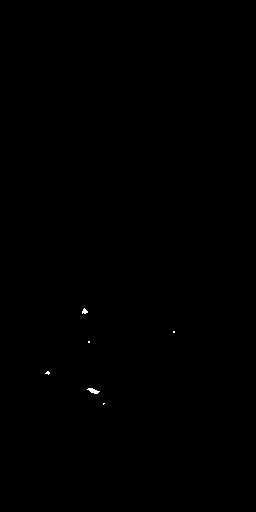

^^^^


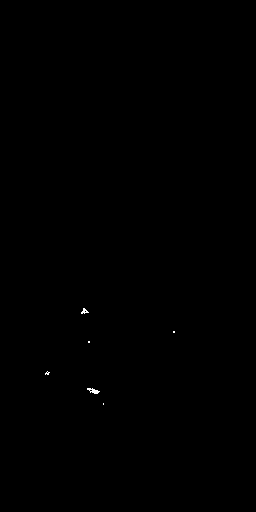

*********************


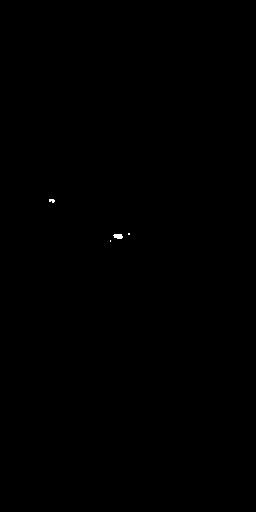

^^^^


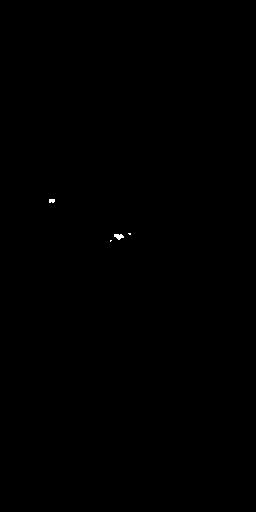

*********************


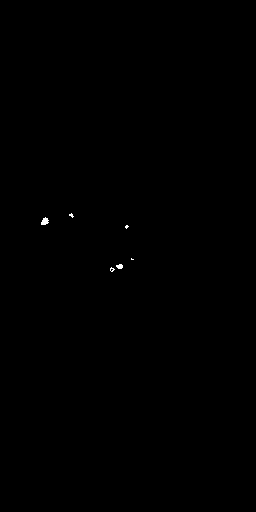

^^^^


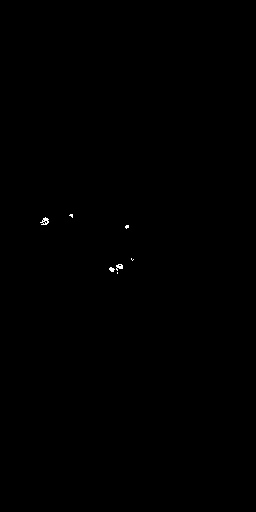

*********************


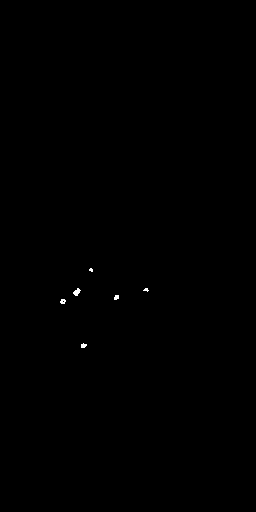

^^^^


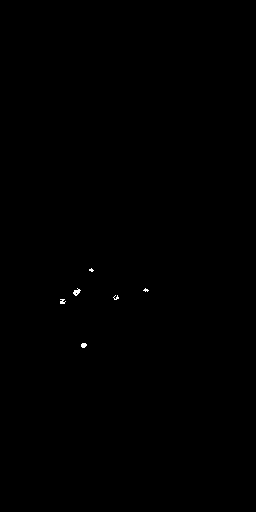

*********************


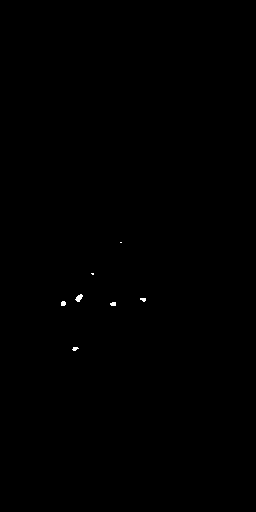

^^^^


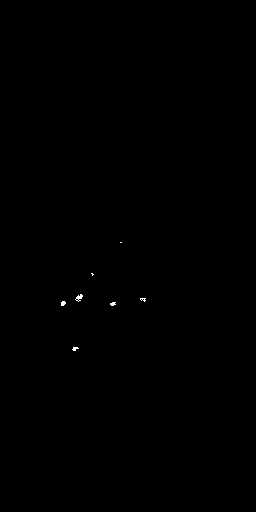

*********************


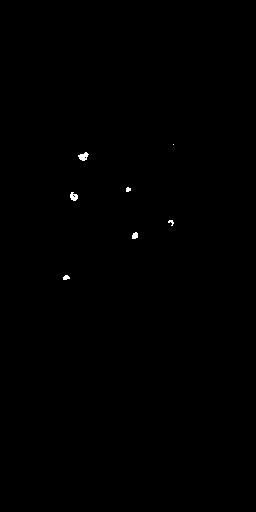

^^^^


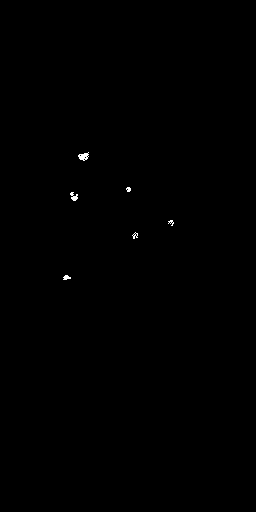

*********************


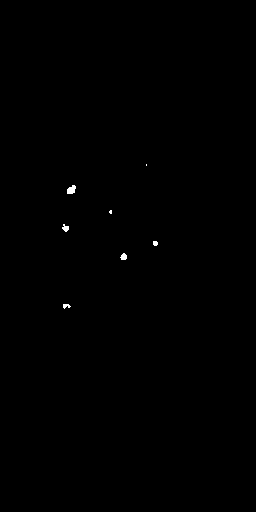

^^^^


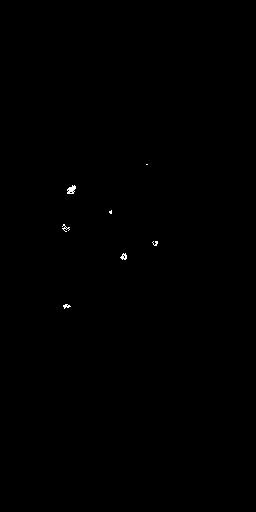

*********************


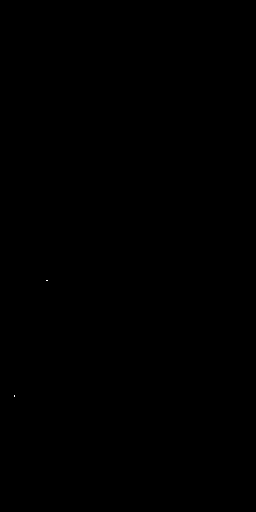

^^^^


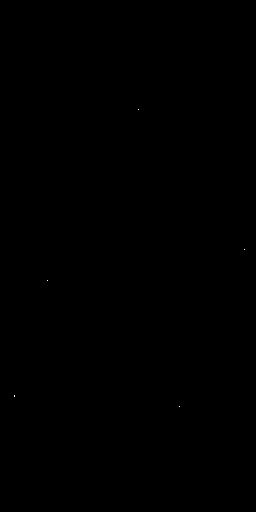

*********************


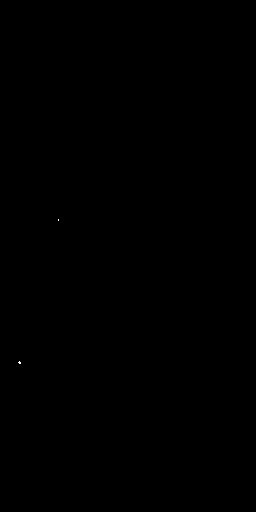

^^^^


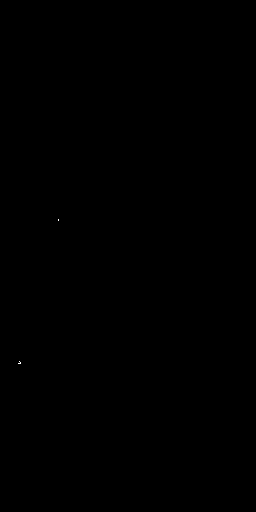

*********************


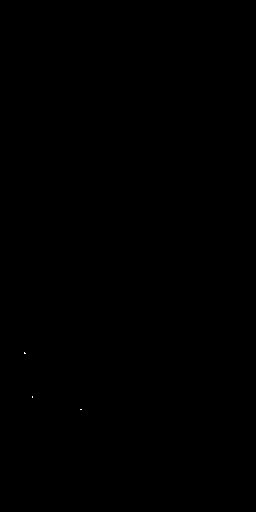

^^^^


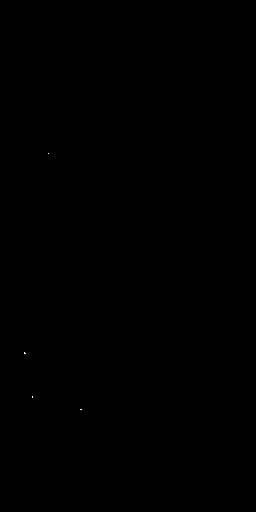

*********************


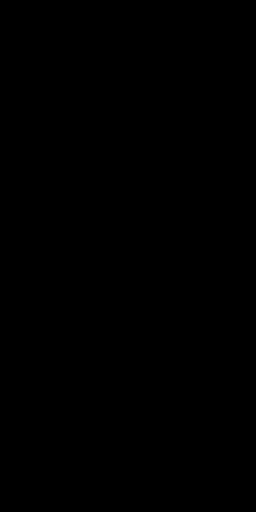

^^^^


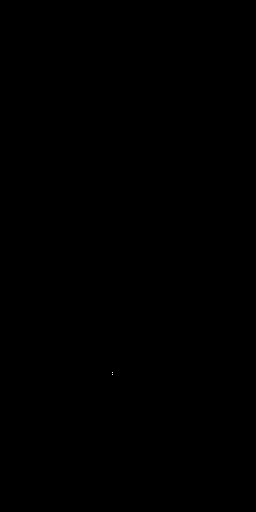

*********************


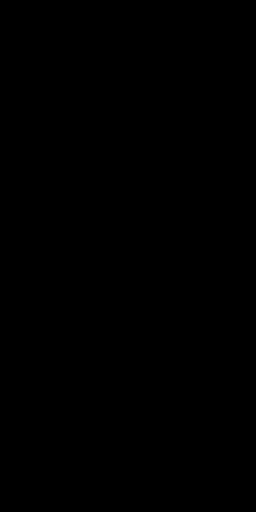

^^^^


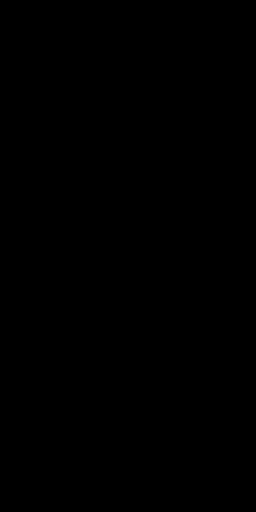

*********************


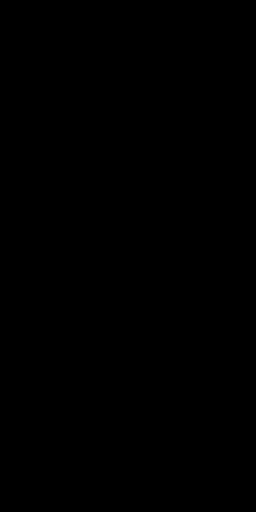

^^^^


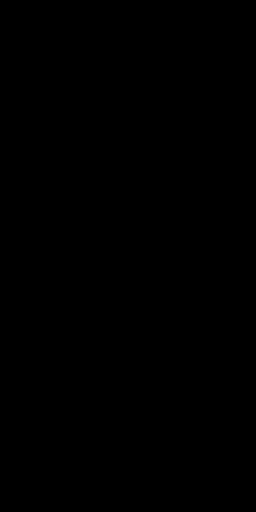

*********************


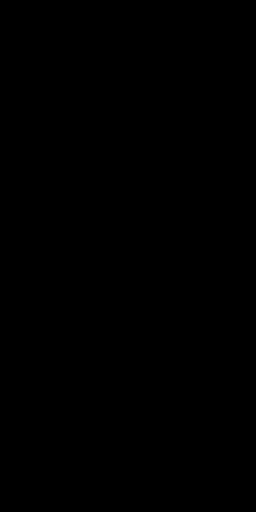

^^^^


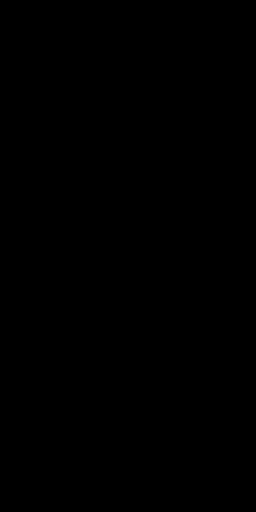

*********************


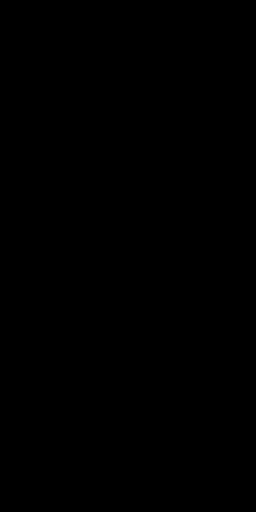

^^^^


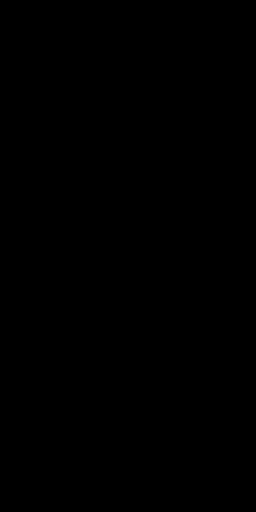

*********************


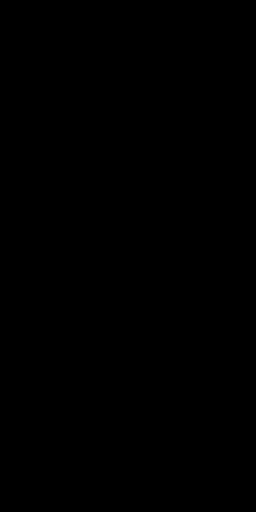

^^^^


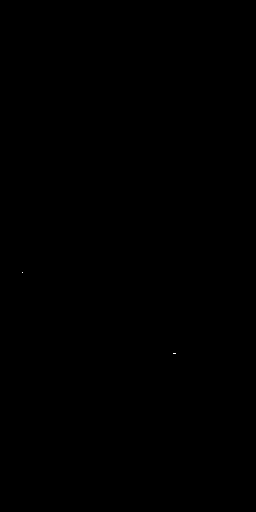

*********************


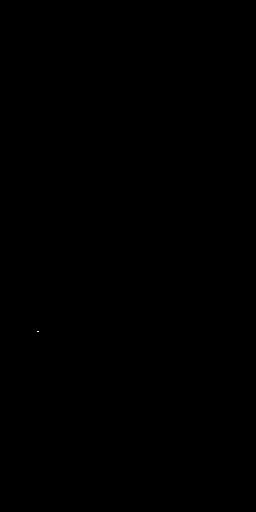

^^^^


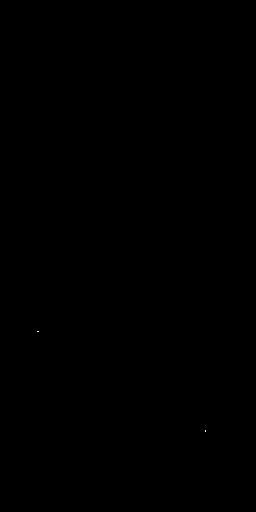

*********************


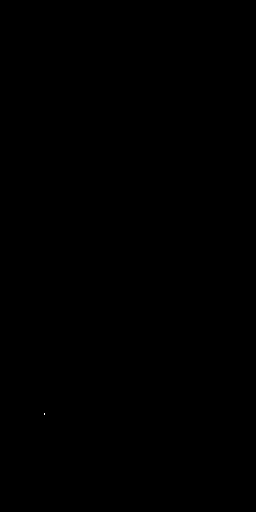

^^^^


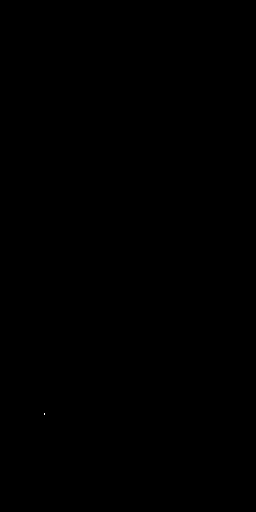

*********************


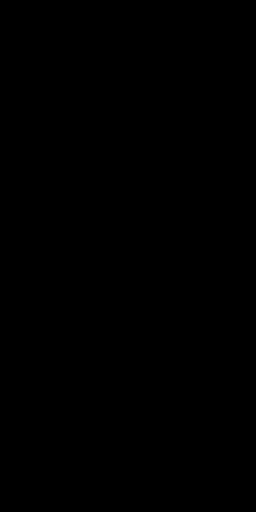

^^^^


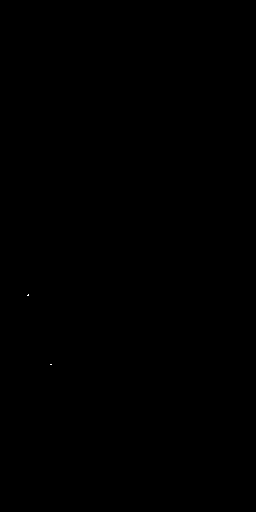

*********************


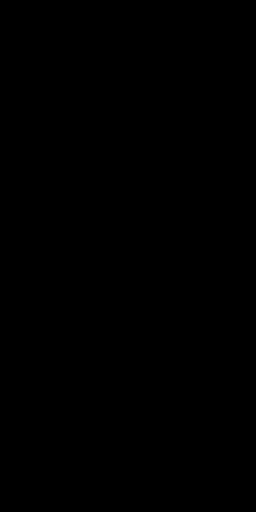

^^^^


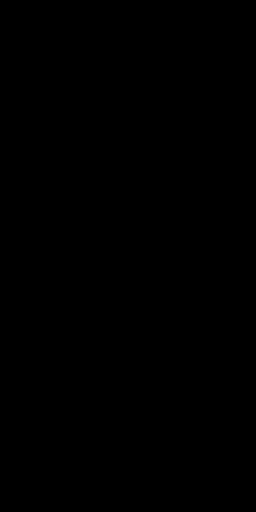

*********************


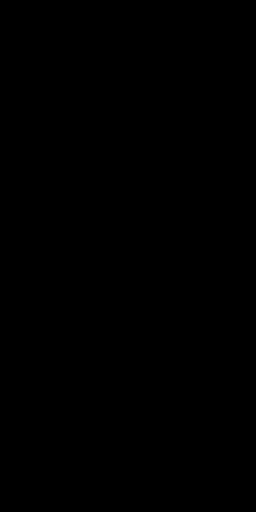

^^^^


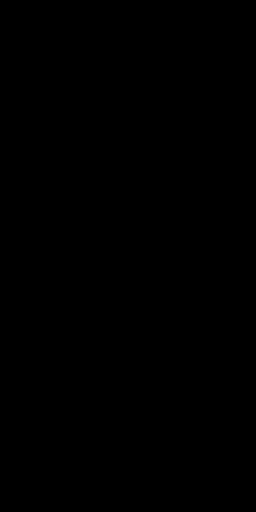

*********************


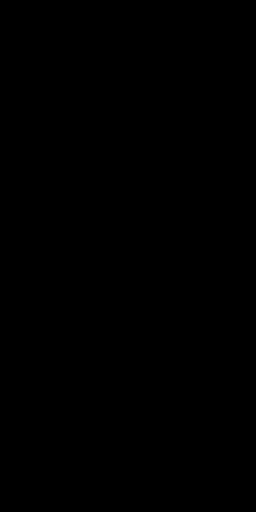

^^^^


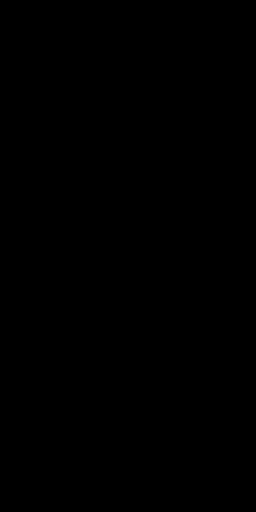

*********************


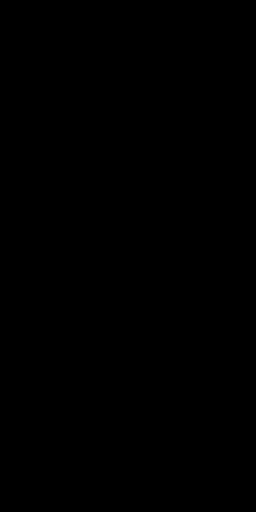

^^^^


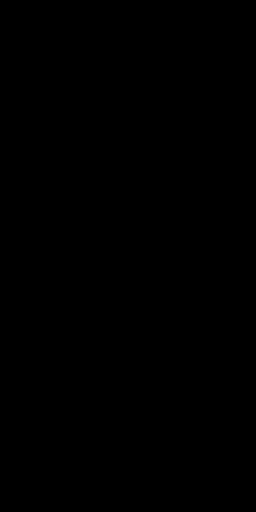

*********************


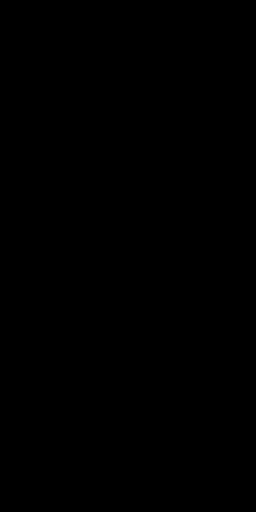

^^^^


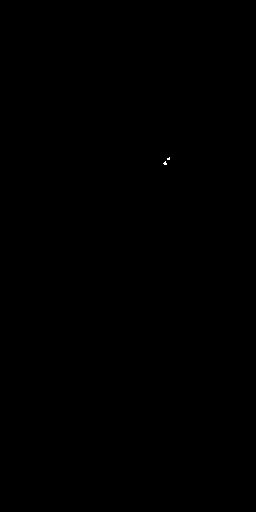

*********************


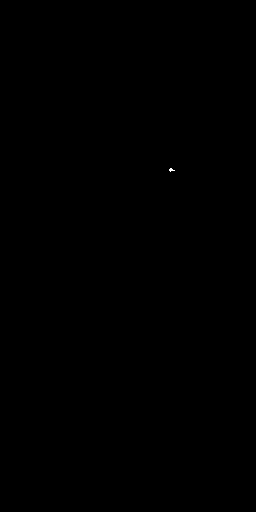

^^^^


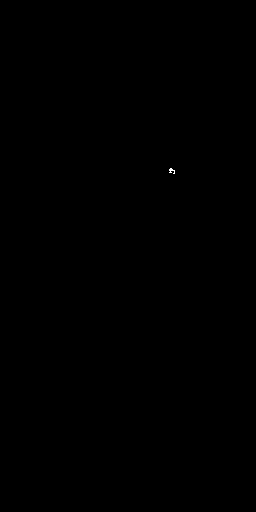

*********************


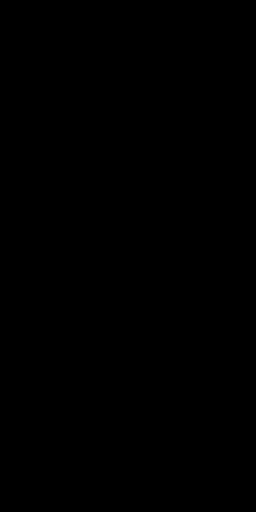

^^^^


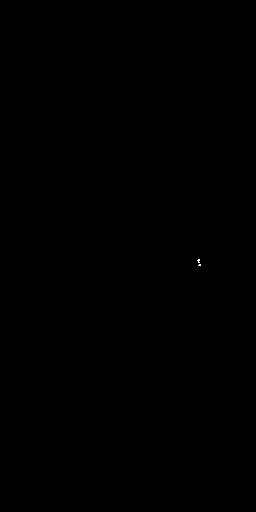

*********************


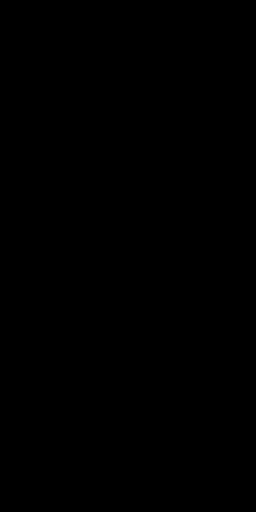

^^^^


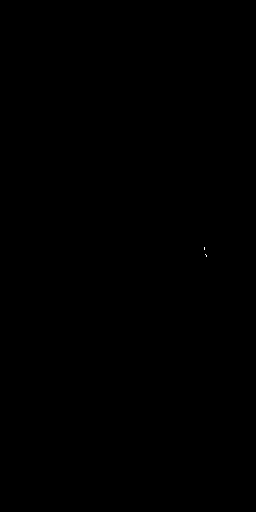

*********************


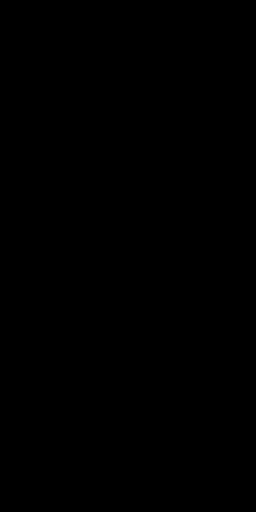

^^^^


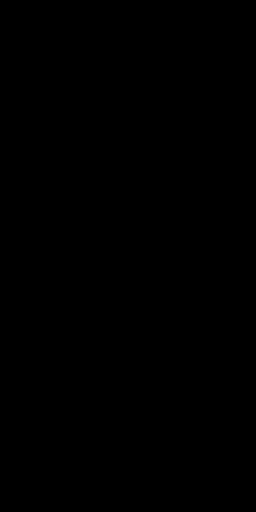

*********************


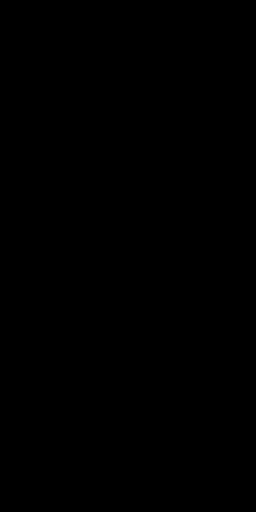

^^^^


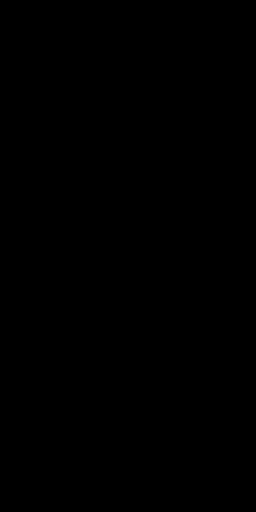

*********************


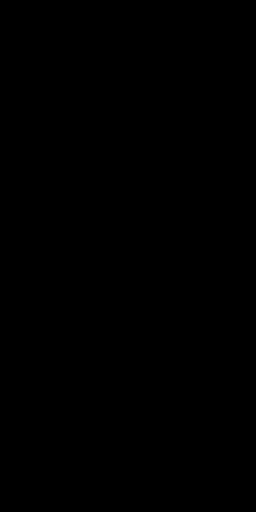

^^^^


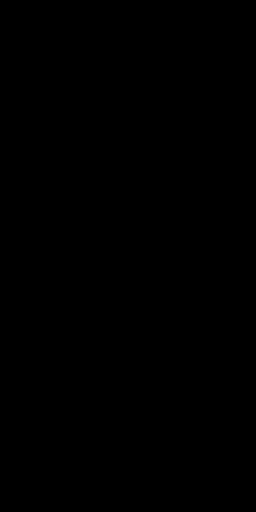

*********************


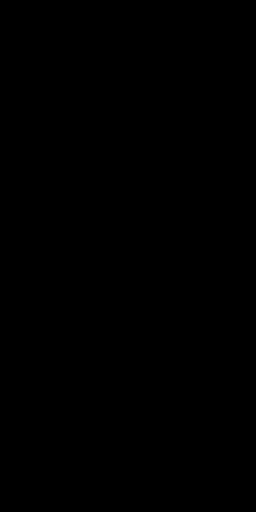

^^^^


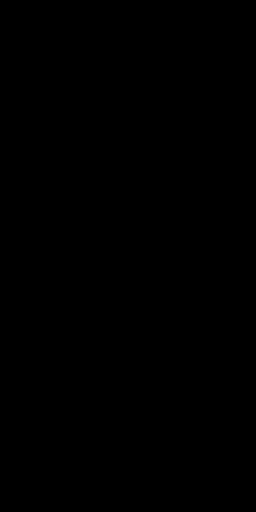

*********************


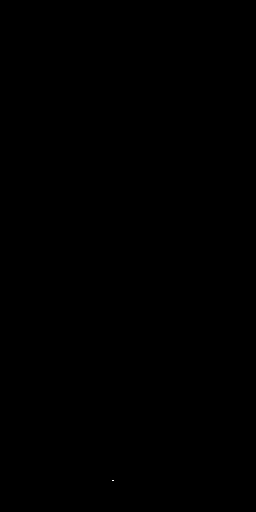

^^^^


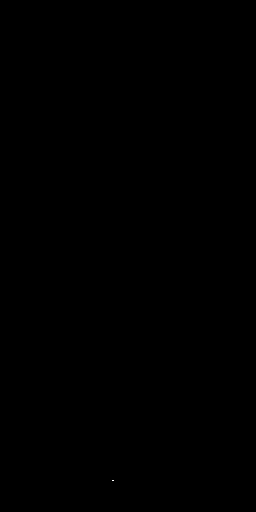

*********************


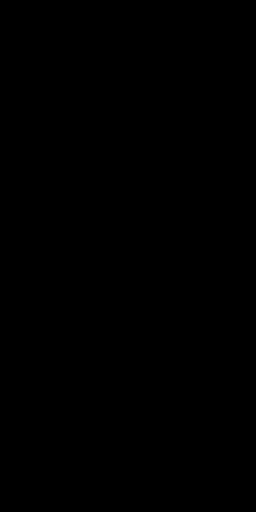

^^^^


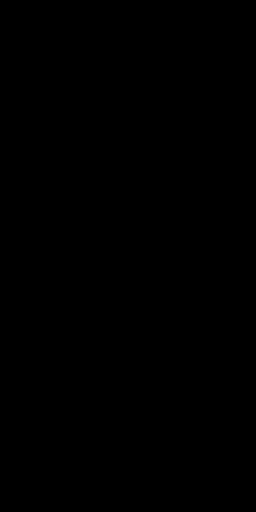

*********************


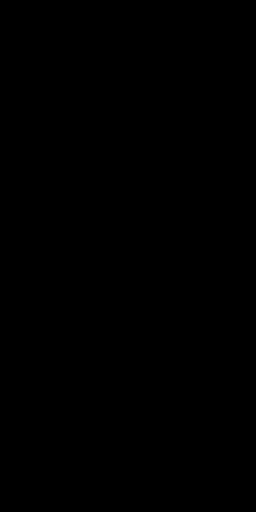

^^^^


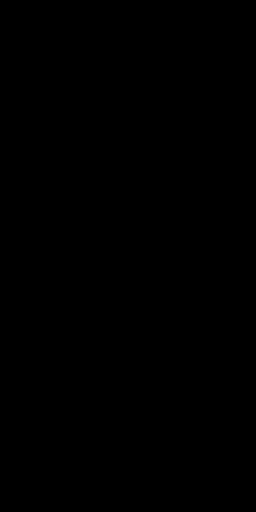

*********************


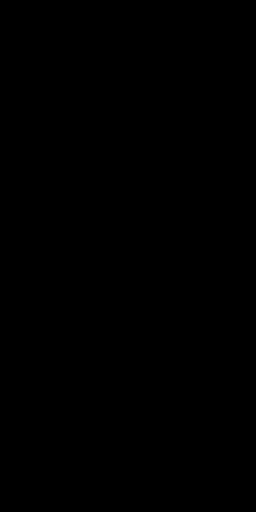

^^^^


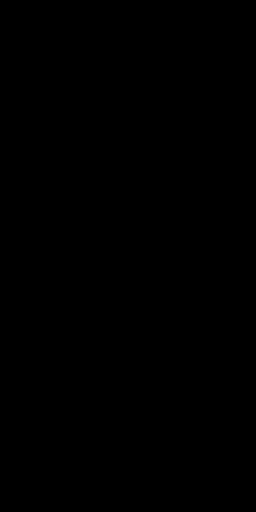

*********************


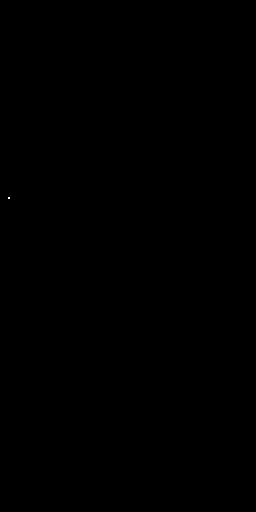

^^^^


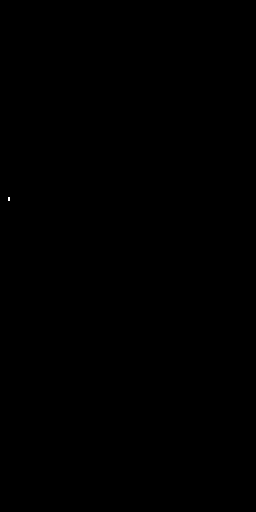

*********************


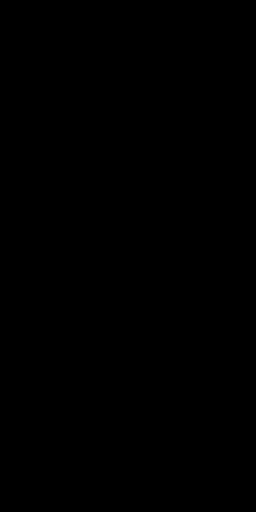

^^^^


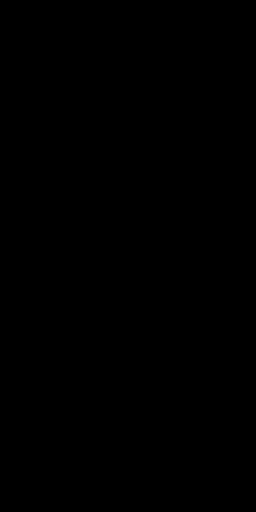

*********************


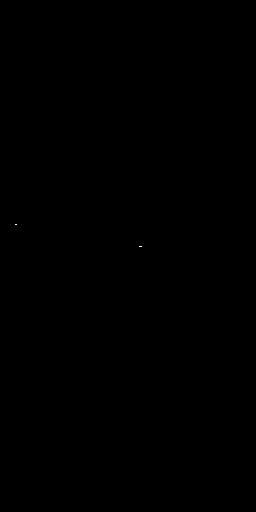

^^^^


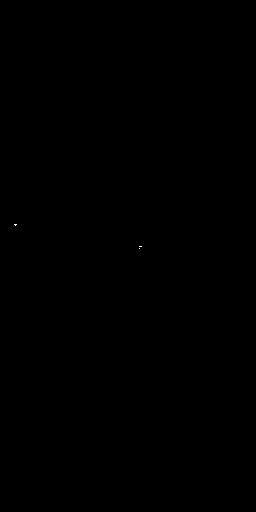

*********************


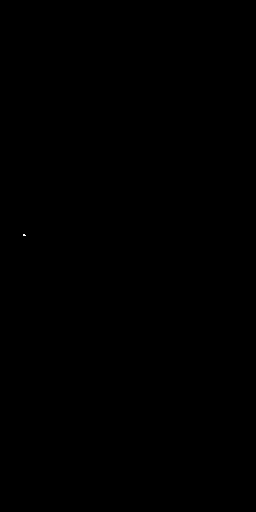

^^^^


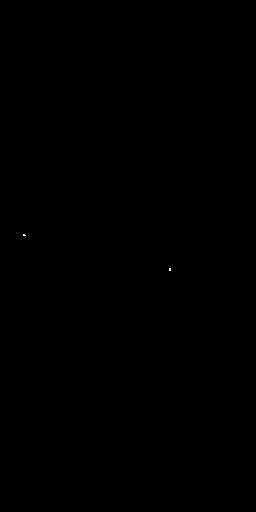

*********************


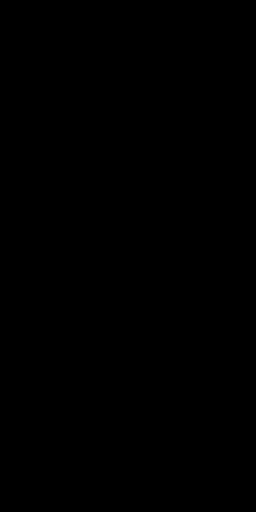

^^^^


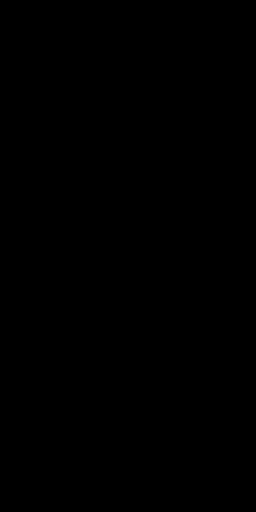

*********************


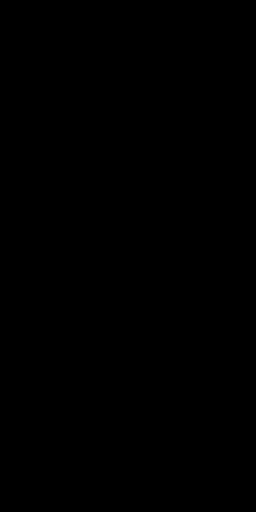

^^^^


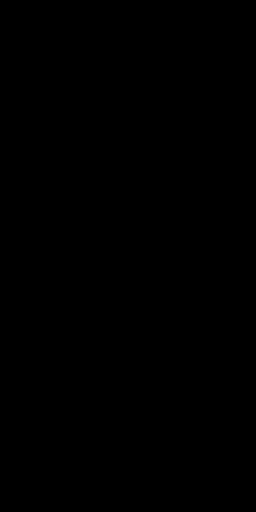

*********************


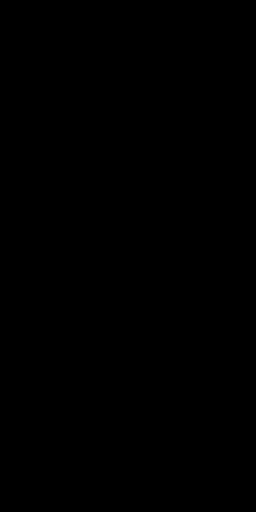

^^^^


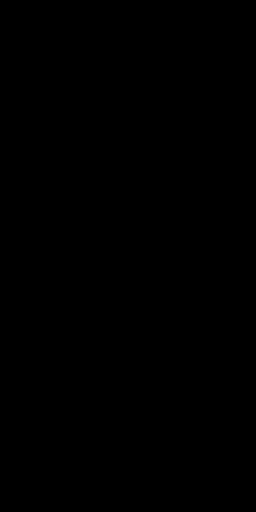

*********************


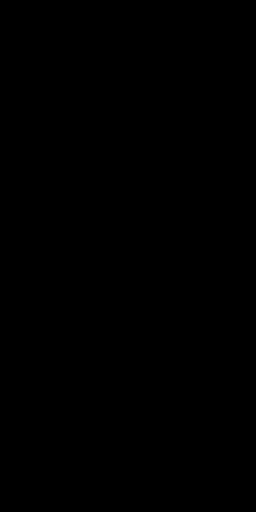

^^^^


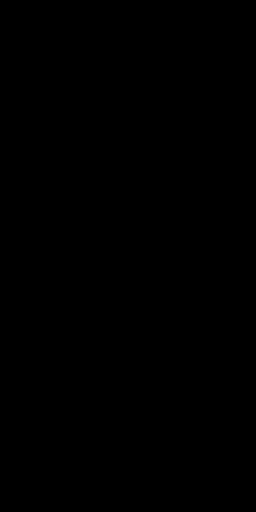

*********************


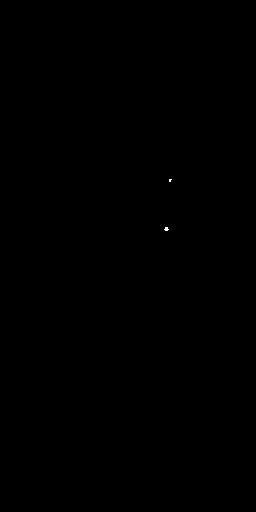

^^^^


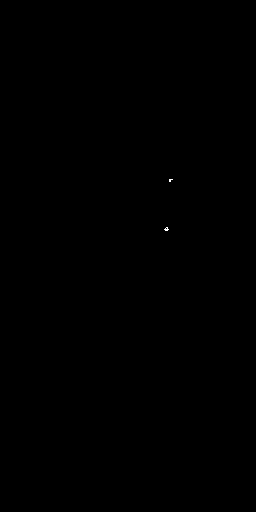

*********************


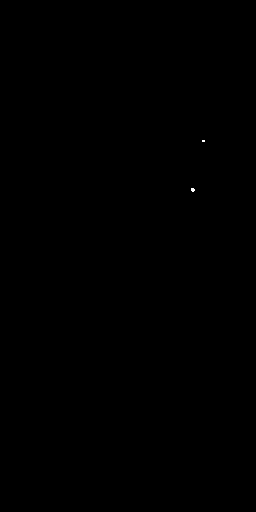

^^^^


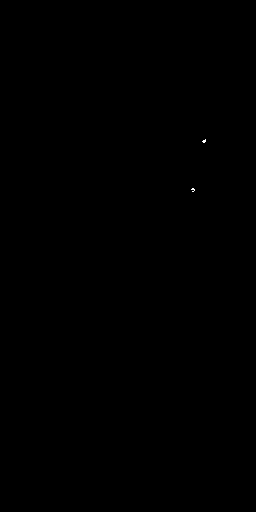

*********************


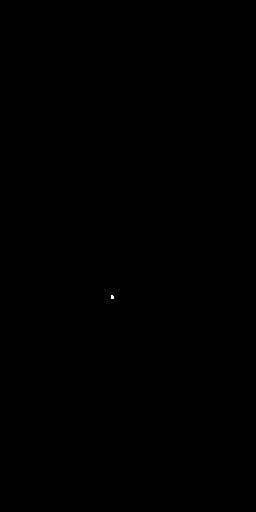

^^^^


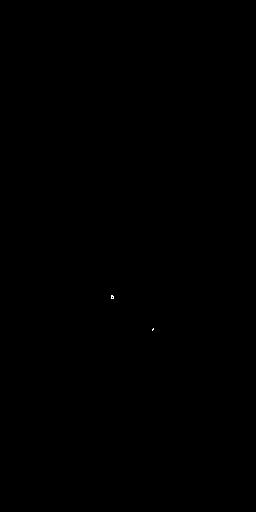

*********************


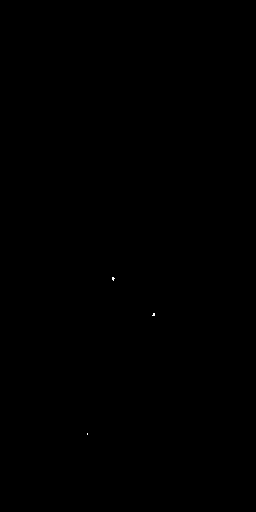

^^^^


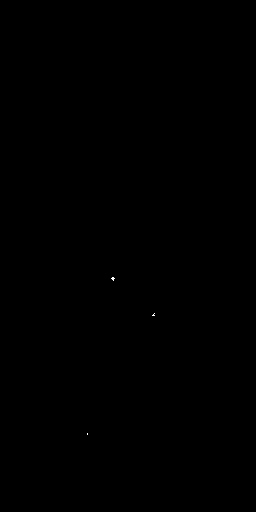

*********************


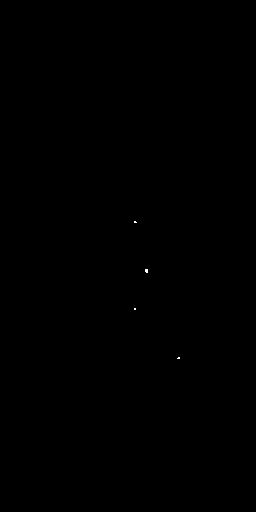

^^^^


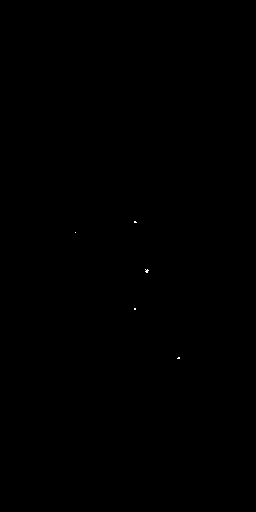

*********************


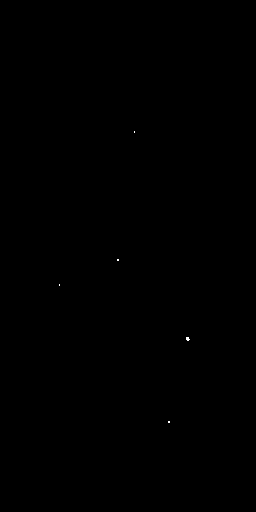

^^^^


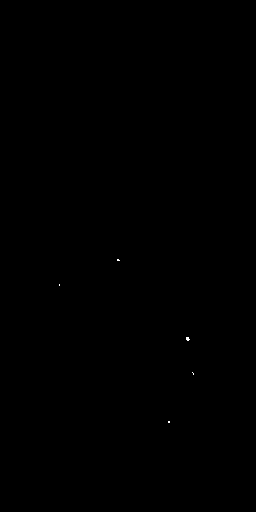

*********************


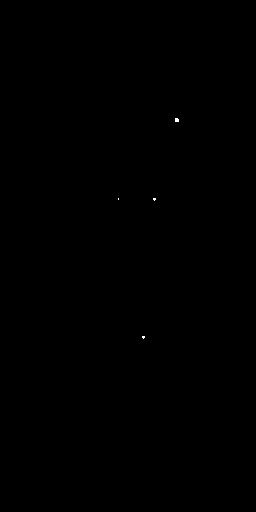

^^^^


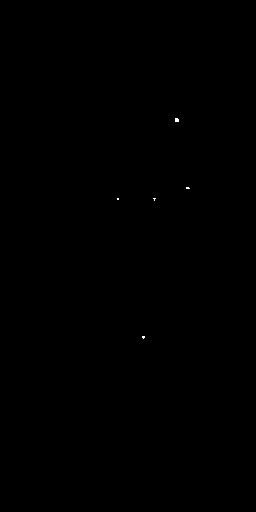

*********************


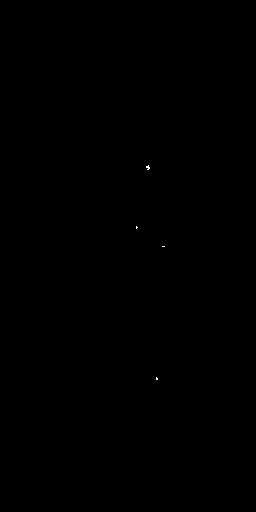

^^^^


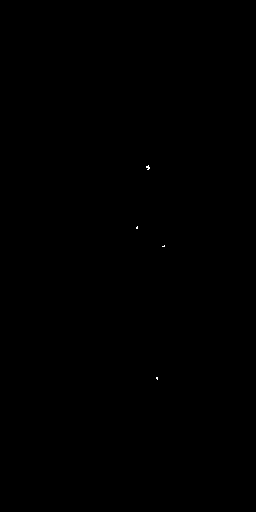

*********************


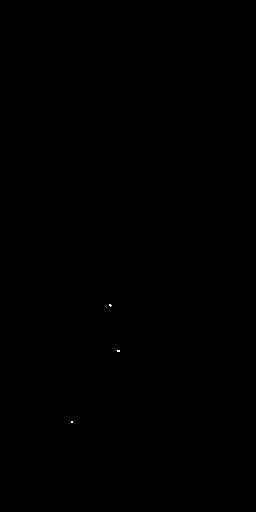

^^^^


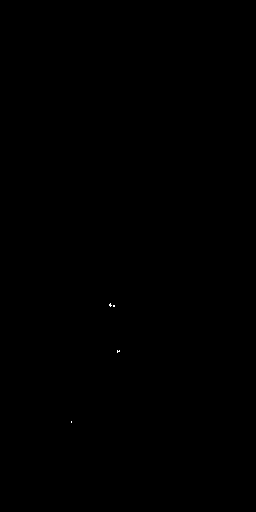

*********************


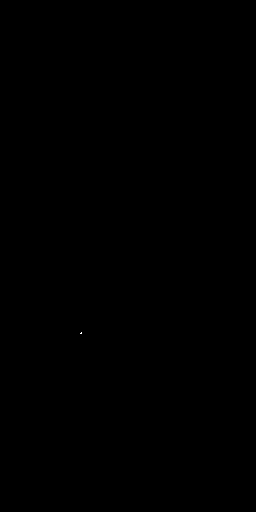

^^^^


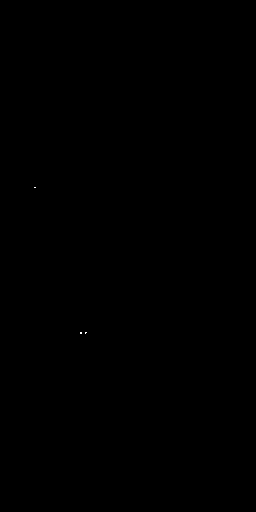

*********************


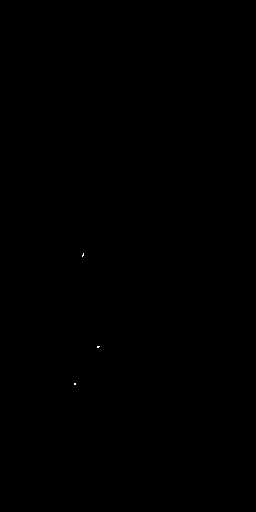

^^^^


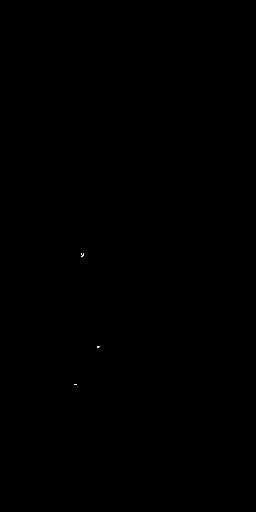

*********************


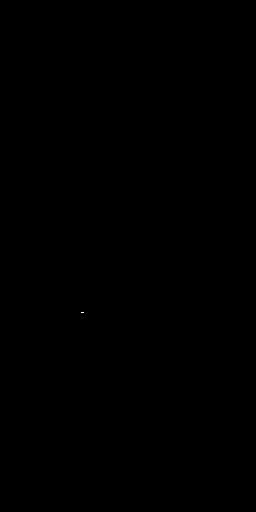

^^^^


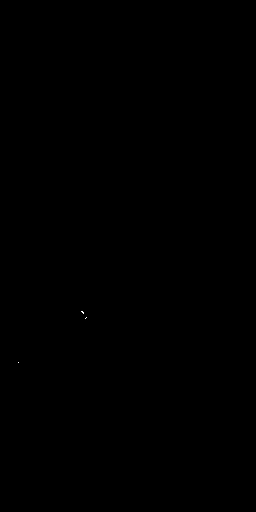

*********************


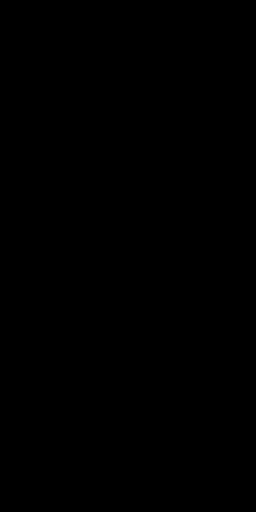

^^^^


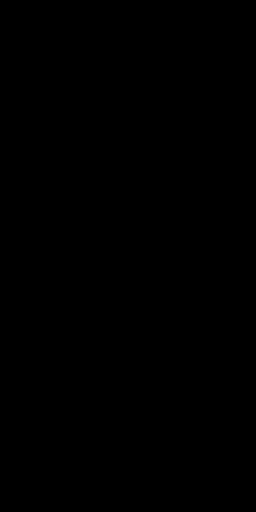

*********************


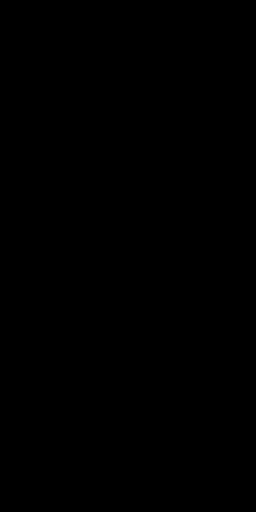

^^^^


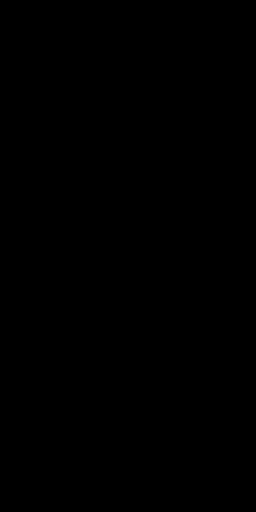

*********************


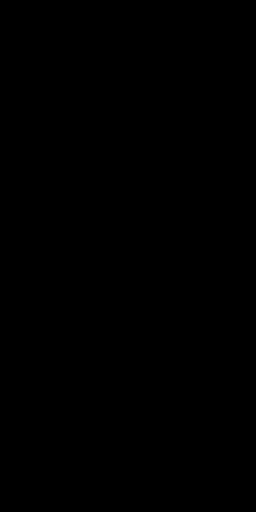

^^^^


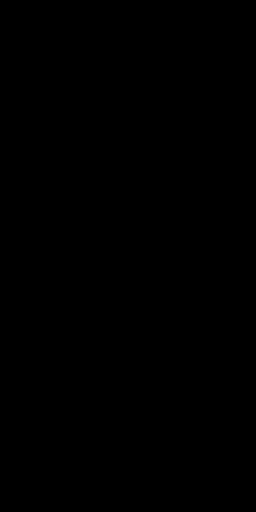

*********************


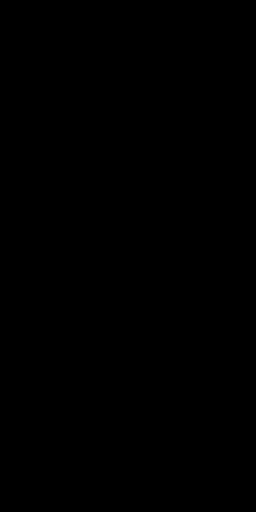

^^^^


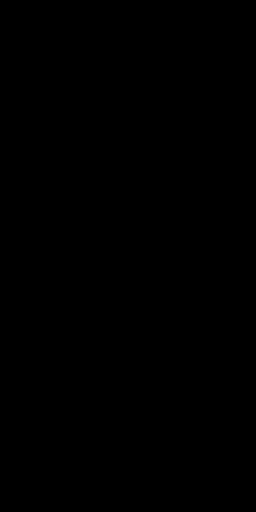

*********************


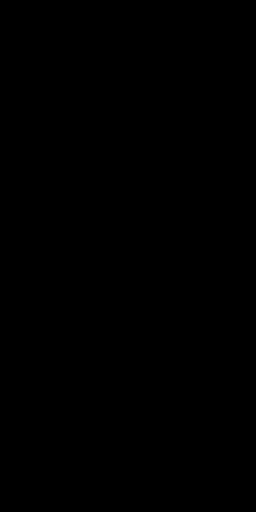

^^^^


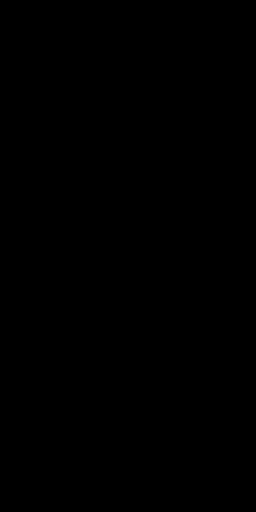

*********************


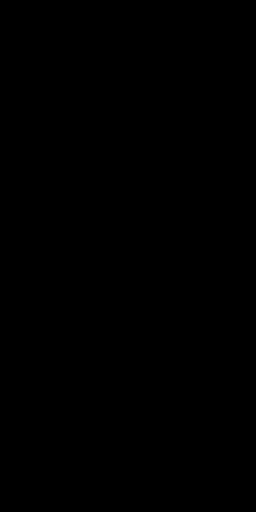

^^^^


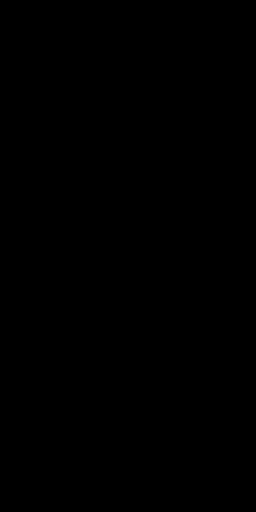

*********************


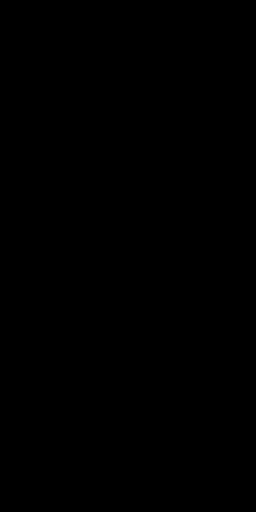

^^^^


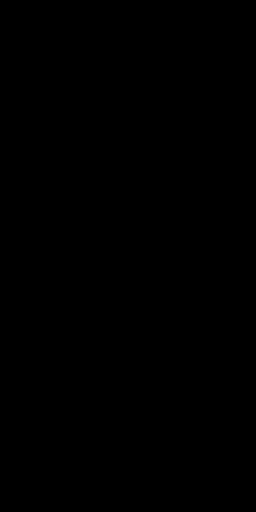

*********************


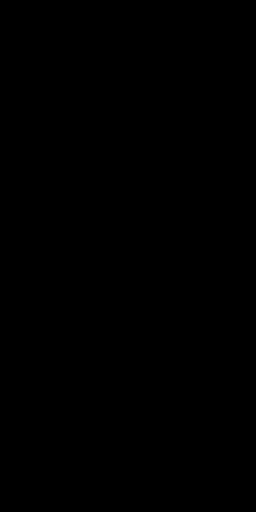

^^^^


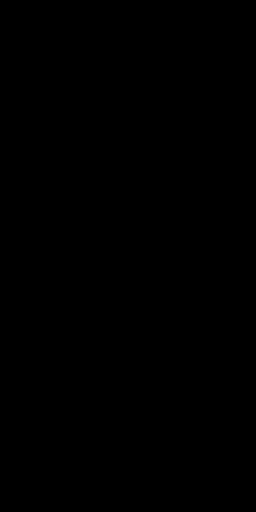

*********************


In [ ]:
for index,val in enumerate(Prediction):
  cv2_imshow(np.max(val,axis=-1)*255)
  print("^^^^")
  cv2_imshow(np.array(y_[index])*255)
  print("*********************")